## Подготовка данных

In [1]:
!pip install fastdtw

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp310-cp310-linux_x86_64.whl size=512614 sha256=4bcd0701e0a3445829b705a0ab4e5ec2cefa8adfbb64c1558f8da6c831771b2b
  Stored in directory: /root/.cache/pip/wheels/73/c8/f7/c25448dab74c3acf4848bc25d513c736bb93910277e1528ef4
Successfully built fastdtw


In [2]:
import numpy as np
import torch
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, ConcatDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import StratifiedKFold
from tqdm import trange
from transformers import TimeSeriesTransformerConfig, TimeSeriesTransformerModel, TimeSeriesTransformerForPrediction
from fastdtw import fastdtw

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
close = np.load("/content/drive/MyDrive/close_mean_ts_by_network.npy")
open = np.load("/content/drive/MyDrive/open_mean_ts_by_network.npy")

In [5]:
close.shape, open.shape # [networks, subjects, time]

((14, 84, 120), (14, 84, 120))

In [6]:
data = np.concatenate((close, open), axis=1)
data = torch.tensor(data).float()
data = data.reshape((168, 14, 120))
labels = [1] * close.shape[1] + [0] * open.shape[1] # 1 - closed, 0 - opened
labels = torch.tensor(labels).float()
batch_size = 32
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=33)

dataset = TensorDataset(data, labels)
train_dataset, test_dataset = train_test_split(dataset, test_size=0.3, random_state=44)
train_dataset, val_dataset = train_test_split(train_dataset, test_size=0.3, random_state=44)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
criterion = nn.CrossEntropyLoss()

In [7]:
num_epochs = 25

def train(model):
    print_every = 9999
    patience = 4
    epochs_increasing = 0
    last_loss = 100000
    for epoch in range(num_epochs):
        running_loss = 0.0
        y_train_true = []
        y_train_pred_proba = []

        for inputs, labels in train_loader:
            model.train()
            optimizer.zero_grad()
            output = model(inputs)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            y_train_true.extend(labels.cpu().tolist())
            y_train_pred_proba.extend(output.cpu().tolist())
            running_loss += loss.item()

        running_loss /= len(train_loader)
        y_train_true = torch.Tensor(y_train_true)
        y_train_pred_proba = torch.Tensor(y_train_pred_proba)
        train_losses.append(running_loss)
        train_pred = (torch.Tensor(y_train_pred_proba) > 0.5).float()
        accuracy = (train_pred == y_train_true).sum().item() / y_train_true.shape[0]
        train_accuracy.append(accuracy)
        roc_auc = roc_auc_score(y_train_true, y_train_pred_proba)
        train_roc_auc.append(roc_auc)

        test_loss = 0.0
        y_test_true = []
        y_test_pred_proba = []
        for inputs, labels in test_loader:
            model.eval()
            output = model(inputs)
            loss = criterion(output, labels)
            test_loss += loss.item()
            y_test_true.extend(labels.cpu().tolist())
            y_test_pred_proba.extend(output.cpu().tolist())

        test_loss /= len(test_loader)
        y_test_true = torch.Tensor(y_test_true)
        y_test_pred_proba = torch.Tensor(y_test_pred_proba)
        test_losses.append(test_loss)
        test_pred = (torch.Tensor(y_test_pred_proba) > 0.5).float()
        accuracy = (test_pred == y_test_true).sum().item() / y_test_true.shape[0]
        test_accuracy.append(accuracy)
        roc_auc = roc_auc_score(y_test_true, y_test_pred_proba)
        test_roc_auc.append(roc_auc)

        val_loss = 0.0
        for inputs, labels in val_loader:
            model.eval()
            output = model(inputs)
            loss = criterion(output, labels)
            val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        if val_loss > last_loss:
            epochs_increasing += 1
            if epochs_increasing >= patience:
                print('Early stopping!\n')
                return
        else:
            epochs_increasing = 0

        last_loss = val_loss
        if epoch % print_every == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Train loss: {running_loss:.4f}, Test loss: {test_loss:.4f}")

In [8]:
def aug_train(model):
    print_every = 9999
    patience = 4
    epochs_increasing = 0
    last_loss = 100000
    for epoch in range(num_epochs):
        running_loss = 0.0
        y_train_true = []
        y_train_pred_proba = []

        for inputs, labels in aug_train_loader:
            model.train()
            optimizer.zero_grad()
            output = model(inputs)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            y_train_true.extend(labels.cpu().tolist())
            y_train_pred_proba.extend(output.cpu().tolist())
            running_loss += loss.item()

        running_loss /= len(aug_train_loader)
        y_train_true = torch.Tensor(y_train_true)
        y_train_pred_proba = torch.Tensor(y_train_pred_proba)
        train_losses.append(running_loss)
        train_pred = (torch.Tensor(y_train_pred_proba) > 0.5).float()
        accuracy = (train_pred == y_train_true).sum().item() / y_train_true.shape[0]
        train_accuracy.append(accuracy)
        roc_auc = roc_auc_score(y_train_true, y_train_pred_proba)
        train_roc_auc.append(roc_auc)

        test_loss = 0.0
        y_test_true = []
        y_test_pred_proba = []
        for inputs, labels in test_loader:
            model.eval()
            output = model(inputs)
            loss = criterion(output, labels)
            test_loss += loss.item()
            y_test_true.extend(labels.cpu().tolist())
            y_test_pred_proba.extend(output.cpu().tolist())

        test_loss /= len(aug_test_loader)
        y_test_true = torch.Tensor(y_test_true)
        y_test_pred_proba = torch.Tensor(y_test_pred_proba)
        test_losses.append(test_loss)
        test_pred = (torch.Tensor(y_test_pred_proba) > 0.5).float()
        accuracy = (test_pred == y_test_true).sum().item() / y_test_true.shape[0]
        aug_accuracy_on_real.append(accuracy)
        roc_auc = roc_auc_score(y_test_true, y_test_pred_proba)
        aug_roc_auc_on_real.append(roc_auc)

        y_test_true = []
        y_test_pred_proba = []
        for inputs, labels in aug_test_loader:
            output = model(inputs)
            y_test_true.extend(labels.cpu().tolist())
            y_test_pred_proba.extend(output.cpu().tolist())
        y_test_true = torch.Tensor(y_test_true)
        y_test_pred_proba = torch.Tensor(y_test_pred_proba)
        test_pred = (torch.Tensor(y_test_pred_proba) > 0.5).float()
        accuracy = (test_pred == y_test_true).sum().item() / y_test_true.shape[0]
        test_accuracy.append(accuracy)
        roc_auc = roc_auc_score(y_test_true, y_test_pred_proba)
        test_roc_auc.append(roc_auc)

        val_loss = 0.0
        for inputs, labels in aug_val_loader:
            model.eval()
            output = model(inputs)
            loss = criterion(output, labels)
            val_loss += loss.item()

        val_loss /= len(aug_val_loader)
        val_losses.append(val_loss)
        if val_loss > last_loss:
            epochs_increasing += 1
            if epochs_increasing >= patience:
                print('Early stopping!\n')
                return
        else:
            epochs_increasing = 0

        last_loss = val_loss
        if epoch % print_every == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Train loss: {running_loss:.4f}, Test loss: {test_loss:.4f}")

In [9]:
class TimeSeriesCNN(nn.Module):
    def __init__(self, input_channels, hidden_size=128, dropout=0.1, conv_output_size=1120):
        super(TimeSeriesCNN, self).__init__()
        self.conv_layers = nn.ModuleList()
        self.input_channels = input_channels

        for _ in range(input_channels):
            self.conv_layers.append(nn.Sequential(
                nn.Conv1d(1, 128, kernel_size=5),
                nn.BatchNorm1d(128),
                nn.LeakyReLU(0.1),
                nn.Dropout(p=dropout),
                nn.MaxPool1d(kernel_size=2, stride=2, padding=1),

                nn.Conv1d(128, 64, kernel_size=5),
                nn.BatchNorm1d(64),
                nn.LeakyReLU(0.1),
                nn.Dropout(p=dropout),
                nn.MaxPool1d(kernel_size=2, stride=2, padding=1),

                nn.Conv1d(64, 32, kernel_size=5),
                nn.BatchNorm1d(32),
                nn.LeakyReLU(0.1),
                nn.Dropout(p=dropout),
                nn.MaxPool1d(kernel_size=2, stride=2, padding=1),

                nn.Conv1d(32, 16, kernel_size=5),
                nn.BatchNorm1d(16),
                nn.LeakyReLU(0.1),
                nn.Dropout(p=dropout),
                nn.MaxPool1d(kernel_size=2, stride=2, padding=1),
            ))

        self.fc1 = nn.Linear(conv_output_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        conv_outs = []
        for i in range(self.input_channels):
            conv_out = self.conv_layers[i](x[:, i:i+1, :])
            conv_outs.append(conv_out)
        conv_out = torch.cat(conv_outs, dim=1)
        conv_out = conv_out.view(conv_out.size(0), -1)
        fc_out = F.relu(self.fc1(conv_out))
        output = torch.sigmoid(self.fc2(fc_out))
        return output.squeeze(1)

Иногда early stopping может сработать очень рано, но всё должно работать, если просто переинициализировать модель и перезапустить обучение

## IHB настоящие

In [12]:
n_experiments = 2

train_losses_hist = []
test_losses_hist = []
train_accuracy_hist = []
test_accuracy_hist = []
train_roc_auc_hist = []
test_roc_auc_hist = []
val_losses_hist = []

input_channels = close.shape[0]

for _ in range(n_experiments):
    for _, (train_index, test_index) in enumerate(kf.split(data, labels)):
      train_data = data[train_index]
      train_labels = labels[train_index]
      test_data = data[test_index]
      test_labels = labels[test_index]
      train_dataset = TensorDataset(train_data, train_labels)
      test_dataset = TensorDataset(test_data, test_labels)
      train_dataset, val_dataset = train_test_split(train_dataset, test_size=0.3, random_state=33)
      train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
      test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
      val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

      train_losses = []
      test_losses = []
      train_accuracy = []
      test_accuracy = []
      train_roc_auc = []
      test_roc_auc = []
      val_losses = []

      model = TimeSeriesCNN(input_channels)
      criterion = nn.CrossEntropyLoss()
      optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)
      train(model)

      train_losses_hist.append(train_losses)
      test_losses_hist.append(test_losses)
      train_accuracy_hist.append(train_accuracy)
      test_accuracy_hist.append(test_accuracy)
      train_roc_auc_hist.append(train_roc_auc)
      test_roc_auc_hist.append(test_roc_auc)
      val_losses_hist.append(val_losses)

Epoch 1/25, Train loss: 58.0247, Test loss: 26.5160
Epoch 1/25, Train loss: 57.6832, Test loss: 29.2588
Epoch 1/25, Train loss: 57.6683, Test loss: 26.4540
Early stopping!

Epoch 1/25, Train loss: 59.1957, Test loss: 29.3430
Epoch 1/25, Train loss: 60.3197, Test loss: 27.5074
Epoch 1/25, Train loss: 57.7815, Test loss: 27.7862
Epoch 1/25, Train loss: 57.4704, Test loss: 27.8394
Epoch 1/25, Train loss: 57.7117, Test loss: 27.8588
Early stopping!

Epoch 1/25, Train loss: 59.1237, Test loss: 27.5214
Epoch 1/25, Train loss: 60.2621, Test loss: 27.4805


In [13]:
train_losses_np = np.array([lst + [0] * (num_epochs - len(lst)) for lst in train_losses_hist])
test_losses_np = np.array([lst + [0] * (num_epochs - len(lst)) for lst in test_losses_hist])
val_losses_np = np.array([lst + [0] * (num_epochs - len(lst)) for lst in val_losses_hist])
train_accuracy_np = np.array([lst + [0] * (num_epochs - len(lst)) for lst in train_accuracy_hist])
test_accuracy_np = np.array([lst + [0] * (num_epochs - len(lst)) for lst in test_accuracy_hist])
train_roc_auc_np = np.array([lst + [0] * (num_epochs - len(lst)) for lst in train_roc_auc_hist])
test_roc_auc_np = np.array([lst + [0] * (num_epochs - len(lst)) for lst in test_roc_auc_hist])

train_losses_np[train_losses_np == 0] = np.nan
test_losses_np[test_losses_np == 0] = np.nan
val_losses_np[val_losses_np == 0] = np.nan
train_accuracy_np[train_accuracy_np == 0] = np.nan
test_accuracy_np[test_accuracy_np == 0] = np.nan
train_roc_auc_np[train_roc_auc_np == 0] = np.nan
test_roc_auc_np[test_roc_auc_np == 0] = np.nan

train_losses_mean = np.nanmean(train_losses_np, axis=0)
train_losses_std = np.nanstd(train_losses_np, axis=0)
test_losses_mean = np.nanmean(test_losses_np, axis=0)
test_losses_std = np.nanstd(test_losses_np, axis=0)
val_losses_mean = np.nanmean(val_losses_np, axis=0)
val_losses_std = np.nanstd(val_losses_np, axis=0)
train_accuracy_mean = np.nanmean(train_accuracy_np, axis=0)
train_accuracy_std = np.nanstd(train_accuracy_np, axis=0)
test_accuracy_mean = np.nanmean(test_accuracy_np, axis=0)
test_accuracy_std = np.nanstd(test_accuracy_np, axis=0)
train_roc_auc_mean = np.nanmean(train_roc_auc_np, axis=0)
train_roc_auc_std = np.nanstd(train_roc_auc_np, axis=0)
test_roc_auc_mean = np.nanmean(test_roc_auc_np, axis=0)
test_roc_auc_std = np.nanstd(test_roc_auc_np, axis=0)

In [14]:
ihb_real_acc_mean = np.max(test_accuracy_mean)
ihb_real_acc_std = test_accuracy_std[np.argmax(test_accuracy_mean)]
ihb_real_roc_mean = np.max(test_roc_auc_mean)
ihb_real_roc_std = test_roc_auc_std[np.argmax(test_roc_auc_mean)]

In [15]:
ihb_real_acc = test_accuracy_np
ihb_real_roc = test_roc_auc_np

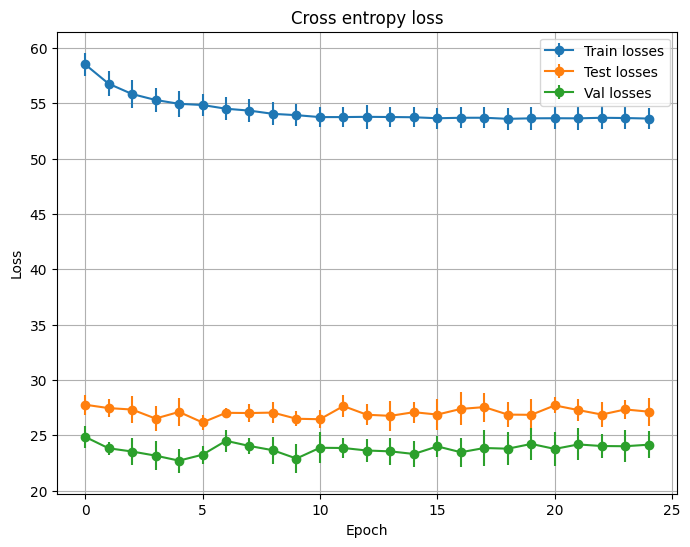

In [16]:
plt.figure(figsize=(8, 6))
plt.errorbar(range(train_losses_mean.shape[0]), train_losses_mean, yerr=train_losses_std, fmt='-o', label='Train losses')
plt.errorbar(range(test_losses_mean.shape[0]), test_losses_mean, yerr=test_losses_std, fmt='-o', label='Test losses')
plt.errorbar(range(val_losses_mean.shape[0]), val_losses_mean, yerr=val_losses_std, fmt='-o', label='Val losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Cross entropy loss')
plt.legend()
plt.grid(True)
plt.show()

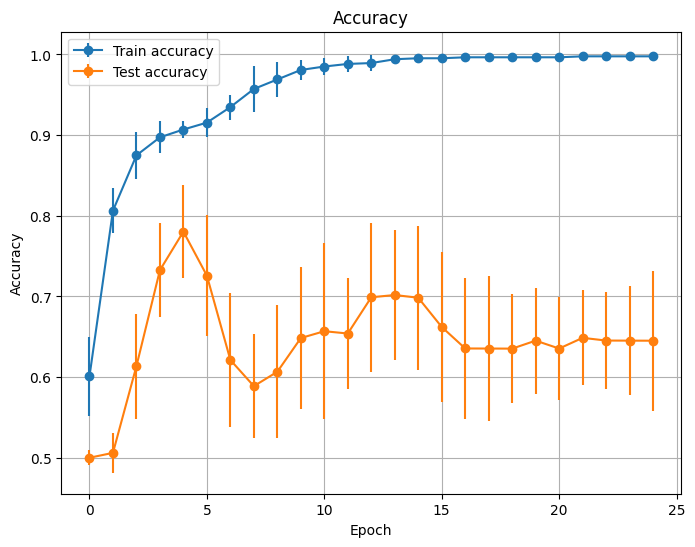

In [17]:
plt.figure(figsize=(8, 6))
plt.errorbar(range(train_accuracy_mean.shape[0]), train_accuracy_mean, yerr=train_accuracy_std, fmt='-o', label='Train accuracy')
plt.errorbar(range(test_accuracy_mean.shape[0]), test_accuracy_mean, yerr=test_accuracy_std, fmt='-o', label='Test accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

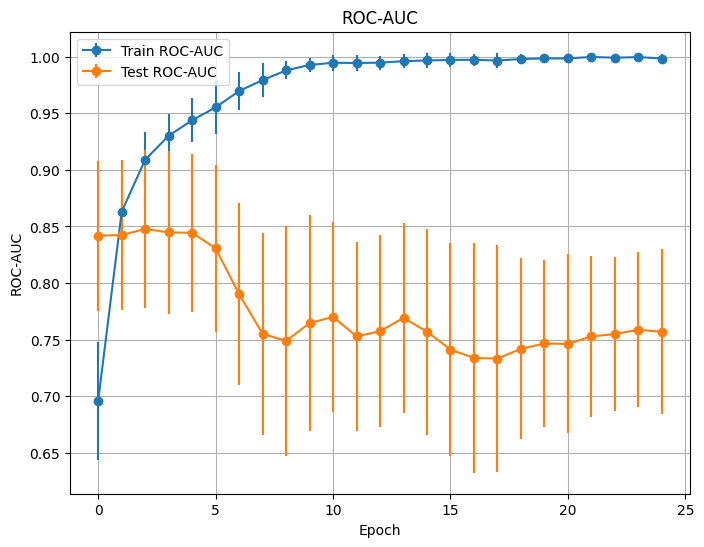

In [18]:
plt.figure(figsize=(8, 6))
plt.errorbar(range(train_roc_auc_mean.shape[0]), train_roc_auc_mean, yerr=train_roc_auc_std, fmt='-o', label='Train ROC-AUC')
plt.errorbar(range(test_roc_auc_mean.shape[0]), test_roc_auc_mean, yerr=test_roc_auc_std, fmt='-o', label='Test ROC-AUC')
plt.xlabel('Epoch')
plt.ylabel('ROC-AUC')
plt.title('ROC-AUC')
plt.legend()
plt.grid(True)
plt.show()

## IHB аугментация

In [10]:
data = data.reshape((168, 120, 14))

In [11]:
past_values = []
future_values = []
past_time_features = []
future_time_features = []
static_categorical_features = []
for i in range(data.shape[0]):
  start = 0
  while start + 24 < data[i].shape[0]:
    past_values.append(data[i][start : start+20])
    future_values.append(data[i][start+20 : start+24])
    past_time_features.append(range(start, start+20))
    future_time_features.append(range(start+20, start+24))
    static_categorical_features.append(1 - (i // (data.shape[0] // 2)))
    start += 4
past_values = torch.stack(past_values)
future_values = torch.stack(future_values)
past_time_features = torch.Tensor(past_time_features)
future_time_features = torch.Tensor(future_time_features)
past_time_features = past_time_features.reshape((past_time_features.shape[0], past_time_features.shape[1], 1))
future_time_features = future_time_features.reshape((future_time_features.shape[0], future_time_features.shape[1], 1))
past_observed_mask = torch.ones(past_values.shape)
static_categorical_features = torch.Tensor(static_categorical_features).int()

In [12]:
n = past_values.shape[0]
test_size = 0.2
test_idx = np.random.choice(range(n), size=int(test_size * n), replace=False)
train_idx = np.setdiff1d(range(n), test_idx)
train_past_values = past_values[train_idx]
test_past_values = past_values[test_idx]
train_future_values = future_values[train_idx]
test_future_values = future_values[test_idx]
train_past_time_features = past_time_features[train_idx]
test_past_time_features = past_time_features[test_idx]
train_future_time_features = future_time_features[train_idx]
test_future_time_features = future_time_features[test_idx]
train_past_observed_mask = past_observed_mask[train_idx]
test_past_observed_mask = past_observed_mask[test_idx]
train_static_categorical_features = static_categorical_features[train_idx]
test_static_categorical_features = static_categorical_features[test_idx]

In [13]:
train_dataset = []
for i in range(train_past_values.shape[0]):
    train_dataset.append({
        "past_values": train_past_values[i],
        "future_values": train_future_values[i],
        "past_time_features": train_past_time_features[i],
        "future_time_features": train_future_time_features[i],
        "past_observed_mask": train_past_observed_mask[i],
        "static_categorical_features": train_static_categorical_features[i]
    })

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = []
for i in range(test_past_values.shape[0]):
    test_dataset.append({
        "past_values": test_past_values[i],
        "future_values": test_future_values[i],
        "past_time_features": test_past_time_features[i],
        "future_time_features": test_future_time_features[i],
        "past_observed_mask": test_past_observed_mask[i],
        "static_categorical_features": test_static_categorical_features[i]
    })

test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [14]:
lags_sequence = [1, 2, 3, 4, 5, 6, 7]
configuration = TimeSeriesTransformerConfig(prediction_length=4, context_length=20 - len(lags_sequence), input_size=14,
                                            num_time_features=1, lags_sequence=lags_sequence, num_parallel_samples=1,
                                            num_static_categorical_features=1, cardinality=[2], embedding_dimension=[1])
model = TimeSeriesTransformerForPrediction(configuration)
optimizer = torch.optim.AdamW(model.parameters(), lr=6e-4, betas=(0.9, 0.95), weight_decay=1e-1)

In [15]:
n_epochs = 100
print_every = 10
train_losses = []
test_losses = []
for epoch in range(n_epochs):
    for idx, batch in enumerate(train_dataloader):
        model.train()
        optimizer.zero_grad()

        loss = model(
            past_values=batch["past_values"],
            future_values=batch["future_values"],
            past_time_features=batch["past_time_features"],
            future_time_features=batch["future_time_features"],
            past_observed_mask=batch["past_observed_mask"],
            static_categorical_features=batch["static_categorical_features"].reshape((batch["static_categorical_features"].shape[0], 1))
        ).loss
        loss.backward()
        train_losses.append(loss.item())

        optimizer.step()

        if epoch % print_every == 0 and idx == 0:
            print("Epoch: ", epoch, ", Train loss: ", loss.item(), end="", sep="")

    for idx, batch in enumerate(test_dataloader):
        model.eval()
        loss = model(
            past_values=batch["past_values"],
            future_values=batch["future_values"],
            past_time_features=batch["past_time_features"],
            future_time_features=batch["future_time_features"],
            past_observed_mask=batch["past_observed_mask"],
            static_categorical_features=batch["static_categorical_features"].reshape((batch["static_categorical_features"].shape[0], 1))
        ).loss
        test_losses.append(loss.item())
        if epoch % print_every == 0 and idx == 0:
            print(", Test loss:", loss.item())


Epoch: 0, Train loss: 26.785297393798828, Test loss: 27.832687377929688
Epoch: 10, Train loss: 25.752880096435547, Test loss: 26.3173770904541
Epoch: 20, Train loss: 25.162443161010742, Test loss: 28.17485237121582
Epoch: 30, Train loss: 28.033676147460938, Test loss: 26.745025634765625
Epoch: 40, Train loss: 28.09184455871582, Test loss: 27.22938346862793
Epoch: 50, Train loss: 26.84622573852539, Test loss: 26.213817596435547
Epoch: 60, Train loss: 26.723407745361328, Test loss: 27.74188804626465
Epoch: 70, Train loss: 24.889738082885742, Test loss: 25.549638748168945
Epoch: 80, Train loss: 23.64873504638672, Test loss: 27.293537139892578
Epoch: 90, Train loss: 25.287918090820312, Test loss: 27.677366256713867


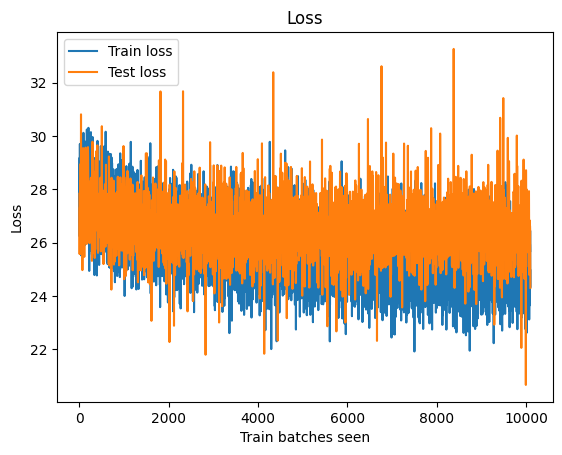

In [16]:
plt.plot(range(len(train_losses)), train_losses, label='Train loss')
ratio = int(len(train_losses) / len(test_losses))
plt.plot(np.linspace(0, len(train_losses), len(test_losses)), test_losses, label='Test loss')
plt.xlabel('Train batches seen')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()
plt.show()

In [17]:
data[0][0 : 20].shape

torch.Size([20, 14])

In [18]:
augments_per_sample = 3
augmented_data = []
model.eval()
for i in trange(data.shape[0]):
  for _ in range(augments_per_sample):
    augmented = data[i][0 : 20]
    while augmented.shape[0] < data.shape[1] + 20:
      past_values = augmented[-20:].reshape((1, 20, 14))
      past_time_features = torch.Tensor(range(augmented.shape[0] - 20, augmented.shape[0])).reshape(1, 20, 1)
      future_time_features = torch.Tensor(range(augmented.shape[0], augmented.shape[0] + 4)).reshape(1, 4, 1)
      past_observed_mask = torch.ones(past_values.shape)
      if i <= 83:
        static_categorical_features = torch.Tensor([1]).reshape((1, 1)).int()
      else:
        static_categorical_features = torch.Tensor([0]).reshape((1, 1)).int()
      gen = model.generate(
          past_values=past_values,
          past_time_features=past_time_features,
          future_time_features=future_time_features,
          past_observed_mask=past_observed_mask,
          static_categorical_features=static_categorical_features
      )["sequences"].reshape((4, 14))
      augmented = torch.cat((augmented, gen), dim=0)
    augmented = augmented[20:]
    augmented_data.append(augmented)

100%|██████████| 168/168 [04:26<00:00,  1.59s/it]


In [19]:
augmented_data[0].shape

torch.Size([120, 14])

In [20]:
augmented_data = torch.stack(augmented_data)

In [21]:
augmented_data.shape

torch.Size([504, 120, 14])

In [22]:
augmented_data = augmented_data.reshape((augmented_data.shape[0], 14, 120))
data = data.reshape((168, 14, 120))

In [23]:
torch.save(model.state_dict(), "aug_model_ihb.pt")

## IHB DTW

In [24]:
aug_to_origin = []
aug_to_others = []
aug_to_aug = []
for i in trange(augmented_data.shape[0]):
  for j in range(data.shape[0]):
    dist, _ = fastdtw(augmented_data[i], data[j])
    if j == i // augments_per_sample:
      aug_to_origin.append(dist)
    else:
      aug_to_others.append(dist)
  for j in range(i + 1, augmented_data.shape[0]):
    dist, _ = fastdtw(augmented_data[i], augmented_data[j])
    aug_to_aug.append(dist)

aug_to_origin = np.array(aug_to_origin)
aug_to_others = np.array(aug_to_others)
aug_to_aug = np.array(aug_to_aug)

100%|██████████| 504/504 [02:57<00:00,  2.85it/s]


In [25]:
pd.DataFrame(aug_to_origin).describe()

,0
count,504.000000
mean,3183.070615
std,698.461149
min,1998.302795
25%,2593.776939
50%,3113.291734
75%,3653.390941
max,5442.897311


In [26]:
pd.DataFrame(aug_to_others).describe()

,0
count,84168.000000
mean,3212.263595
std,553.979838
min,1839.530145
25%,2802.645895
50%,3174.997341
75%,3569.976941
max,5711.617559


In [27]:
pd.DataFrame(aug_to_aug).describe()

,0
count,126756.000000
mean,3112.378059
std,523.364271
min,1794.884841
25%,2721.600348
50%,3064.844734
75%,3458.315168
max,5625.559837


## IHB аугментированные

In [39]:
labels = [1] * (close.shape[1]) + [0] * (open.shape[1]) # 1 - closed, 0 - opened
labels = torch.tensor(labels).float()
aug_labels = [1] * (close.shape[1] * augments_per_sample) + [0] * (open.shape[1] * augments_per_sample) # 1 - closed, 0 - opened
aug_labels = torch.tensor(aug_labels).float()

In [42]:
train_losses_hist = []
test_losses_hist = []
train_accuracy_hist = []
test_accuracy_hist = []
train_roc_auc_hist = []
test_roc_auc_hist = []
val_losses_hist = []
aug_accuracy_on_real_hist = []
aug_roc_auc_on_real_hist = []

input_channels = close.shape[0]

for _ in range(n_experiments):
    for _, (train_index_orig, test_index_orig) in enumerate(kf.split(data, labels)):
      train_index = []
      for x in train_index_orig:
        train_index.append(3 * x)
        train_index.append(3 * x + 1)
        train_index.append(3 * x + 2)
      test_index = []
      for x in test_index_orig:
        test_index.append(3 * x)
        test_index.append(3 * x + 1)
        test_index.append(3 * x + 2)
      train_data = augmented_data[train_index]
      train_labels = aug_labels[train_index]
      test_data = augmented_data[test_index]
      test_labels = aug_labels[test_index]
      test_data_orig = data[test_index_orig]
      test_labels_orig = labels[test_index_orig]
      train_dataset = TensorDataset(train_data, train_labels)
      test_dataset = TensorDataset(test_data, test_labels)
      test_dataset_orig = TensorDataset(test_data_orig, test_labels_orig)
      train_dataset, val_dataset = train_test_split(train_dataset, test_size=0.3, random_state=33)
      aug_train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
      aug_test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
      aug_val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
      test_loader = DataLoader(test_dataset_orig, batch_size=batch_size, shuffle=True)

      train_losses = []
      test_losses = []
      train_accuracy = []
      test_accuracy = []
      train_roc_auc = []
      test_roc_auc = []
      val_losses = []
      aug_accuracy_on_real = []
      aug_roc_auc_on_real = []

      model = TimeSeriesCNN(input_channels)
      optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)
      aug_train(model)

      train_losses_hist.append(train_losses)
      test_losses_hist.append(test_losses)
      train_accuracy_hist.append(train_accuracy)
      test_accuracy_hist.append(test_accuracy)
      train_roc_auc_hist.append(train_roc_auc)
      test_roc_auc_hist.append(test_roc_auc)
      val_losses_hist.append(val_losses)
      aug_accuracy_on_real_hist.append(aug_accuracy_on_real)
      aug_roc_auc_on_real_hist.append(aug_roc_auc_on_real)

Epoch 1/25, Train loss: 55.8418, Test loss: 14.5403
Epoch 1/25, Train loss: 55.7861, Test loss: 14.6115
Epoch 1/25, Train loss: 55.8592, Test loss: 14.5427
Epoch 1/25, Train loss: 56.7506, Test loss: 13.7353
Epoch 1/25, Train loss: 58.2315, Test loss: 12.6616
Early stopping!

Epoch 1/25, Train loss: 56.0003, Test loss: 14.5639
Epoch 1/25, Train loss: 55.9117, Test loss: 13.9180
Epoch 1/25, Train loss: 56.4757, Test loss: 13.1200
Epoch 1/25, Train loss: 56.6584, Test loss: 14.6145
Early stopping!

Epoch 1/25, Train loss: 58.0979, Test loss: 13.6562
Epoch 1/25, Train loss: 56.0899, Test loss: 13.8316
Epoch 1/25, Train loss: 55.7311, Test loss: 14.6047
Epoch 1/25, Train loss: 56.0466, Test loss: 13.8535
Epoch 1/25, Train loss: 56.8333, Test loss: 14.5831
Epoch 1/25, Train loss: 58.0563, Test loss: 13.6413
Early stopping!



In [43]:
train_losses_np = np.array([lst + [0] * (num_epochs - len(lst)) for lst in train_losses_hist])
val_losses_np = np.array([lst + [0] * (num_epochs - len(lst)) for lst in val_losses_hist])
train_accuracy_np = np.array([lst + [0] * (num_epochs - len(lst)) for lst in train_accuracy_hist])
train_roc_auc_np = np.array([lst + [0] * (num_epochs - len(lst)) for lst in train_roc_auc_hist])
aug_accuracy_on_real_np = np.array([lst + [0] * (num_epochs - len(lst)) for lst in aug_accuracy_on_real_hist])
aug_roc_auc_on_real_np = np.array([lst + [0] * (num_epochs - len(lst)) for lst in aug_roc_auc_on_real_hist])

train_losses_np[train_losses_np == 0] = np.nan
val_losses_np[val_losses_np == 0] = np.nan
train_accuracy_np[train_accuracy_np == 0] = np.nan
train_roc_auc_np[train_roc_auc_np == 0] = np.nan
aug_accuracy_on_real_np[aug_accuracy_on_real_np == 0] = np.nan
aug_roc_auc_on_real_np[aug_roc_auc_on_real_np == 0] = np.nan

train_losses_mean = np.nanmean(train_losses_np, axis=0)
train_losses_std = np.nanstd(train_losses_np, axis=0)
val_losses_mean = np.nanmean(val_losses_np, axis=0)
val_losses_std = np.nanstd(val_losses_np, axis=0)
train_accuracy_mean = np.nanmean(train_accuracy_np, axis=0)
train_accuracy_std = np.nanstd(train_accuracy_np, axis=0)
train_roc_auc_mean = np.nanmean(train_roc_auc_np, axis=0)
train_roc_auc_std = np.nanstd(train_roc_auc_np, axis=0)
aug_accuracy_on_real_mean = np.nanmean(aug_accuracy_on_real_np, axis=0)
aug_accuracy_on_real_std = np.nanstd(aug_accuracy_on_real_np, axis=0)
aug_roc_auc_on_real_mean = np.nanmean(aug_roc_auc_on_real_np, axis=0)
aug_roc_auc_on_real_std = np.nanstd(aug_roc_auc_on_real_np, axis=0)

In [44]:
ihb_aug_acc_mean = np.max(aug_accuracy_on_real_mean)
ihb_aug_acc_std = aug_accuracy_on_real_std[np.argmax(aug_accuracy_on_real_mean)]
ihb_aug_roc_mean = np.max(aug_roc_auc_on_real_mean)
ihb_aug_roc_std = aug_roc_auc_on_real_std[np.argmax(aug_roc_auc_on_real_mean)]

In [45]:
ihb_aug_acc = aug_accuracy_on_real_np
ihb_aug_roc = aug_roc_auc_on_real_np

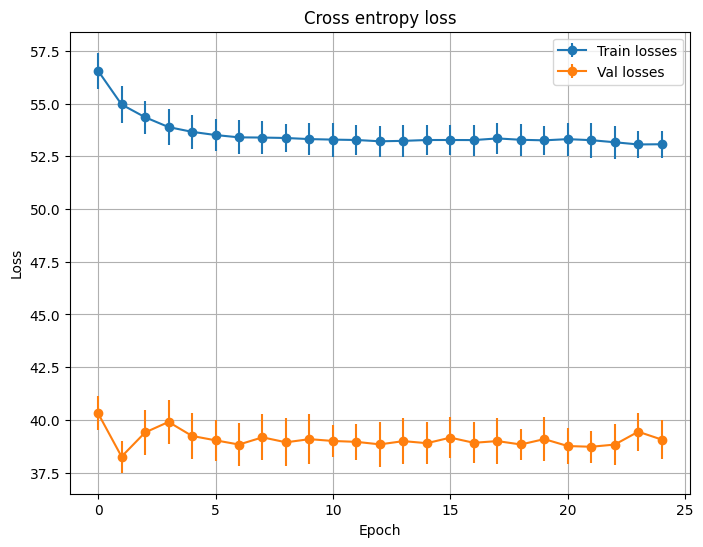

In [46]:
plt.figure(figsize=(8, 6))
plt.errorbar(range(train_losses_mean.shape[0]), train_losses_mean, yerr=train_losses_std, fmt='-o', label='Train losses')
plt.errorbar(range(val_losses_mean.shape[0]), val_losses_mean, yerr=val_losses_std, fmt='-o', label='Val losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Cross entropy loss')
plt.legend()
plt.grid(True)
plt.show()

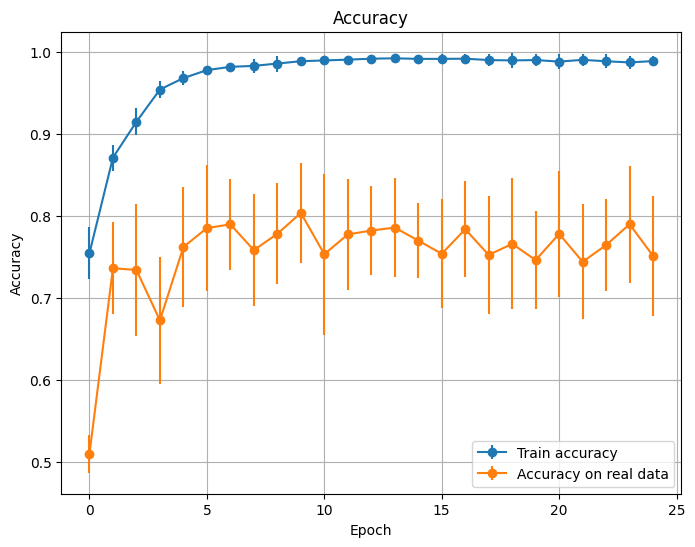

In [47]:
plt.figure(figsize=(8, 6))
plt.errorbar(range(train_accuracy_mean.shape[0]), train_accuracy_mean, yerr=train_accuracy_std, fmt='-o', label='Train accuracy')
plt.errorbar(range(aug_accuracy_on_real_mean.shape[0]), aug_accuracy_on_real_mean, yerr=aug_accuracy_on_real_std, fmt='-o', label='Accuracy on real data')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

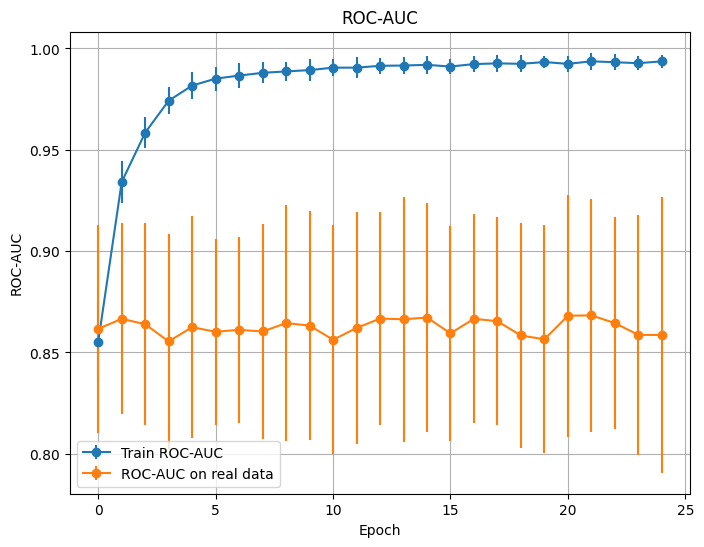

In [48]:
plt.figure(figsize=(8, 6))
plt.errorbar(range(train_roc_auc_mean.shape[0]), train_roc_auc_mean, yerr=train_roc_auc_std, fmt='-o', label='Train ROC-AUC')
plt.errorbar(range(aug_roc_auc_on_real_mean.shape[0]), aug_roc_auc_on_real_mean, yerr=aug_roc_auc_on_real_std, fmt='-o', label='ROC-AUC on real data')
plt.xlabel('Epoch')
plt.ylabel('ROC-AUC')
plt.title('ROC-AUC')
plt.legend()
plt.grid(True)
plt.show()

## IHB комбинированные

In [49]:
combined_data = torch.cat((data, augmented_data), axis=0)
combined_labels = [1] * (close.shape[1]) + [0] * (open.shape[1]) +\
 [1] * (close.shape[1] * augments_per_sample) + [0] * (open.shape[1] * augments_per_sample)
combined_labels = torch.tensor(combined_labels).float()

labels = [1] * (close.shape[1]) + [0] * (open.shape[1]) # 1 - closed, 0 - opened
labels = torch.tensor(labels).float()
aug_labels = [1] * (close.shape[1] * augments_per_sample) + [0] * (open.shape[1] * augments_per_sample) # 1 - closed, 0 - opened
aug_labels = torch.tensor(aug_labels).float()

In [50]:
train_losses_hist = []
test_losses_hist = []
train_accuracy_hist = []
test_accuracy_hist = []
train_roc_auc_hist = []
test_roc_auc_hist = []
val_losses_hist = []
aug_accuracy_on_real_hist = []
aug_roc_auc_on_real_hist = []

input_channels = close.shape[0]

for _ in range(n_experiments):
    for _, (train_index_orig, test_index_orig) in enumerate(kf.split(data, labels)):
      train_index = []
      for x in train_index_orig:
        train_index.append(3 * x)
        train_index.append(3 * x + 1)
        train_index.append(3 * x + 2)
      test_index = []
      for x in test_index_orig:
        test_index.append(3 * x)
        test_index.append(3 * x + 1)
        test_index.append(3 * x + 2)

      train_data = augmented_data[train_index]
      train_labels = aug_labels[train_index]
      train_data_orig = data[train_index_orig]
      train_labels_orig = labels[train_index_orig]

      train_comb = torch.cat((train_data, train_data_orig), axis=0)
      labels_comb = torch.cat((train_labels, train_labels_orig))
      train_dataset = TensorDataset(train_comb, labels_comb)

      test_data = augmented_data[test_index]
      test_labels = aug_labels[test_index]
      test_data_orig = data[test_index_orig]
      test_labels_orig = labels[test_index_orig]

      test_dataset = TensorDataset(test_data, test_labels)
      test_dataset_orig = TensorDataset(test_data_orig, test_labels_orig)

      train_dataset, val_dataset = train_test_split(train_dataset, test_size=0.3, random_state=33)
      aug_train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
      aug_test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
      aug_val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
      test_loader = DataLoader(test_dataset_orig, batch_size=batch_size, shuffle=True)

      train_losses = []
      test_losses = []
      train_accuracy = []
      test_accuracy = []
      train_roc_auc = []
      test_roc_auc = []
      val_losses = []
      aug_accuracy_on_real = []
      aug_roc_auc_on_real = []

      model = TimeSeriesCNN(input_channels)
      optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)
      aug_train(model)

      train_losses_hist.append(train_losses)
      test_losses_hist.append(test_losses)
      train_accuracy_hist.append(train_accuracy)
      test_accuracy_hist.append(test_accuracy)
      train_roc_auc_hist.append(train_roc_auc)
      test_roc_auc_hist.append(test_roc_auc)
      val_losses_hist.append(val_losses)
      aug_accuracy_on_real_hist.append(aug_accuracy_on_real)
      aug_roc_auc_on_real_hist.append(aug_roc_auc_on_real)

Epoch 1/25, Train loss: 53.4262, Test loss: 14.4625
Epoch 1/25, Train loss: 52.9663, Test loss: 13.1488
Epoch 1/25, Train loss: 53.2135, Test loss: 13.6758
Epoch 1/25, Train loss: 52.3693, Test loss: 14.4891
Epoch 1/25, Train loss: 53.3409, Test loss: 13.5808
Epoch 1/25, Train loss: 53.2227, Test loss: 14.4431
Epoch 1/25, Train loss: 53.2931, Test loss: 14.6708
Epoch 1/25, Train loss: 52.9826, Test loss: 14.5132
Epoch 1/25, Train loss: 52.2742, Test loss: 14.4704
Epoch 1/25, Train loss: 53.5212, Test loss: 12.6057
Epoch 1/25, Train loss: 53.1267, Test loss: 14.4638
Epoch 1/25, Train loss: 53.0154, Test loss: 14.6912
Epoch 1/25, Train loss: 53.1752, Test loss: 14.4207
Epoch 1/25, Train loss: 52.2950, Test loss: 13.6142
Epoch 1/25, Train loss: 53.4743, Test loss: 12.5873


In [51]:
train_losses_np = np.array([lst + [0] * (num_epochs - len(lst)) for lst in train_losses_hist])
test_losses_np = np.array([lst + [0] * (num_epochs - len(lst)) for lst in test_losses_hist])
val_losses_np = np.array([lst + [0] * (num_epochs - len(lst)) for lst in val_losses_hist])
train_accuracy_np = np.array([lst + [0] * (num_epochs - len(lst)) for lst in train_accuracy_hist])
test_accuracy_np = np.array([lst + [0] * (num_epochs - len(lst)) for lst in test_accuracy_hist])
train_roc_auc_np = np.array([lst + [0] * (num_epochs - len(lst)) for lst in train_roc_auc_hist])
test_roc_auc_np = np.array([lst + [0] * (num_epochs - len(lst)) for lst in test_roc_auc_hist])
aug_accuracy_on_real_np = np.array([lst + [0] * (num_epochs - len(lst)) for lst in aug_accuracy_on_real_hist])
aug_roc_auc_on_real_np = np.array([lst + [0] * (num_epochs - len(lst)) for lst in aug_roc_auc_on_real_hist])

train_losses_np[train_losses_np == 0] = np.nan
test_losses_np[test_losses_np == 0] = np.nan
val_losses_np[val_losses_np == 0] = np.nan
train_accuracy_np[train_accuracy_np == 0] = np.nan
test_accuracy_np[test_accuracy_np == 0] = np.nan
train_roc_auc_np[train_roc_auc_np == 0] = np.nan
test_roc_auc_np[test_roc_auc_np == 0] = np.nan
aug_accuracy_on_real_np[aug_accuracy_on_real_np == 0] = np.nan
aug_roc_auc_on_real_np[aug_roc_auc_on_real_np == 0] = np.nan

train_losses_mean = np.nanmean(train_losses_np, axis=0)
train_losses_std = np.nanstd(train_losses_np, axis=0)
test_losses_mean = np.nanmean(test_losses_np, axis=0)
test_losses_std = np.nanstd(test_losses_np, axis=0)
val_losses_mean = np.nanmean(val_losses_np, axis=0)
val_losses_std = np.nanstd(val_losses_np, axis=0)
train_accuracy_mean = np.nanmean(train_accuracy_np, axis=0)
train_accuracy_std = np.nanstd(train_accuracy_np, axis=0)
test_accuracy_mean = np.nanmean(test_accuracy_np, axis=0)
test_accuracy_std = np.nanstd(test_accuracy_np, axis=0)
train_roc_auc_mean = np.nanmean(train_roc_auc_np, axis=0)
train_roc_auc_std = np.nanstd(train_roc_auc_np, axis=0)
test_roc_auc_mean = np.nanmean(test_roc_auc_np, axis=0)
test_roc_auc_std = np.nanstd(test_roc_auc_np, axis=0)
aug_accuracy_on_real_mean = np.nanmean(aug_accuracy_on_real_np, axis=0)
aug_accuracy_on_real_std = np.nanstd(aug_accuracy_on_real_np, axis=0)
aug_roc_auc_on_real_mean = np.nanmean(aug_roc_auc_on_real_np, axis=0)
aug_roc_auc_on_real_std = np.nanstd(aug_roc_auc_on_real_np, axis=0)

In [52]:
ihb_comb_acc_mean = np.max(aug_accuracy_on_real_mean)
ihb_comb_acc_std = aug_accuracy_on_real_std[np.argmax(aug_accuracy_on_real_mean)]
ihb_comb_roc_mean = np.max(aug_roc_auc_on_real_mean)
ihb_comb_roc_std = aug_roc_auc_on_real_std[np.argmax(aug_roc_auc_on_real_mean)]

In [53]:
ihb_comb_acc = aug_accuracy_on_real_np
ihb_comb_roc = aug_roc_auc_on_real_np

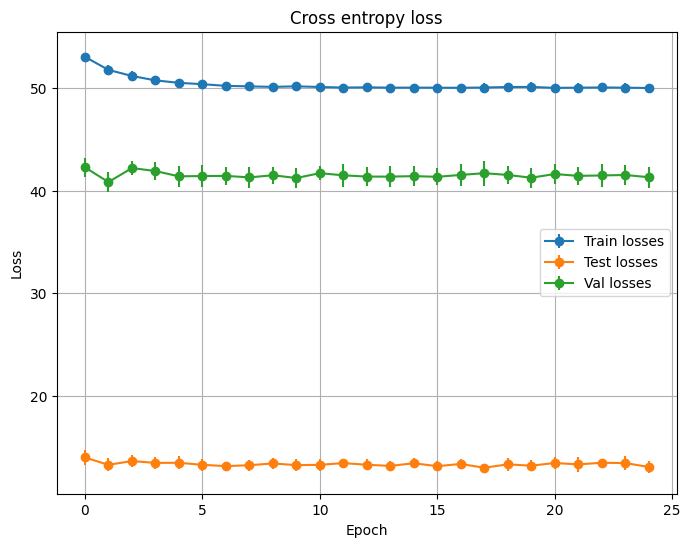

In [54]:
plt.figure(figsize=(8, 6))
plt.errorbar(range(train_losses_mean.shape[0]), train_losses_mean, yerr=train_losses_std, fmt='-o', label='Train losses')
plt.errorbar(range(test_losses_mean.shape[0]), test_losses_mean, yerr=test_losses_std, fmt='-o', label='Test losses')
plt.errorbar(range(val_losses_mean.shape[0]), val_losses_mean, yerr=val_losses_std, fmt='-o', label='Val losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Cross entropy loss')
plt.legend()
plt.grid(True)
plt.show()

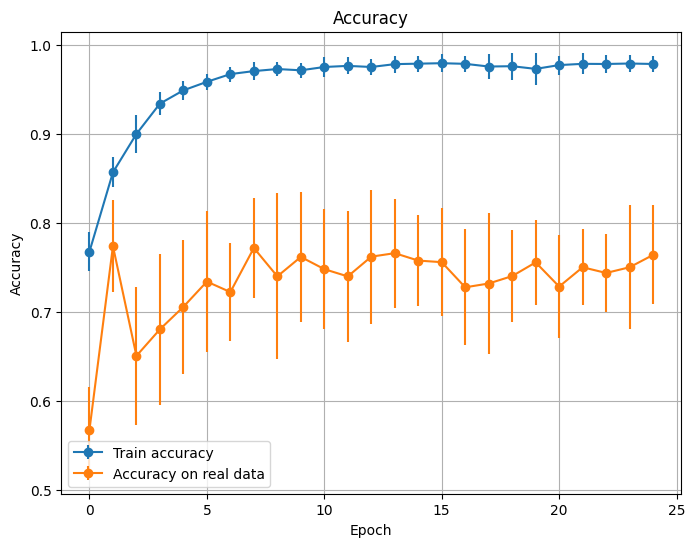

In [55]:
plt.figure(figsize=(8, 6))
plt.errorbar(range(train_accuracy_mean.shape[0]), train_accuracy_mean, yerr=train_accuracy_std, fmt='-o', label='Train accuracy')
#plt.errorbar(range(test_accuracy_mean.shape[0]), test_accuracy_mean, yerr=test_accuracy_std, fmt='-o', label='Test accuracy')
plt.errorbar(range(aug_accuracy_on_real_mean.shape[0]), aug_accuracy_on_real_mean, yerr=aug_accuracy_on_real_std, fmt='-o', label='Accuracy on real data')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

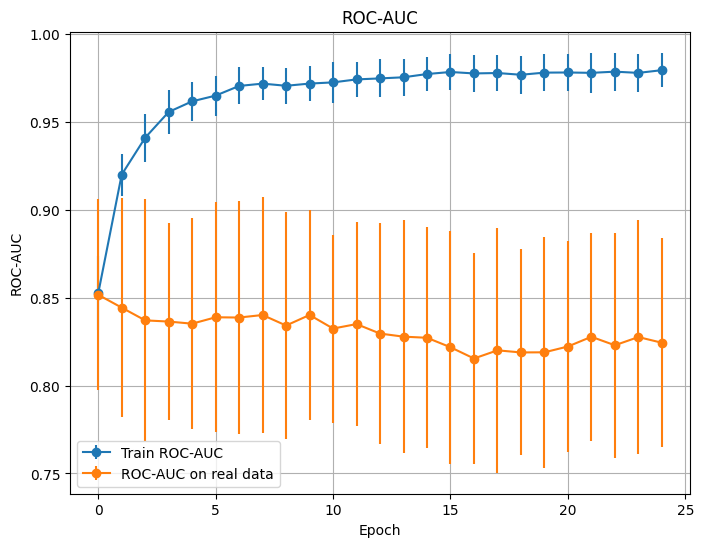

In [56]:
plt.figure(figsize=(8, 6))
plt.errorbar(range(train_roc_auc_mean.shape[0]), train_roc_auc_mean, yerr=train_roc_auc_std, fmt='-o', label='Train ROC-AUC')
#plt.errorbar(range(test_roc_auc_mean.shape[0]), test_roc_auc_mean, yerr=test_roc_auc_std, fmt='-o', label='Test ROC-AUC')
plt.errorbar(range(aug_roc_auc_on_real_mean.shape[0]), aug_roc_auc_on_real_mean, yerr=aug_roc_auc_on_real_std, fmt='-o', label='ROC-AUC on real data')
plt.xlabel('Epoch')
plt.ylabel('ROC-AUC')
plt.title('ROC-AUC')
plt.legend()
plt.grid(True)
plt.show()

## IHB корреляции

In [28]:
real_covs = []
for i in range(data.shape[0]):
  real_covs.append(np.cov(data[i]))
real_covs = np.array(real_covs)
real_covs_mean = np.mean(real_covs, axis=0)
real_covs_std = np.std(real_covs, axis=0)

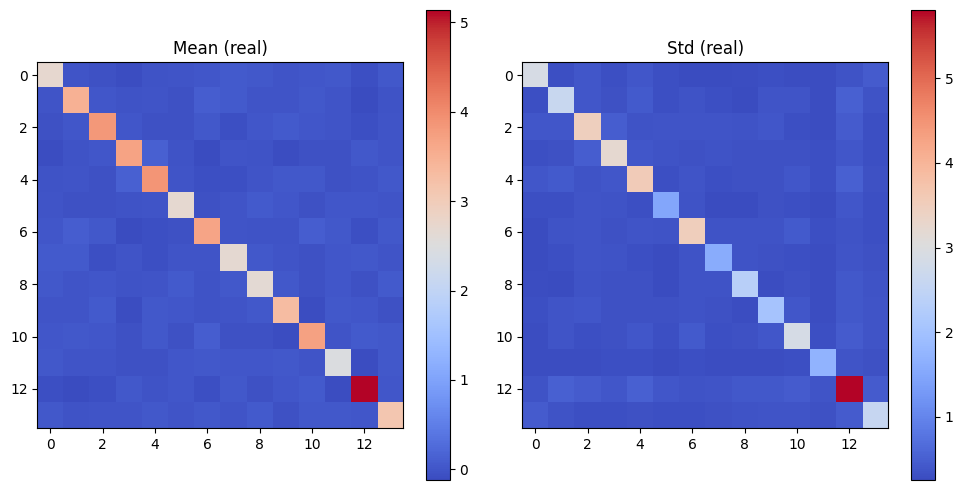

In [29]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(real_covs_mean, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.title('Mean (real)')
plt.subplot(1, 2, 2)
plt.imshow(real_covs_std, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.title('Std (real)')
plt.tight_layout()
plt.show()

In [30]:
aug_covs = []
for i in range(augmented_data.shape[0]):
  aug_covs.append(np.cov(augmented_data[i]))
aug_covs = np.array(aug_covs)
aug_covs_mean = np.mean(aug_covs, axis=0)
aug_covs_std = np.std(aug_covs, axis=0)

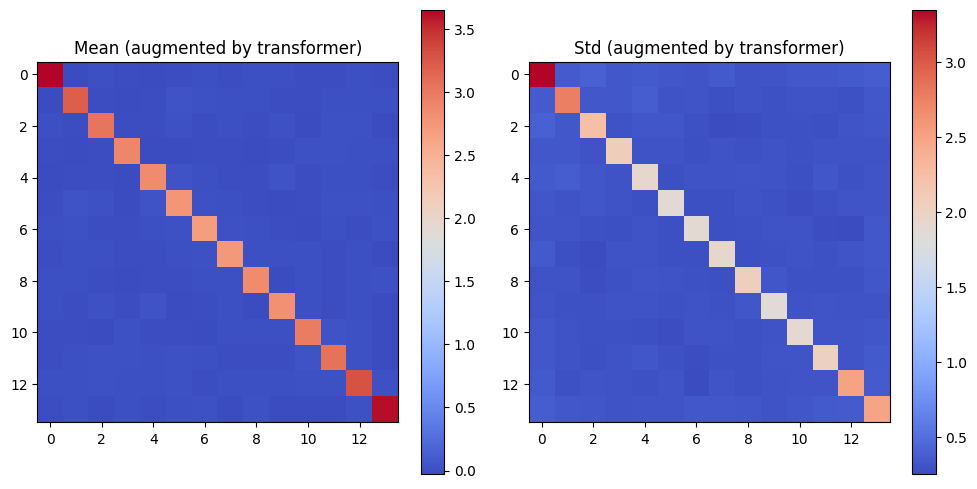

In [31]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(aug_covs_mean, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.title('Mean (augmented by transformer)')
plt.subplot(1, 2, 2)
plt.imshow(aug_covs_std, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.title('Std (augmented by transformer)')
plt.tight_layout()
plt.show()

In [32]:
np.cov(augmented_data[0])

array([[ 3.36571551,  0.53079896,  0.36826425, -0.25304351, -0.40982277,
        -0.27679408, -0.1521024 , -0.62710317, -0.39943472,  0.0218254 ,
         0.48860586, -0.54488923,  0.0779937 ,  0.01994972],
       [ 0.53079896,  2.14693768, -0.14178814, -0.2470089 , -0.35576582,
         0.08872124,  0.43224807,  0.16393021, -0.19440092, -0.18798087,
        -0.17252513, -0.32965019,  0.1188368 ,  0.4016331 ],
       [ 0.36826425, -0.14178814,  3.15675877, -0.05901232,  0.8760581 ,
         0.23143136, -0.04030833, -0.82903146, -0.04397056,  0.08082771,
        -0.20458832, -0.04599425,  0.03909982, -0.34627849],
       [-0.25304351, -0.2470089 , -0.05901232,  1.92179405,  0.0260348 ,
        -0.1788617 , -0.25060795,  0.27492709,  0.05670446, -0.37363527,
        -0.22332739,  0.01324255,  0.20606719, -0.29242241],
       [-0.40982277, -0.35576582,  0.8760581 ,  0.0260348 ,  5.13216638,
        -0.0562625 ,  0.53350613,  0.29977846, -0.19607621, -0.35695125,
        -0.82280266, -0.28

In [33]:
data[0][0]

tensor([-0.4803,  1.0940, -0.7105, -0.0807, -0.7828, -0.5216,  0.5371,  1.1424,
         0.9493,  0.8760,  0.2567, -1.0081,  1.2638, -2.2161,  0.9038, -0.6465,
        -0.8488, -1.4487,  0.4216, -1.3635, -0.6221,  0.3881,  1.6784,  1.2557,
         0.3032, -0.1435,  2.4474, -0.3172, -1.0139,  0.7320, -0.3412,  0.5779,
         2.0495, -3.4151, -2.7399, -1.0188,  1.0396, -2.4585, -0.2561,  2.6372,
         0.0079, -1.2256,  0.5668,  1.1194,  1.6485, -0.4568,  1.8026,  1.1568,
        -1.6193,  0.3756,  0.9513, -1.0215,  1.7195, -1.4506, -2.0007, -0.3285,
         2.3547, -1.1477, -0.2998, -0.6380,  1.0628,  0.4457,  1.0364, -0.2803,
        -0.9031,  0.2475, -0.4211, -0.1339, -1.4534,  0.8257, -1.6044,  0.1199,
         2.2471, -2.6073, -1.5695, -0.6435, -2.0095,  2.5635,  1.4295,  2.6192,
         0.4238,  0.1124, -1.1408,  0.2806,  1.6146, -0.4790, -0.3042, -0.2019,
        -1.2452, -1.9165,  1.5685,  0.3519,  0.0924,  0.7557, -2.6551,  1.4506,
        -0.1088,  0.7256,  0.4177,  1.71

In [34]:
augmented_data[0][0]

tensor([-2.6473,  1.9369, -1.6528, -1.1544,  3.0297, -3.1023,  1.7672,  1.2755,
        -0.4085,  1.9979,  0.3594,  0.7577, -1.6598, -1.2391, -1.9804, -2.2035,
        -2.3852, -0.8323, -0.1569,  1.1826,  1.6739,  5.4684, -1.0918,  1.3019,
         0.7955,  1.3454,  0.0462,  0.0281, -0.2820, -1.4287, -1.4727, -0.6812,
        -0.5850,  1.1603, -0.6867, -0.4786, -1.5560,  0.2761,  1.7920, -5.1573,
         0.9173,  3.7437, -3.4239, -0.3806, -0.0723, -1.6611, -3.0971, -4.8116,
         1.1394,  2.5357, -1.4202, -1.2851, -2.9764, -0.5175, -1.5277, -4.0426,
        -2.7898,  1.4846, -0.1955,  1.5112,  4.9727,  1.4163, -1.2889,  4.1039,
        -1.1220, -0.6829,  0.6200,  1.6830,  1.4801, -0.3801,  2.3101,  1.7742,
         2.9307,  1.0201,  1.1126, -0.7764, -1.7831, -1.3622,  0.6492, -1.4093,
         0.0517,  0.0723,  0.9075, -0.2418, -0.6395,  1.5980, -0.8577, -2.0375,
        -1.1080, -0.6358, -0.6083, -1.5397, -0.4600,  1.0586, -1.9299,  0.1065,
        -0.2935,  1.7395,  0.7423,  0.58

In [35]:
data[0][-1]

tensor([ 2.3016, -1.2230, -0.8874, -0.1380, -0.6380,  0.1753,  0.5139, -0.1110,
        -0.4594,  0.0157, -0.9636,  0.3652, -0.8277,  1.1812,  1.6649,  1.1471,
         0.7117,  0.2421, -0.0638, -2.6723,  0.7920,  2.0168, -0.3607, -1.5512,
         0.5764, -2.1977, -1.4214, -0.7517, -1.7585,  1.1737,  0.0860, -0.5023,
         1.2880,  1.2735, -0.2631, -0.2955,  0.8955,  1.1789, -0.1831,  1.2020,
         0.7384, -0.1647, -0.2440,  0.3021,  0.0995, -0.6080,  0.1063, -1.3122,
        -0.2840, -0.0763, -0.1881, -1.4851,  1.1662, -0.7962, -0.4993,  0.4507,
         0.3000, -0.2174, -0.8525, -0.9058,  1.1355,  2.5747, -0.9873,  1.3811,
         1.5456, -0.2177,  0.3155, -0.6790, -0.2385, -0.0820, -3.4308, -2.8210,
         1.2594,  3.3667,  0.6864, -0.1125, -1.3592, -0.2445,  0.6528,  1.3100,
        -0.2535, -0.6712, -0.7396, -1.2864,  1.1078, -0.3672,  0.1359, -1.0110,
         1.2535,  0.9762,  1.1664,  0.8745,  0.6008,  0.4244, -1.0124, -1.2541,
         0.9617,  0.4653, -1.2376,  0.48

In [36]:
data[0].shape

torch.Size([14, 120])

In [37]:
augmented_data[0][-1]

tensor([-0.3512, -0.1763,  0.3740,  1.1070,  0.3134, -0.7127, -1.6812,  0.8019,
         0.7461, -4.5891,  1.1600, -1.5309,  0.3730,  0.1938,  1.0006, -0.3233,
        -0.9819,  0.2637,  2.3138, -1.7685,  0.0199,  0.1280,  0.3432,  0.2609,
        -0.7672,  0.3627,  0.9734,  0.2549,  1.8586, -0.8345, -1.6618,  0.3097,
         0.8997,  0.1832, -1.6640, -1.3399, -1.9470, -1.6099, -0.3033, -0.5302,
        -3.3107,  1.6407, -0.0317, -2.0748, -0.8212,  1.9586,  1.6317,  0.1294,
         0.9336,  1.2111,  0.8875, -0.0994, -1.7164,  0.7046, -0.4714, -0.7715,
         2.2966,  2.5199,  3.4559,  2.5245, -0.7256,  0.0148, -1.6790, -0.1881,
        -1.0931, -2.4968, -1.1825, -0.9195,  0.9195,  0.4284, -2.6391,  1.6368,
        -1.2492, -1.4046,  1.4118,  0.8175, -0.6402, -3.1968, -0.3287, -2.3824,
         0.4985,  1.5405,  1.7276, -0.1160, -0.5865,  2.1628, -0.1463, -2.4750,
         2.2346, -0.5853,  0.9241,  0.9302, -2.2913, -1.8530,  0.0712,  1.1574,
         0.8634,  0.2485,  0.6492, -0.96

## China настоящие

In [57]:
open = np.load("/content/drive/MyDrive/china_open_mean_ts_by_network_HCPex.npy")
close = np.load("/content/drive/MyDrive/china_close_mean_ts_by_network_HCPex.npy")

In [58]:
open.shape, close.shape # [networks, eyes, time]

((14, 47, 240), (14, 95, 240))

In [59]:
data = np.concatenate((close, open), axis=1)
data = torch.tensor(data).float()
data = data.reshape((142, 14, 240))

labels = [1] * close.shape[1] + [0] * open.shape[1] # 1 - closed, 0 - opened
labels = torch.tensor(labels).float()

In [65]:
for _, (train_index, test_index) in enumerate(kf.split(data, labels)):
  train_data = data[train_index]
  train_labels = labels[train_index]
  test_data = data[test_index]
  test_labels = labels[test_index]
  train_dataset = TensorDataset(train_data, train_labels)
  test_dataset = TensorDataset(test_data, test_labels)
  train_dataset, val_dataset = train_test_split(train_dataset, test_size=0.3, random_state=33)
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
  val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [66]:
train_losses_hist = []
test_losses_hist = []
train_accuracy_hist = []
test_accuracy_hist = []
train_roc_auc_hist = []
test_roc_auc_hist = []
val_losses_hist = []

input_channels = close.shape[0]

for _ in range(n_experiments):
    for _, (train_index, test_index) in enumerate(kf.split(data, labels)):
      train_data = data[train_index]
      train_labels = labels[train_index]
      test_data = data[test_index]
      test_labels = labels[test_index]
      train_dataset = TensorDataset(train_data, train_labels)
      test_dataset = TensorDataset(test_data, test_labels)
      train_dataset, val_dataset = train_test_split(train_dataset, test_size=0.3, random_state=33)
      train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
      test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
      val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

      train_losses = []
      test_losses = []
      train_accuracy = []
      test_accuracy = []
      train_roc_auc = []
      test_roc_auc = []
      val_losses = []

      model = TimeSeriesCNN(input_channels, conv_output_size=2912)
      criterion = nn.CrossEntropyLoss()
      optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)
      train(model)

      train_losses_hist.append(train_losses)
      test_losses_hist.append(test_losses)
      train_accuracy_hist.append(train_accuracy)
      test_accuracy_hist.append(test_accuracy)
      train_roc_auc_hist.append(train_roc_auc)
      test_roc_auc_hist.append(test_roc_auc)
      val_losses_hist.append(val_losses)

Epoch 1/25, Train loss: 60.4466, Test loss: 63.9169
Epoch 1/25, Train loss: 60.4730, Test loss: 63.9678
Epoch 1/25, Train loss: 59.9143, Test loss: 63.3331
Early stopping!

Epoch 1/25, Train loss: 60.3973, Test loss: 63.2450
Epoch 1/25, Train loss: 59.7786, Test loss: 63.2715
Early stopping!

Epoch 1/25, Train loss: 60.7420, Test loss: 63.9383
Epoch 1/25, Train loss: 61.3677, Test loss: 63.9582
Epoch 1/25, Train loss: 59.7294, Test loss: 63.2272
Epoch 1/25, Train loss: 59.9524, Test loss: 63.2500
Epoch 1/25, Train loss: 59.6405, Test loss: 63.2529
Early stopping!



In [67]:
train_losses_np = np.array([lst + [0] * (num_epochs - len(lst)) for lst in train_losses_hist])
test_losses_np = np.array([lst + [0] * (num_epochs - len(lst)) for lst in test_losses_hist])
val_losses_np = np.array([lst + [0] * (num_epochs - len(lst)) for lst in val_losses_hist])
train_accuracy_np = np.array([lst + [0] * (num_epochs - len(lst)) for lst in train_accuracy_hist])
test_accuracy_np = np.array([lst + [0] * (num_epochs - len(lst)) for lst in test_accuracy_hist])
train_roc_auc_np = np.array([lst + [0] * (num_epochs - len(lst)) for lst in train_roc_auc_hist])
test_roc_auc_np = np.array([lst + [0] * (num_epochs - len(lst)) for lst in test_roc_auc_hist])

train_losses_np[train_losses_np == 0] = np.nan
test_losses_np[test_losses_np == 0] = np.nan
val_losses_np[val_losses_np == 0] = np.nan
train_accuracy_np[train_accuracy_np == 0] = np.nan
test_accuracy_np[test_accuracy_np == 0] = np.nan
train_roc_auc_np[train_roc_auc_np == 0] = np.nan
test_roc_auc_np[test_roc_auc_np == 0] = np.nan

train_losses_mean = np.nanmean(train_losses_np, axis=0)
train_losses_std = np.nanstd(train_losses_np, axis=0)
test_losses_mean = np.nanmean(test_losses_np, axis=0)
test_losses_std = np.nanstd(test_losses_np, axis=0)
val_losses_mean = np.nanmean(val_losses_np, axis=0)
val_losses_std = np.nanstd(val_losses_np, axis=0)
train_accuracy_mean = np.nanmean(train_accuracy_np, axis=0)
train_accuracy_std = np.nanstd(train_accuracy_np, axis=0)
test_accuracy_mean = np.nanmean(test_accuracy_np, axis=0)
test_accuracy_std = np.nanstd(test_accuracy_np, axis=0)
train_roc_auc_mean = np.nanmean(train_roc_auc_np, axis=0)
train_roc_auc_std = np.nanstd(train_roc_auc_np, axis=0)
test_roc_auc_mean = np.nanmean(test_roc_auc_np, axis=0)
test_roc_auc_std = np.nanstd(test_roc_auc_np, axis=0)

In [68]:
china_real_acc_mean = np.max(test_accuracy_mean)
china_real_acc_std = test_accuracy_std[np.argmax(test_accuracy_mean)]
china_real_roc_mean = np.max(test_roc_auc_mean)
china_real_roc_std = test_roc_auc_std[np.argmax(test_roc_auc_mean)]

In [69]:
china_real_acc = test_accuracy_np
china_real_roc = test_roc_auc_np

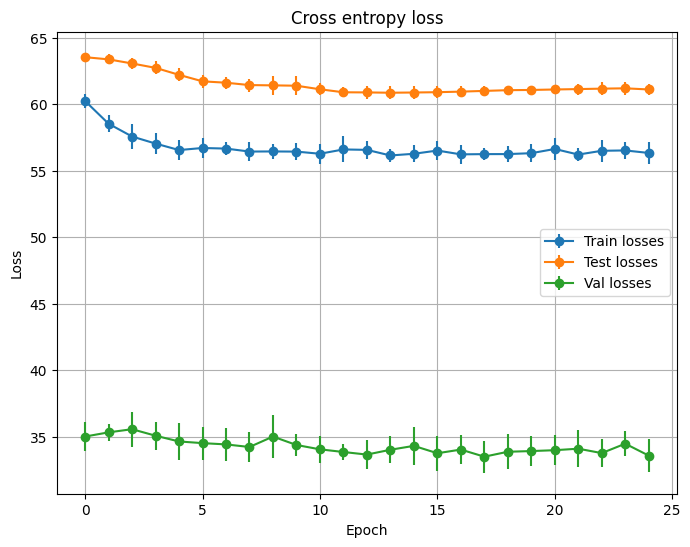

In [70]:
plt.figure(figsize=(8, 6))
plt.errorbar(range(train_losses_mean.shape[0]), train_losses_mean, yerr=train_losses_std, fmt='-o', label='Train losses')
plt.errorbar(range(test_losses_mean.shape[0]), test_losses_mean, yerr=test_losses_std, fmt='-o', label='Test losses')
plt.errorbar(range(val_losses_mean.shape[0]), val_losses_mean, yerr=val_losses_std, fmt='-o', label='Val losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Cross entropy loss')
plt.legend()
plt.grid(True)
plt.show()

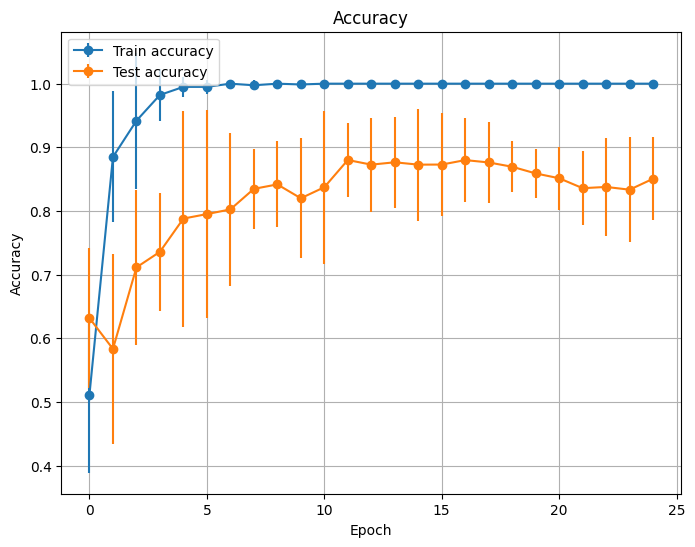

In [71]:
plt.figure(figsize=(8, 6))
plt.errorbar(range(train_accuracy_mean.shape[0]), train_accuracy_mean, yerr=train_accuracy_std, fmt='-o', label='Train accuracy')
plt.errorbar(range(test_accuracy_mean.shape[0]), test_accuracy_mean, yerr=test_accuracy_std, fmt='-o', label='Test accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

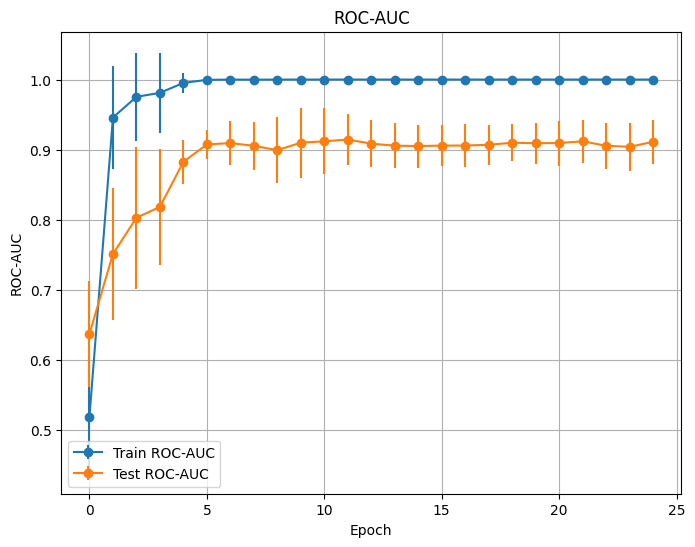

In [72]:
plt.figure(figsize=(8, 6))
plt.errorbar(range(train_roc_auc_mean.shape[0]), train_roc_auc_mean, yerr=train_roc_auc_std, fmt='-o', label='Train ROC-AUC')
plt.errorbar(range(test_roc_auc_mean.shape[0]), test_roc_auc_mean, yerr=test_roc_auc_std, fmt='-o', label='Test ROC-AUC')
plt.xlabel('Epoch')
plt.ylabel('ROC-AUC')
plt.title('ROC-AUC')
plt.legend()
plt.grid(True)
plt.show()

## China аугментация

In [60]:
data = data.reshape((142, 240, 14))

In [61]:
past_values = []
future_values = []
past_time_features = []
future_time_features = []
static_categorical_features = []
for i in range(data.shape[0]):
  start = 0
  while start + 24 < data[i].shape[0]:
    past_values.append(data[i][start : start+20])
    future_values.append(data[i][start+20 : start+24])
    past_time_features.append(range(start, start+20))
    future_time_features.append(range(start+20, start+24))
    static_categorical_features.append(1 - (i // (data.shape[0] // 2)))
    start += 4
past_values = torch.stack(past_values)
future_values = torch.stack(future_values)
past_time_features = torch.Tensor(past_time_features)
future_time_features = torch.Tensor(future_time_features)
past_time_features = past_time_features.reshape((past_time_features.shape[0], past_time_features.shape[1], 1))
future_time_features = future_time_features.reshape((future_time_features.shape[0], future_time_features.shape[1], 1))
past_observed_mask = torch.ones(past_values.shape)
static_categorical_features = torch.Tensor(static_categorical_features).int()

In [62]:
n = past_values.shape[0]
test_size = 0.2
test_idx = np.random.choice(range(n), size=int(test_size * n), replace=False)
train_idx = np.setdiff1d(range(n), test_idx)
train_past_values = past_values[train_idx]
test_past_values = past_values[test_idx]
train_future_values = future_values[train_idx]
test_future_values = future_values[test_idx]
train_past_time_features = past_time_features[train_idx]
test_past_time_features = past_time_features[test_idx]
train_future_time_features = future_time_features[train_idx]
test_future_time_features = future_time_features[test_idx]
train_past_observed_mask = past_observed_mask[train_idx]
test_past_observed_mask = past_observed_mask[test_idx]
train_static_categorical_features = static_categorical_features[train_idx]
test_static_categorical_features = static_categorical_features[test_idx]

In [63]:
train_dataset = []
for i in range(train_past_values.shape[0]):
    train_dataset.append({
        "past_values": train_past_values[i],
        "future_values": train_future_values[i],
        "past_time_features": train_past_time_features[i],
        "future_time_features": train_future_time_features[i],
        "past_observed_mask": train_past_observed_mask[i],
        "static_categorical_features": train_static_categorical_features[i]
    })

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = []
for i in range(test_past_values.shape[0]):
    test_dataset.append({
        "past_values": test_past_values[i],
        "future_values": test_future_values[i],
        "past_time_features": test_past_time_features[i],
        "future_time_features": test_future_time_features[i],
        "past_observed_mask": test_past_observed_mask[i],
        "static_categorical_features": test_static_categorical_features[i]
    })

test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [64]:
lags_sequence = [1, 2, 3, 4, 5, 6, 7]
configuration = TimeSeriesTransformerConfig(prediction_length=4, context_length=20 - len(lags_sequence), input_size=14,
                                            num_time_features=1, lags_sequence=lags_sequence, num_parallel_samples=1,
                                            num_static_categorical_features=1, cardinality=[2], embedding_dimension=[1])
model = TimeSeriesTransformerForPrediction(configuration)
optimizer = torch.optim.AdamW(model.parameters(), lr=6e-4, betas=(0.9, 0.95), weight_decay=1e-1)

In [65]:
n_epochs = 100
print_every = 10
train_losses = []
test_losses = []
for epoch in range(n_epochs):
    for idx, batch in enumerate(train_dataloader):
        model.train()
        optimizer.zero_grad()

        loss = model(
            past_values=batch["past_values"],
            future_values=batch["future_values"],
            past_time_features=batch["past_time_features"],
            future_time_features=batch["future_time_features"],
            past_observed_mask=batch["past_observed_mask"],
            static_categorical_features=batch["static_categorical_features"].reshape((batch["static_categorical_features"].shape[0], 1))
        ).loss
        loss.backward()
        train_losses.append(loss.item())

        optimizer.step()

        if epoch % print_every == 0 and idx == 0:
            print("Epoch: ", epoch, ", Train loss: ", loss.item(), end="", sep="")

    for idx, batch in enumerate(test_dataloader):
        model.eval()
        loss = model(
            past_values=batch["past_values"],
            future_values=batch["future_values"],
            past_time_features=batch["past_time_features"],
            future_time_features=batch["future_time_features"],
            past_observed_mask=batch["past_observed_mask"],
            static_categorical_features=batch["static_categorical_features"].reshape((batch["static_categorical_features"].shape[0], 1))
        ).loss
        test_losses.append(loss.item())
        if epoch % print_every == 0 and idx == 0:
            print(", Test loss:", loss.item())


Epoch: 0, Train loss: 24.431915283203125, Test loss: 23.855398178100586
Epoch: 10, Train loss: 23.517370223999023, Test loss: 24.661983489990234
Epoch: 20, Train loss: 23.05563735961914, Test loss: 24.96080780029297
Epoch: 30, Train loss: 24.543468475341797, Test loss: 24.682762145996094
Epoch: 40, Train loss: 25.594419479370117, Test loss: 23.890810012817383
Epoch: 50, Train loss: 22.44422149658203, Test loss: 24.121601104736328
Epoch: 60, Train loss: 23.40611457824707, Test loss: 24.359813690185547
Epoch: 70, Train loss: 23.344505310058594, Test loss: 24.304563522338867
Epoch: 80, Train loss: 22.2805233001709, Test loss: 23.165002822875977
Epoch: 90, Train loss: 23.841022491455078, Test loss: 25.425291061401367


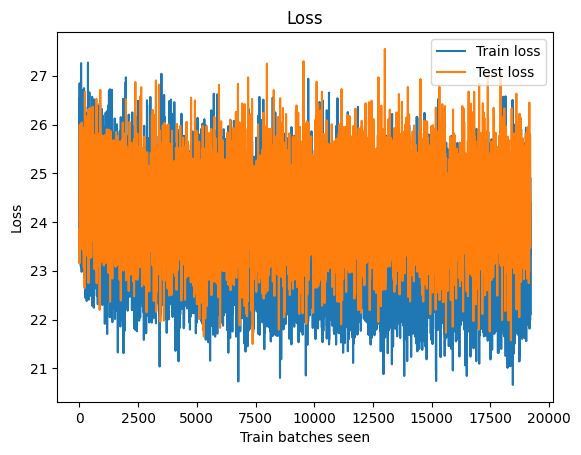

In [66]:
plt.plot(range(len(train_losses)), train_losses, label='Train loss')
ratio = int(len(train_losses) / len(test_losses))
plt.plot(np.linspace(0, len(train_losses), len(test_losses)), test_losses, label='Test loss')
plt.xlabel('Train batches seen')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()
plt.show()

In [68]:
augmented_data = []
model.eval()
for i in trange(data.shape[0]):
  for _ in range(augments_per_sample):
    augmented = data[i][0 : 20]
    while augmented.shape[0] < 260:
      past_values = augmented[-20:].reshape((1, 20, 14))
      past_time_features = torch.Tensor(range(augmented.shape[0] - 20, augmented.shape[0])).reshape(1, 20, 1)
      future_time_features = torch.Tensor(range(augmented.shape[0], augmented.shape[0] + 4)).reshape(1, 4, 1)
      past_observed_mask = torch.ones(past_values.shape)
      if i < 95:
        static_categorical_features = torch.Tensor([1]).reshape((1, 1)).int()
      else:
        static_categorical_features = torch.Tensor([0]).reshape((1, 1)).int()
      gen = model.generate(
          past_values=past_values,
          past_time_features=past_time_features,
          future_time_features=future_time_features,
          past_observed_mask=past_observed_mask,
          static_categorical_features=static_categorical_features
      )["sequences"].reshape((4, 14))
      augmented = torch.cat((augmented, gen), dim=0)
    augmented = augmented[20:]
    augmented_data.append(augmented)

100%|██████████| 142/142 [08:38<00:00,  3.65s/it]


In [69]:
augmented_data = torch.stack(augmented_data)

In [70]:
augmented_data = augmented_data.reshape((augmented_data.shape[0], 14, 240))
data = data.reshape((142, 14, 240))

In [71]:
torch.save(model.state_dict(), "aug_model_china.pt")

## China DTW

In [83]:
aug_to_origin = []
aug_to_others = []
aug_to_aug = []
for i in trange(augmented_data.shape[0]):
  for j in range(data.shape[0]):
    dist, _ = fastdtw(augmented_data[i], data[j])
    if j == i // augments_per_sample:
      aug_to_origin.append(dist)
    else:
      aug_to_others.append(dist)
  for j in range(i + 1, augmented_data.shape[0]):
    dist, _ = fastdtw(augmented_data[i], augmented_data[j])
    aug_to_aug.append(dist)

aug_to_origin = np.array(aug_to_origin)
aug_to_others = np.array(aug_to_others)
aug_to_aug = np.array(aug_to_aug)

100%|██████████| 426/426 [03:55<00:00,  1.81it/s]


In [84]:
pd.DataFrame(aug_to_origin).describe()

,0
count,426.000000
mean,5844.410585
std,923.390854
min,3660.752858
25%,5120.929042
50%,5742.089026
75%,6442.674156
max,8705.442964


In [85]:
pd.DataFrame(aug_to_others).describe()

,0
count,60066.000000
mean,6296.746919
std,898.429403
min,3811.537987
25%,5629.748964
50%,6209.289807
75%,6889.738899
max,10190.249057


In [86]:
pd.DataFrame(aug_to_aug).describe()

,0
count,90525.000000
mean,7044.932463
std,850.840918
min,4096.386253
25%,6447.423337
50%,6977.778905
75%,7564.856503
max,11467.636339


## China аугментированные

In [76]:
labels = [1] * (close.shape[1]) + [0] * (open.shape[1]) # 1 - closed, 0 - opened
labels = torch.tensor(labels).float()
aug_labels = [1] * (close.shape[1] * augments_per_sample) + [0] * (open.shape[1] * augments_per_sample) # 1 - closed, 0 - opened
aug_labels = torch.tensor(aug_labels).float()

In [77]:
#augmented_dataset = TensorDataset(augmented_data, labels)
#aug_train_dataset, aug_test_dataset = train_test_split(augmented_dataset, test_size=0.3, random_state=44)
#aug_train_dataset, aug_val_dataset = train_test_split(aug_train_dataset, test_size=0.3, random_state=44)

In [78]:
train_losses_hist = []
test_losses_hist = []
train_accuracy_hist = []
test_accuracy_hist = []
train_roc_auc_hist = []
test_roc_auc_hist = []
val_losses_hist = []
aug_accuracy_on_real_hist = []
aug_roc_auc_on_real_hist = []

input_channels = close.shape[0]

for _ in range(n_experiments):
    for _, (train_index_orig, test_index_orig) in enumerate(kf.split(data, labels)):
      train_index = []
      for x in train_index_orig:
        train_index.append(3 * x)
        train_index.append(3 * x + 1)
        train_index.append(3 * x + 2)
      test_index = []
      for x in test_index_orig:
        test_index.append(3 * x)
        test_index.append(3 * x + 1)
        test_index.append(3 * x + 2)
      train_data = augmented_data[train_index]
      train_labels = aug_labels[train_index]
      test_data = augmented_data[test_index]
      test_labels = aug_labels[test_index]
      test_data_orig = data[test_index_orig]
      test_labels_orig = labels[test_index_orig]
      train_dataset = TensorDataset(train_data, train_labels)
      test_dataset = TensorDataset(test_data, test_labels)
      test_dataset_orig = TensorDataset(test_data_orig, test_labels_orig)
      train_dataset, val_dataset = train_test_split(train_dataset, test_size=0.3, random_state=33)
      aug_train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
      aug_test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
      aug_val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
      test_loader = DataLoader(test_dataset_orig, batch_size=batch_size, shuffle=True)

      train_losses = []
      test_losses = []
      train_accuracy = []
      test_accuracy = []
      train_roc_auc = []
      test_roc_auc = []
      val_losses = []
      aug_accuracy_on_real = []
      aug_roc_auc_on_real = []

      model = TimeSeriesCNN(input_channels, conv_output_size=2912)
      optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)
      aug_train(model)

      train_losses_hist.append(train_losses)
      test_losses_hist.append(test_losses)
      train_accuracy_hist.append(train_accuracy)
      test_accuracy_hist.append(test_accuracy)
      train_roc_auc_hist.append(train_roc_auc)
      test_roc_auc_hist.append(test_roc_auc)
      val_losses_hist.append(val_losses)
      aug_accuracy_on_real_hist.append(aug_accuracy_on_real)
      aug_roc_auc_on_real_hist.append(aug_roc_auc_on_real)

Epoch 1/25, Train loss: 72.1441, Test loss: 21.3548
Epoch 1/25, Train loss: 72.2292, Test loss: 21.3452
Epoch 1/25, Train loss: 69.5797, Test loss: 21.0533
Early stopping!

Epoch 1/25, Train loss: 69.3831, Test loss: 21.1091
Epoch 1/25, Train loss: 69.0985, Test loss: 21.1219
Early stopping!

Epoch 1/25, Train loss: 72.0871, Test loss: 21.3391
Early stopping!

Epoch 1/25, Train loss: 72.0710, Test loss: 21.3413
Epoch 1/25, Train loss: 69.2505, Test loss: 21.1041
Epoch 1/25, Train loss: 69.4731, Test loss: 21.1066
Early stopping!

Epoch 1/25, Train loss: 69.1533, Test loss: 21.1223
Epoch 1/25, Train loss: 72.4914, Test loss: 21.3961
Epoch 1/25, Train loss: 72.3305, Test loss: 21.3719
Epoch 1/25, Train loss: 69.3018, Test loss: 21.1343
Epoch 1/25, Train loss: 69.4986, Test loss: 21.0967
Epoch 1/25, Train loss: 69.3298, Test loss: 21.1075


In [79]:
train_losses_np = np.array([lst + [0] * (num_epochs - len(lst)) for lst in train_losses_hist])
val_losses_np = np.array([lst + [0] * (num_epochs - len(lst)) for lst in val_losses_hist])
train_accuracy_np = np.array([lst + [0] * (num_epochs - len(lst)) for lst in train_accuracy_hist])
train_roc_auc_np = np.array([lst + [0] * (num_epochs - len(lst)) for lst in train_roc_auc_hist])
aug_accuracy_on_real_np = np.array([lst + [0] * (num_epochs - len(lst)) for lst in aug_accuracy_on_real_hist])
aug_roc_auc_on_real_np = np.array([lst + [0] * (num_epochs - len(lst)) for lst in aug_roc_auc_on_real_hist])

train_losses_np[train_losses_np == 0] = np.nan
val_losses_np[val_losses_np == 0] = np.nan
train_accuracy_np[train_accuracy_np == 0] = np.nan
train_roc_auc_np[train_roc_auc_np == 0] = np.nan
aug_accuracy_on_real_np[aug_accuracy_on_real_np == 0] = np.nan
aug_roc_auc_on_real_np[aug_roc_auc_on_real_np == 0] = np.nan

train_losses_mean = np.nanmean(train_losses_np, axis=0)
train_losses_std = np.nanstd(train_losses_np, axis=0)
val_losses_mean = np.nanmean(val_losses_np, axis=0)
val_losses_std = np.nanstd(val_losses_np, axis=0)
train_accuracy_mean = np.nanmean(train_accuracy_np, axis=0)
train_accuracy_std = np.nanstd(train_accuracy_np, axis=0)
train_roc_auc_mean = np.nanmean(train_roc_auc_np, axis=0)
train_roc_auc_std = np.nanstd(train_roc_auc_np, axis=0)
aug_accuracy_on_real_mean = np.nanmean(aug_accuracy_on_real_np, axis=0)
aug_accuracy_on_real_std = np.nanstd(aug_accuracy_on_real_np, axis=0)
aug_roc_auc_on_real_mean = np.nanmean(aug_roc_auc_on_real_np, axis=0)
aug_roc_auc_on_real_std = np.nanstd(aug_roc_auc_on_real_np, axis=0)

In [80]:
aug_accuracy_on_real_mean = aug_accuracy_on_real_mean[~np.isnan(aug_accuracy_on_real_mean)]
aug_accuracy_on_real_std = aug_accuracy_on_real_std[~np.isnan(aug_accuracy_on_real_std)]
aug_roc_auc_on_real_mean = aug_roc_auc_on_real_mean[~np.isnan(aug_roc_auc_on_real_mean)]
aug_roc_auc_on_real_std = aug_roc_auc_on_real_std[~np.isnan(aug_roc_auc_on_real_std)]
china_aug_acc_mean = np.max(aug_accuracy_on_real_mean)
china_aug_acc_std = aug_accuracy_on_real_std[np.argmax(aug_accuracy_on_real_mean)]
china_aug_roc_mean = np.max(aug_roc_auc_on_real_mean)
china_aug_roc_std = aug_roc_auc_on_real_std[np.argmax(aug_roc_auc_on_real_mean)]

In [81]:
china_aug_acc = aug_accuracy_on_real_np
china_aug_roc = aug_roc_auc_on_real_np

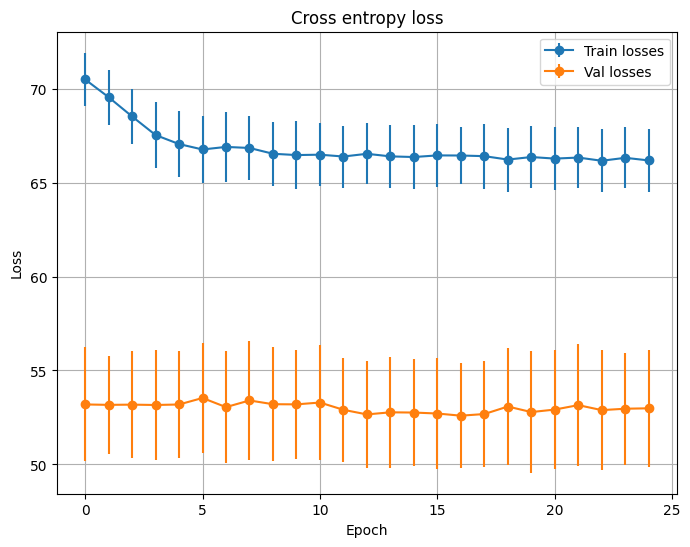

In [82]:
plt.figure(figsize=(8, 6))
plt.errorbar(range(train_losses_mean.shape[0]), train_losses_mean, yerr=train_losses_std, fmt='-o', label='Train losses')
plt.errorbar(range(val_losses_mean.shape[0]), val_losses_mean, yerr=val_losses_std, fmt='-o', label='Val losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Cross entropy loss')
plt.legend()
plt.grid(True)
plt.show()

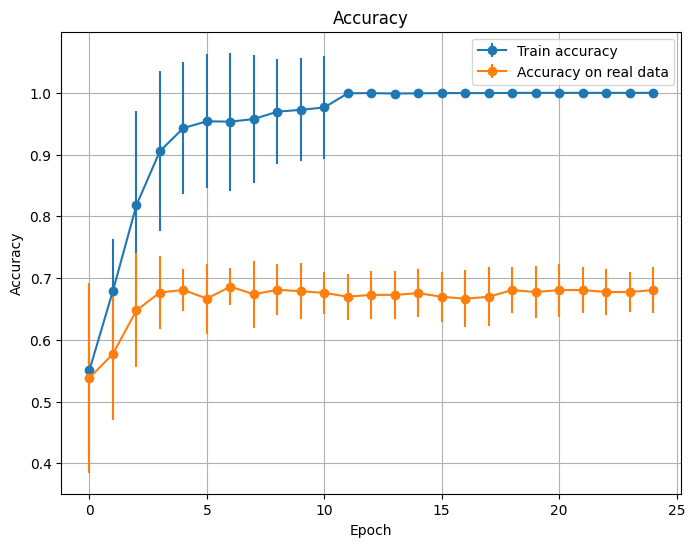

In [83]:
plt.figure(figsize=(8, 6))
plt.errorbar(range(train_accuracy_mean.shape[0]), train_accuracy_mean, yerr=train_accuracy_std, fmt='-o', label='Train accuracy')
plt.errorbar(range(aug_accuracy_on_real_mean.shape[0]), aug_accuracy_on_real_mean, yerr=aug_accuracy_on_real_std, fmt='-o', label='Accuracy on real data')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

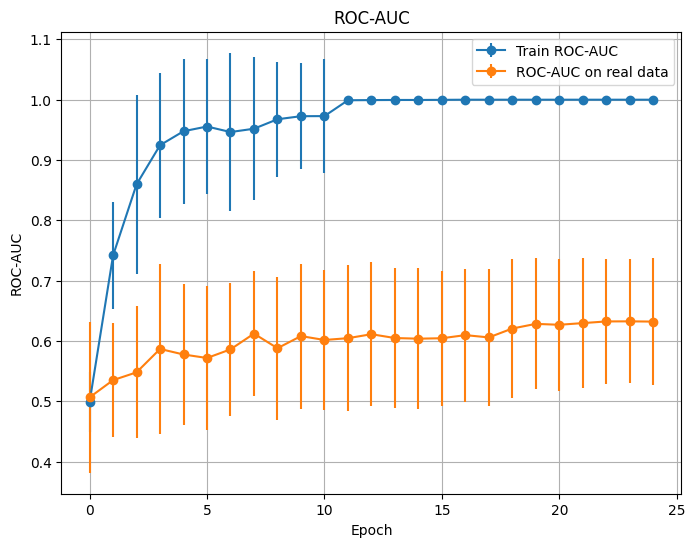

In [84]:
plt.figure(figsize=(8, 6))
plt.errorbar(range(train_roc_auc_mean.shape[0]), train_roc_auc_mean, yerr=train_roc_auc_std, fmt='-o', label='Train ROC-AUC')
plt.errorbar(range(aug_roc_auc_on_real_mean.shape[0]), aug_roc_auc_on_real_mean, yerr=aug_roc_auc_on_real_std, fmt='-o', label='ROC-AUC on real data')
plt.xlabel('Epoch')
plt.ylabel('ROC-AUC')
plt.title('ROC-AUC')
plt.legend()
plt.grid(True)
plt.show()

## China комбинированные

In [85]:
combined_data = torch.cat((data, augmented_data), axis=0)
combined_labels = [1] * (close.shape[1]) + [0] * (open.shape[1]) +\
 [1] * (close.shape[1] * augments_per_sample) + [0] * (open.shape[1] * augments_per_sample)
combined_labels = torch.tensor(combined_labels).float()

labels = [1] * (close.shape[1]) + [0] * (open.shape[1]) # 1 - closed, 0 - opened
labels = torch.tensor(labels).float()
aug_labels = [1] * (close.shape[1] * augments_per_sample) + [0] * (open.shape[1] * augments_per_sample) # 1 - closed, 0 - opened
aug_labels = torch.tensor(aug_labels).float()

In [86]:
train_losses_hist = []
test_losses_hist = []
train_accuracy_hist = []
test_accuracy_hist = []
train_roc_auc_hist = []
test_roc_auc_hist = []
val_losses_hist = []
aug_accuracy_on_real_hist = []
aug_roc_auc_on_real_hist = []

input_channels = close.shape[0]

for _ in range(n_experiments):
    for _, (train_index_orig, test_index_orig) in enumerate(kf.split(data, labels)):
      train_index = []
      for x in train_index_orig:
        train_index.append(3 * x)
        train_index.append(3 * x + 1)
        train_index.append(3 * x + 2)
      test_index = []
      for x in test_index_orig:
        test_index.append(3 * x)
        test_index.append(3 * x + 1)
        test_index.append(3 * x + 2)

      train_data = augmented_data[train_index]
      train_labels = aug_labels[train_index]
      train_data_orig = data[train_index_orig]
      train_labels_orig = labels[train_index_orig]

      train_comb = torch.cat((train_data, train_data_orig), axis=0)
      labels_comb = torch.cat((train_labels, train_labels_orig))
      train_dataset = TensorDataset(train_comb, labels_comb)

      test_data = augmented_data[test_index]
      test_labels = aug_labels[test_index]
      test_data_orig = data[test_index_orig]
      test_labels_orig = labels[test_index_orig]

      test_dataset = TensorDataset(test_data, test_labels)
      test_dataset_orig = TensorDataset(test_data_orig, test_labels_orig)

      train_dataset, val_dataset = train_test_split(train_dataset, test_size=0.3, random_state=33)
      aug_train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
      aug_test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
      aug_val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
      test_loader = DataLoader(test_dataset_orig, batch_size=batch_size, shuffle=True)

      train_losses = []
      test_losses = []
      train_accuracy = []
      test_accuracy = []
      train_roc_auc = []
      test_roc_auc = []
      val_losses = []
      aug_accuracy_on_real = []
      aug_roc_auc_on_real = []

      model = TimeSeriesCNN(input_channels, conv_output_size=2912)
      optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)
      aug_train(model)

      train_losses_hist.append(train_losses)
      test_losses_hist.append(test_losses)
      train_accuracy_hist.append(train_accuracy)
      test_accuracy_hist.append(test_accuracy)
      train_roc_auc_hist.append(train_roc_auc)
      test_roc_auc_hist.append(test_roc_auc)
      val_losses_hist.append(val_losses)
      aug_accuracy_on_real_hist.append(aug_accuracy_on_real)
      aug_roc_auc_on_real_hist.append(aug_roc_auc_on_real)

Epoch 1/25, Train loss: 76.4027, Test loss: 21.2694
Epoch 1/25, Train loss: 76.4672, Test loss: 21.3427
Epoch 1/25, Train loss: 76.0026, Test loss: 21.1179
Epoch 1/25, Train loss: 75.9946, Test loss: 21.0957
Epoch 1/25, Train loss: 75.9359, Test loss: 21.0930
Epoch 1/25, Train loss: 76.4122, Test loss: 21.3203
Early stopping!

Epoch 1/25, Train loss: 76.3664, Test loss: 21.3549
Epoch 1/25, Train loss: 75.9110, Test loss: 21.1122
Epoch 1/25, Train loss: 75.9360, Test loss: 21.0793
Epoch 1/25, Train loss: 75.8802, Test loss: 21.0873
Epoch 1/25, Train loss: 76.4768, Test loss: 21.3958
Epoch 1/25, Train loss: 76.4186, Test loss: 21.3552
Epoch 1/25, Train loss: 75.9044, Test loss: 21.0943
Epoch 1/25, Train loss: 75.8807, Test loss: 21.0790
Epoch 1/25, Train loss: 75.9877, Test loss: 21.1250


In [87]:
train_losses_np = np.array([lst + [0] * (num_epochs - len(lst)) for lst in train_losses_hist])
test_losses_np = np.array([lst + [0] * (num_epochs - len(lst)) for lst in test_losses_hist])
val_losses_np = np.array([lst + [0] * (num_epochs - len(lst)) for lst in val_losses_hist])
train_accuracy_np = np.array([lst + [0] * (num_epochs - len(lst)) for lst in train_accuracy_hist])
test_accuracy_np = np.array([lst + [0] * (num_epochs - len(lst)) for lst in test_accuracy_hist])
train_roc_auc_np = np.array([lst + [0] * (num_epochs - len(lst)) for lst in train_roc_auc_hist])
test_roc_auc_np = np.array([lst + [0] * (num_epochs - len(lst)) for lst in test_roc_auc_hist])
aug_accuracy_on_real_np = np.array([lst + [0] * (num_epochs - len(lst)) for lst in aug_accuracy_on_real_hist])
aug_roc_auc_on_real_np = np.array([lst + [0] * (num_epochs - len(lst)) for lst in aug_roc_auc_on_real_hist])

train_losses_np[train_losses_np == 0] = np.nan
test_losses_np[test_losses_np == 0] = np.nan
val_losses_np[val_losses_np == 0] = np.nan
train_accuracy_np[train_accuracy_np == 0] = np.nan
test_accuracy_np[test_accuracy_np == 0] = np.nan
train_roc_auc_np[train_roc_auc_np == 0] = np.nan
test_roc_auc_np[test_roc_auc_np == 0] = np.nan
aug_accuracy_on_real_np[aug_accuracy_on_real_np == 0] = np.nan
aug_roc_auc_on_real_np[aug_roc_auc_on_real_np == 0] = np.nan

train_losses_mean = np.nanmean(train_losses_np, axis=0)
train_losses_std = np.nanstd(train_losses_np, axis=0)
test_losses_mean = np.nanmean(test_losses_np, axis=0)
test_losses_std = np.nanstd(test_losses_np, axis=0)
val_losses_mean = np.nanmean(val_losses_np, axis=0)
val_losses_std = np.nanstd(val_losses_np, axis=0)
train_accuracy_mean = np.nanmean(train_accuracy_np, axis=0)
train_accuracy_std = np.nanstd(train_accuracy_np, axis=0)
test_accuracy_mean = np.nanmean(test_accuracy_np, axis=0)
test_accuracy_std = np.nanstd(test_accuracy_np, axis=0)
train_roc_auc_mean = np.nanmean(train_roc_auc_np, axis=0)
train_roc_auc_std = np.nanstd(train_roc_auc_np, axis=0)
test_roc_auc_mean = np.nanmean(test_roc_auc_np, axis=0)
test_roc_auc_std = np.nanstd(test_roc_auc_np, axis=0)
aug_accuracy_on_real_mean = np.nanmean(aug_accuracy_on_real_np, axis=0)
aug_accuracy_on_real_std = np.nanstd(aug_accuracy_on_real_np, axis=0)
aug_roc_auc_on_real_mean = np.nanmean(aug_roc_auc_on_real_np, axis=0)
aug_roc_auc_on_real_std = np.nanstd(aug_roc_auc_on_real_np, axis=0)

In [88]:
aug_accuracy_on_real_mean = aug_accuracy_on_real_mean[~np.isnan(aug_accuracy_on_real_mean)]
aug_accuracy_on_real_std = aug_accuracy_on_real_std[~np.isnan(aug_accuracy_on_real_std)]
aug_roc_auc_on_real_mean = aug_roc_auc_on_real_mean[~np.isnan(aug_roc_auc_on_real_mean)]
aug_roc_auc_on_real_std = aug_roc_auc_on_real_std[~np.isnan(aug_roc_auc_on_real_std)]
china_comb_acc_mean = np.max(aug_accuracy_on_real_mean)
china_comb_acc_std = aug_accuracy_on_real_std[np.argmax(aug_accuracy_on_real_mean)]
china_comb_roc_mean = np.max(aug_roc_auc_on_real_mean)
china_comb_roc_std = aug_roc_auc_on_real_std[np.argmax(aug_roc_auc_on_real_mean)]

In [89]:
china_comb_acc = aug_accuracy_on_real_np
china_comb_roc = aug_roc_auc_on_real_np

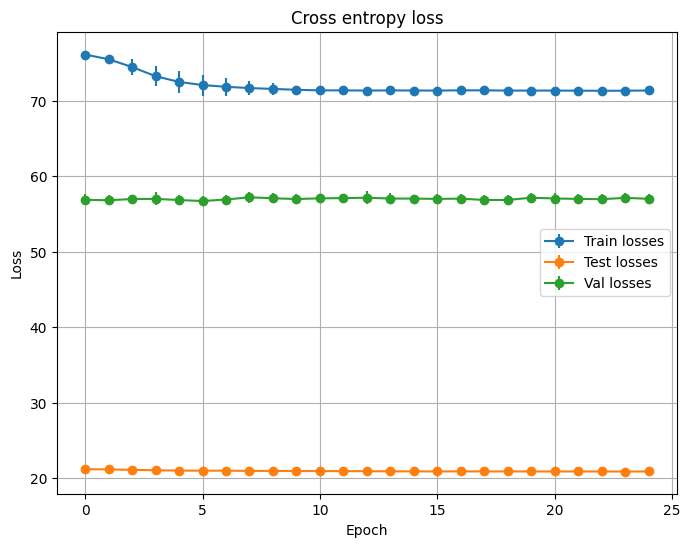

In [90]:
plt.figure(figsize=(8, 6))
plt.errorbar(range(train_losses_mean.shape[0]), train_losses_mean, yerr=train_losses_std, fmt='-o', label='Train losses')
plt.errorbar(range(test_losses_mean.shape[0]), test_losses_mean, yerr=test_losses_std, fmt='-o', label='Test losses')
plt.errorbar(range(val_losses_mean.shape[0]), val_losses_mean, yerr=val_losses_std, fmt='-o', label='Val losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Cross entropy loss')
plt.legend()
plt.grid(True)
plt.show()

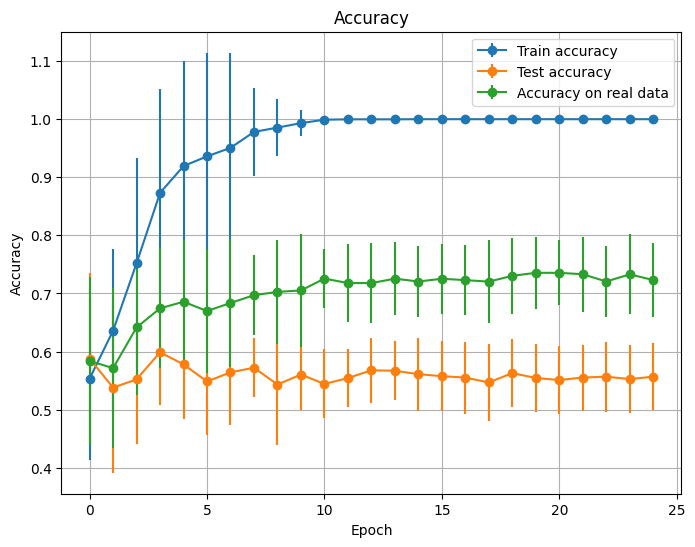

In [91]:
plt.figure(figsize=(8, 6))
plt.errorbar(range(train_accuracy_mean.shape[0]), train_accuracy_mean, yerr=train_accuracy_std, fmt='-o', label='Train accuracy')
plt.errorbar(range(test_accuracy_mean.shape[0]), test_accuracy_mean, yerr=test_accuracy_std, fmt='-o', label='Test accuracy')
plt.errorbar(range(aug_accuracy_on_real_mean.shape[0]), aug_accuracy_on_real_mean, yerr=aug_accuracy_on_real_std, fmt='-o', label='Accuracy on real data')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

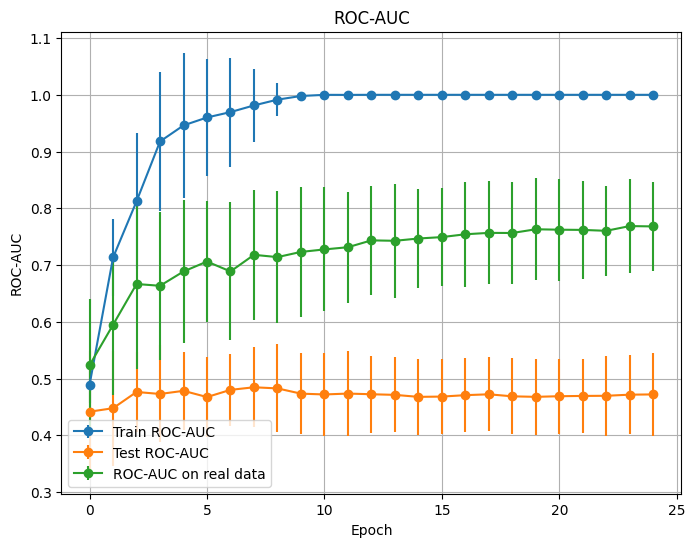

In [92]:
plt.figure(figsize=(8, 6))
plt.errorbar(range(train_roc_auc_mean.shape[0]), train_roc_auc_mean, yerr=train_roc_auc_std, fmt='-o', label='Train ROC-AUC')
plt.errorbar(range(test_roc_auc_mean.shape[0]), test_roc_auc_mean, yerr=test_roc_auc_std, fmt='-o', label='Test ROC-AUC')
plt.errorbar(range(aug_roc_auc_on_real_mean.shape[0]), aug_roc_auc_on_real_mean, yerr=aug_roc_auc_on_real_std, fmt='-o', label='ROC-AUC on real data')
plt.xlabel('Epoch')
plt.ylabel('ROC-AUC')
plt.title('ROC-AUC')
plt.legend()
plt.grid(True)
plt.show()

## China корреляции

In [104]:
real_covs = []
for i in range(data.shape[0]):
  real_covs.append(np.cov(data[i]))
real_covs = np.array(real_covs)
real_covs_mean = np.mean(real_covs, axis=0)
real_covs_std = np.std(real_covs, axis=0)

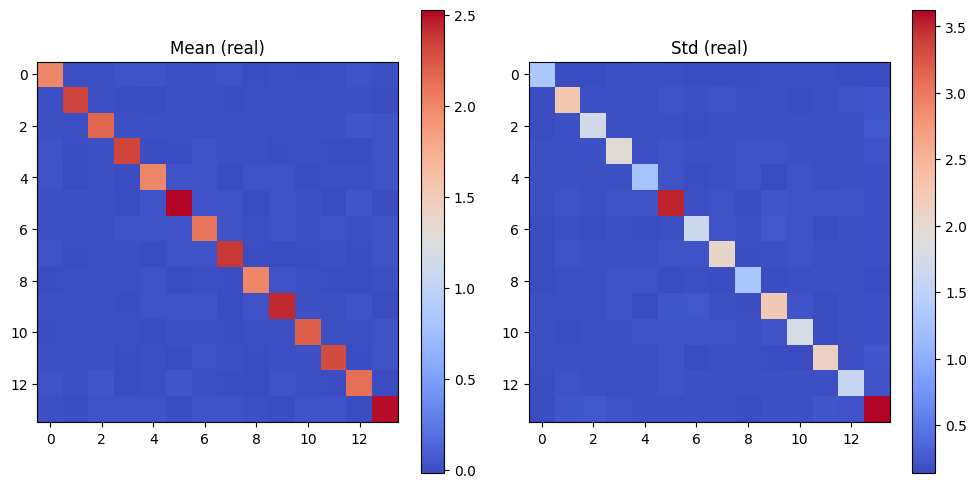

In [105]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(real_covs_mean, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.title('Mean (real)')
plt.subplot(1, 2, 2)
plt.imshow(real_covs_std, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.title('Std (real)')
plt.tight_layout()
plt.show()

In [106]:
aug_covs = []
for i in range(augmented_data.shape[0]):
  aug_covs.append(np.cov(augmented_data[i]))
aug_covs = np.array(aug_covs)
aug_covs_mean = np.mean(aug_covs, axis=0)
aug_covs_std = np.std(aug_covs, axis=0)

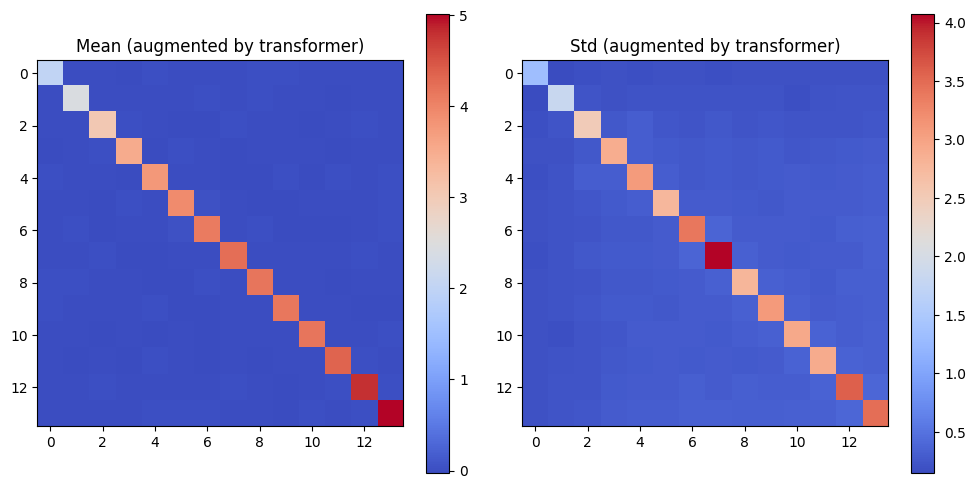

In [107]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(aug_covs_mean, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.title('Mean (augmented by transformer)')
plt.subplot(1, 2, 2)
plt.imshow(aug_covs_std, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.title('Std (augmented by transformer)')
plt.tight_layout()
plt.show()

## Результаты (IHB + China)

In [108]:
acc_means = [ihb_real_acc_mean, ihb_aug_acc_mean, ihb_comb_acc_mean, china_real_acc_mean, china_aug_acc_mean, china_comb_acc_mean]
acc_stds = [ihb_real_acc_std, ihb_aug_acc_std, ihb_comb_acc_std, china_real_acc_std, china_aug_acc_std, china_comb_acc_std]
roc_means = [ihb_real_roc_mean, ihb_aug_roc_mean, ihb_comb_roc_mean, china_real_roc_mean, china_aug_roc_mean, china_comb_roc_mean]
roc_stds = [ihb_real_roc_std, ihb_aug_roc_std, ihb_comb_roc_std, china_real_roc_std, china_aug_roc_std, china_comb_roc_std]
text = ["IHB real", "IHB augmented", "IHB combined", "China real", "China augmented", "China combined"]

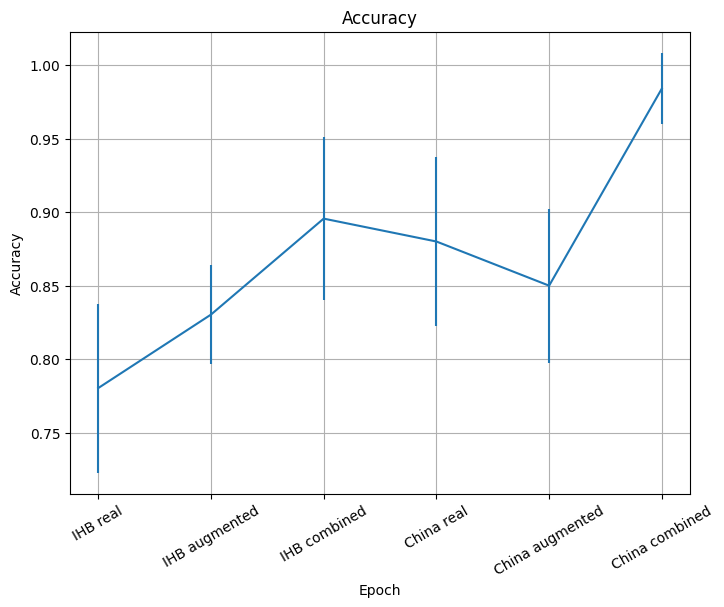

In [109]:
plt.figure(figsize=(8, 6))
plt.errorbar(text, acc_means, yerr=acc_stds)
plt.xticks(rotation=30)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.grid(True)
plt.show()

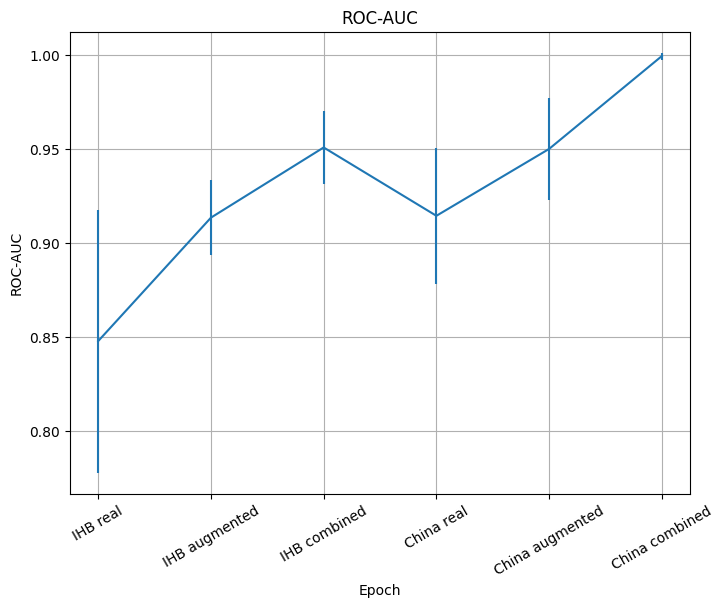

In [110]:
plt.figure(figsize=(8, 6))
plt.errorbar(text, roc_means, yerr=roc_stds)
plt.xticks(rotation=30)
plt.xlabel('Epoch')
plt.ylabel('ROC-AUC')
plt.title('ROC-AUC')
plt.grid(True)
plt.show()

In [102]:
#ihb_real_acc = np.max(ihb_real_acc, axis=1)
ihb_aug_acc = np.max(ihb_aug_acc, axis=1)
ihb_comb_acc = np.max(ihb_comb_acc, axis=1)
#china_real_acc = np.max(china_real_acc, axis=1)
china_aug_acc = np.max(china_aug_acc, axis=1)
china_comb_acc = np.max(china_comb_acc, axis=1)
#ihb_real_roc = np.max(ihb_real_roc, axis=1)
ihb_aug_roc = np.max(ihb_aug_roc, axis=1)
ihb_comb_roc = np.max(ihb_comb_roc, axis=1)
#china_real_roc = np.max(china_real_roc, axis=1)
china_aug_roc = np.max(china_aug_roc, axis=1)
china_comb_roc = np.max(china_comb_roc, axis=1)

In [97]:
combined_data.shape

(60, 25)

Text(0, 0.5, 'Accuracy')

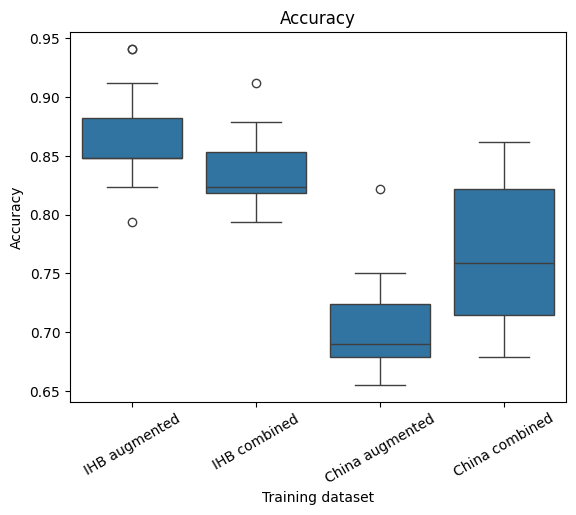

In [103]:
combined_data = np.concatenate([ihb_aug_acc, ihb_comb_acc, china_aug_acc, china_comb_acc])
labels = np.repeat(['IHB augmented', 'IHB combined', 'China augmented', 'China combined'], 15)
sns.boxplot(x=labels, y=combined_data)
plt.xticks(rotation=30)
plt.title('Accuracy')
plt.xlabel('Training dataset')
plt.ylabel('Accuracy')

In [100]:
combined_data = np.concatenate([ihb_aug_acc, ihb_comb_acc, china_aug_acc, china_comb_acc])

# Create the labels
labels = np.repeat(['IHB augmented', 'IHB combined', 'China augmented', 'China combined'], 15)

# Ensure the arrays have the same length
assert len(combined_data) == len(labels), "The length of combined_data and labels must match."

# Create the boxplot
sns.boxplot(x=labels, y=combined_data)
plt.xticks(rotation=30)
plt.title('Accuracy')
plt.xlabel('Training dataset')
plt.ylabel('Accuracy')

# Show the plot
plt.show()

ValueError: Per-column arrays must each be 1-dimensional

Text(0, 0.5, 'Accuracy')

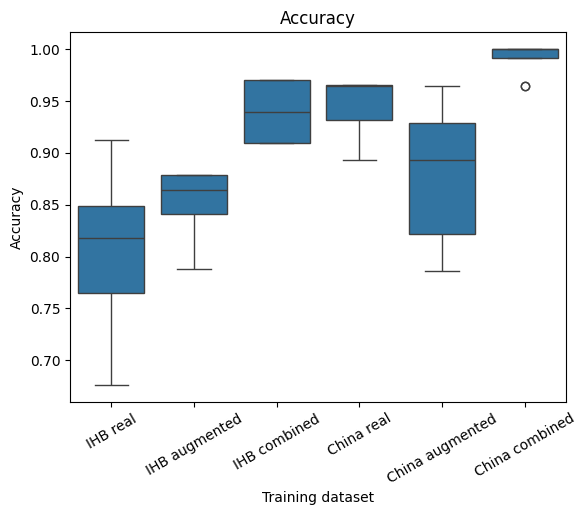

In [112]:
combined_data = np.concatenate([ihb_real_acc, ihb_aug_acc, ihb_comb_acc, china_real_acc, china_aug_acc, china_comb_acc])
labels = np.repeat(['IHB real', 'IHB augmented', 'IHB combined', 'China real', 'China augmented', 'China combined'], 10)
sns.boxplot(x=labels, y=combined_data)
plt.xticks(rotation=30)
plt.title('Accuracy')
plt.xlabel('Training dataset')
plt.ylabel('Accuracy')

Text(0, 0.5, 'ROC-AUC')

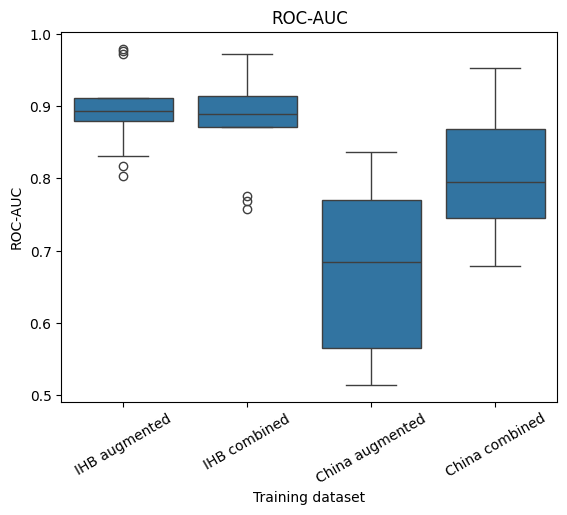

In [105]:
combined_data = np.concatenate([ihb_aug_roc, ihb_comb_roc, china_aug_roc, china_comb_roc])
labels = np.repeat(['IHB augmented', 'IHB combined', 'China augmented', 'China combined'], 15)
sns.boxplot(x=labels, y=combined_data)
plt.xticks(rotation=30)
plt.title('ROC-AUC')
plt.xlabel('Training dataset')
plt.ylabel('ROC-AUC')

Text(0, 0.5, 'ROC-AUC')

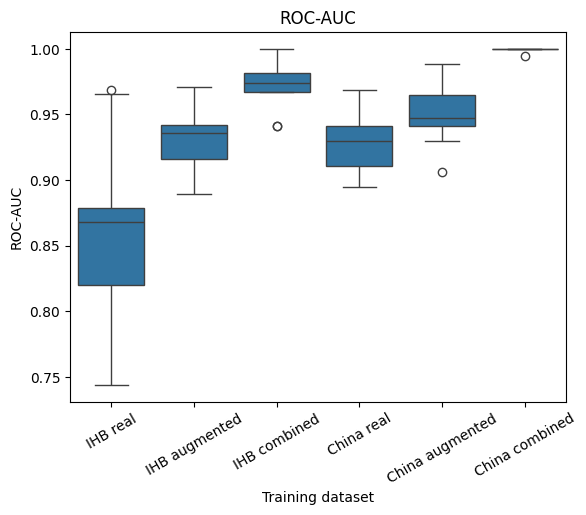

In [113]:
combined_data = np.concatenate([ihb_real_roc, ihb_aug_roc, ihb_comb_roc, china_real_roc, china_aug_roc, china_comb_roc])
labels = np.repeat(['IHB real', 'IHB augmented', 'IHB combined', 'China real', 'China augmented', 'China combined'], 10)
sns.boxplot(x=labels, y=combined_data)
plt.xticks(rotation=30)
plt.title('ROC-AUC')
plt.xlabel('Training dataset')
plt.ylabel('ROC-AUC')

In [114]:
print(acc_means)
print(roc_means)

[0.7803030303030304, 0.8303030303030303, 0.8956228956228958, 0.8800492610837438, 0.85, 0.9841269841269842]
[0.8477724913494809, 0.9133986928104575, 0.9507352941176471, 0.9143859649122806, 0.9499675113710203, 0.9993502274204028]


## China cut настоящие

In [115]:
open = np.load("/content/drive/MyDrive/china_open_mean_ts_by_network_HCPex.npy")
close = np.load("/content/drive/MyDrive/china_close_mean_ts_by_network_HCPex.npy")

In [116]:
close = close[:, :48, :]

In [117]:
data = np.concatenate((close, open), axis=1)
data = torch.tensor(data).float()
data = data.reshape((95, 14, 240))

labels = [1] * close.shape[1] + [0] * open.shape[1] # 1 - closed, 0 - opened
labels = torch.tensor(labels).float()

In [118]:
train_losses_hist = []
test_losses_hist = []
train_accuracy_hist = []
test_accuracy_hist = []
train_roc_auc_hist = []
test_roc_auc_hist = []
val_losses_hist = []

input_channels = close.shape[0]

for _ in range(n_experiments):
    for _, (train_index, test_index) in enumerate(kf.split(data, labels)):
      train_data = data[train_index]
      train_labels = labels[train_index]
      test_data = data[test_index]
      test_labels = labels[test_index]
      train_dataset = TensorDataset(train_data, train_labels)
      test_dataset = TensorDataset(test_data, test_labels)
      train_dataset, val_dataset = train_test_split(train_dataset, test_size=0.3, random_state=33)
      train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
      test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
      val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

      train_losses = []
      test_losses = []
      train_accuracy = []
      test_accuracy = []
      train_roc_auc = []
      test_roc_auc = []
      val_losses = []

      model = TimeSeriesCNN(input_channels, conv_output_size=2912)
      criterion = nn.CrossEntropyLoss()
      optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)
      train(model)

      train_losses_hist.append(train_losses)
      test_losses_hist.append(test_losses)
      train_accuracy_hist.append(train_accuracy)
      test_accuracy_hist.append(test_accuracy)
      train_roc_auc_hist.append(train_roc_auc)
      test_roc_auc_hist.append(test_roc_auc)
      val_losses_hist.append(val_losses)

Epoch 1/25, Train loss: 44.5905, Test loss: 29.4207
Epoch 1/25, Train loss: 44.2446, Test loss: 29.4408
Early stopping!

Epoch 1/25, Train loss: 45.6552, Test loss: 29.4087
Early stopping!

Epoch 1/25, Train loss: 46.4936, Test loss: 26.4770
Early stopping!

Epoch 1/25, Train loss: 46.5598, Test loss: 26.4818
Early stopping!

Epoch 1/25, Train loss: 44.4199, Test loss: 29.3871
Epoch 1/25, Train loss: 44.2058, Test loss: 29.4450
Epoch 1/25, Train loss: 44.2305, Test loss: 29.3858
Early stopping!

Epoch 1/25, Train loss: 46.4027, Test loss: 26.4723
Epoch 1/25, Train loss: 45.6075, Test loss: 26.4740
Early stopping!



In [119]:
train_losses_np = np.array([lst + [0] * (num_epochs - len(lst)) for lst in train_losses_hist])
test_losses_np = np.array([lst + [0] * (num_epochs - len(lst)) for lst in test_losses_hist])
val_losses_np = np.array([lst + [0] * (num_epochs - len(lst)) for lst in val_losses_hist])
train_accuracy_np = np.array([lst + [0] * (num_epochs - len(lst)) for lst in train_accuracy_hist])
test_accuracy_np = np.array([lst + [0] * (num_epochs - len(lst)) for lst in test_accuracy_hist])
train_roc_auc_np = np.array([lst + [0] * (num_epochs - len(lst)) for lst in train_roc_auc_hist])
test_roc_auc_np = np.array([lst + [0] * (num_epochs - len(lst)) for lst in test_roc_auc_hist])

train_losses_np[train_losses_np == 0] = np.nan
test_losses_np[test_losses_np == 0] = np.nan
val_losses_np[val_losses_np == 0] = np.nan
train_accuracy_np[train_accuracy_np == 0] = np.nan
test_accuracy_np[test_accuracy_np == 0] = np.nan
train_roc_auc_np[train_roc_auc_np == 0] = np.nan
test_roc_auc_np[test_roc_auc_np == 0] = np.nan

train_losses_mean = np.nanmean(train_losses_np, axis=0)
train_losses_std = np.nanstd(train_losses_np, axis=0)
test_losses_mean = np.nanmean(test_losses_np, axis=0)
test_losses_std = np.nanstd(test_losses_np, axis=0)
val_losses_mean = np.nanmean(val_losses_np, axis=0)
val_losses_std = np.nanstd(val_losses_np, axis=0)
train_accuracy_mean = np.nanmean(train_accuracy_np, axis=0)
train_accuracy_std = np.nanstd(train_accuracy_np, axis=0)
test_accuracy_mean = np.nanmean(test_accuracy_np, axis=0)
test_accuracy_std = np.nanstd(test_accuracy_np, axis=0)
train_roc_auc_mean = np.nanmean(train_roc_auc_np, axis=0)
train_roc_auc_std = np.nanstd(train_roc_auc_np, axis=0)
test_roc_auc_mean = np.nanmean(test_roc_auc_np, axis=0)
test_roc_auc_std = np.nanstd(test_roc_auc_np, axis=0)

In [120]:
china_cut_real_acc_mean = np.max(test_accuracy_mean)
china_cut_real_acc_std = test_accuracy_std[np.argmax(test_accuracy_mean)]
china_cut_real_roc_mean = np.max(test_roc_auc_mean)
china_cut_real_roc_std = test_roc_auc_std[np.argmax(test_roc_auc_mean)]

In [121]:
china_cut_real_acc = test_accuracy_np
china_cut_real_roc = test_roc_auc_np

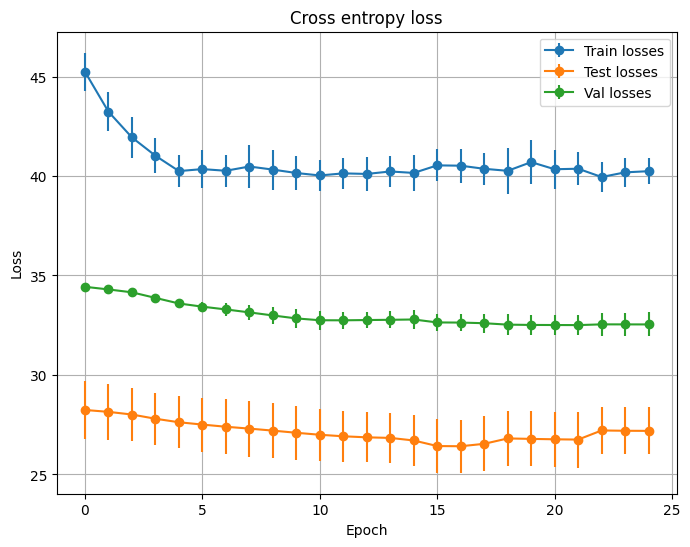

In [122]:
plt.figure(figsize=(8, 6))
plt.errorbar(range(train_losses_mean.shape[0]), train_losses_mean, yerr=train_losses_std, fmt='-o', label='Train losses')
plt.errorbar(range(test_losses_mean.shape[0]), test_losses_mean, yerr=test_losses_std, fmt='-o', label='Test losses')
plt.errorbar(range(val_losses_mean.shape[0]), val_losses_mean, yerr=val_losses_std, fmt='-o', label='Val losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Cross entropy loss')
plt.legend()
plt.grid(True)
plt.show()

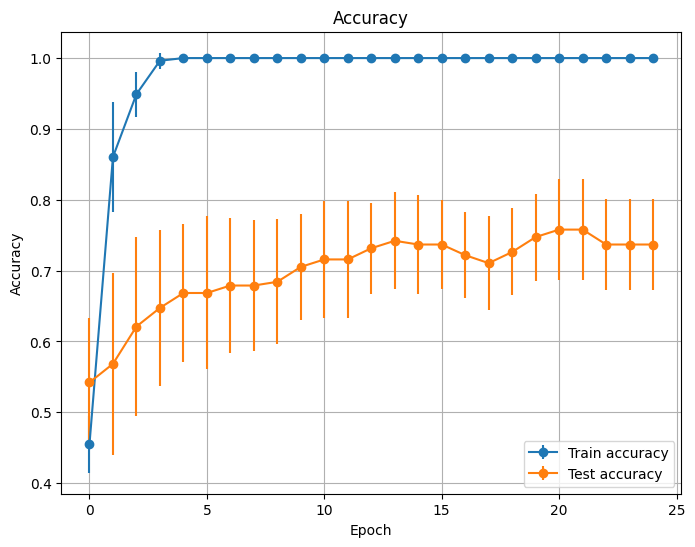

In [123]:
plt.figure(figsize=(8, 6))
plt.errorbar(range(train_accuracy_mean.shape[0]), train_accuracy_mean, yerr=train_accuracy_std, fmt='-o', label='Train accuracy')
plt.errorbar(range(test_accuracy_mean.shape[0]), test_accuracy_mean, yerr=test_accuracy_std, fmt='-o', label='Test accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

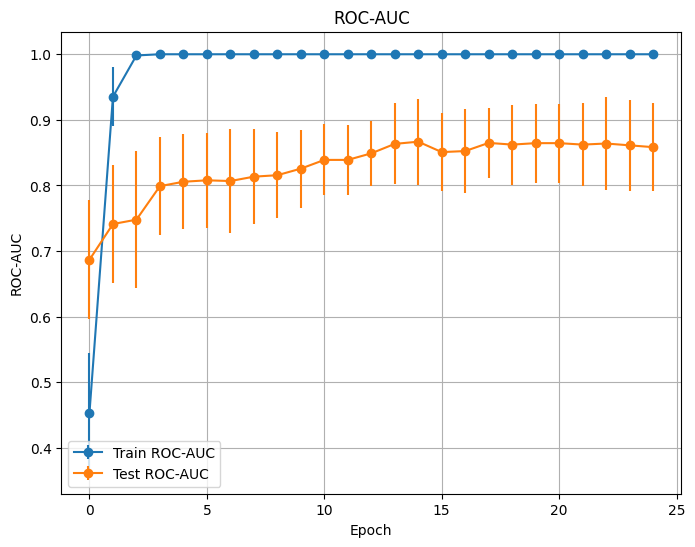

In [124]:
plt.figure(figsize=(8, 6))
plt.errorbar(range(train_roc_auc_mean.shape[0]), train_roc_auc_mean, yerr=train_roc_auc_std, fmt='-o', label='Train ROC-AUC')
plt.errorbar(range(test_roc_auc_mean.shape[0]), test_roc_auc_mean, yerr=test_roc_auc_std, fmt='-o', label='Test ROC-AUC')
plt.xlabel('Epoch')
plt.ylabel('ROC-AUC')
plt.title('ROC-AUC')
plt.legend()
plt.grid(True)
plt.show()

## China cut аугментация

In [125]:
data = data.reshape((95, 240, 14))

In [126]:
data = data[:92]

In [127]:
past_values = []
future_values = []
past_time_features = []
future_time_features = []
static_categorical_features = []
for i in range(data.shape[0]):
  start = 0
  while start + 24 < data[i].shape[0]:
    past_values.append(data[i][start : start+20])
    future_values.append(data[i][start+20 : start+24])
    past_time_features.append(range(start, start+20))
    future_time_features.append(range(start+20, start+24))
    static_categorical_features.append(1 - (i // (data.shape[0] // 2)))
    start += 4
past_values = torch.stack(past_values)
future_values = torch.stack(future_values)
past_time_features = torch.Tensor(past_time_features)
future_time_features = torch.Tensor(future_time_features)
past_time_features = past_time_features.reshape((past_time_features.shape[0], past_time_features.shape[1], 1))
future_time_features = future_time_features.reshape((future_time_features.shape[0], future_time_features.shape[1], 1))
past_observed_mask = torch.ones(past_values.shape)
static_categorical_features = torch.Tensor(static_categorical_features).int()

In [128]:
n = past_values.shape[0]
test_size = 0.2
test_idx = np.random.choice(range(n), size=int(test_size * n), replace=False)
train_idx = np.setdiff1d(range(n), test_idx)
train_past_values = past_values[train_idx]
test_past_values = past_values[test_idx]
train_future_values = future_values[train_idx]
test_future_values = future_values[test_idx]
train_past_time_features = past_time_features[train_idx]
test_past_time_features = past_time_features[test_idx]
train_future_time_features = future_time_features[train_idx]
test_future_time_features = future_time_features[test_idx]
train_past_observed_mask = past_observed_mask[train_idx]
test_past_observed_mask = past_observed_mask[test_idx]
train_static_categorical_features = static_categorical_features[train_idx]
test_static_categorical_features = static_categorical_features[test_idx]

In [129]:
train_dataset = []
for i in range(train_past_values.shape[0]):
    train_dataset.append({
        "past_values": train_past_values[i],
        "future_values": train_future_values[i],
        "past_time_features": train_past_time_features[i],
        "future_time_features": train_future_time_features[i],
        "past_observed_mask": train_past_observed_mask[i],
        "static_categorical_features": train_static_categorical_features[i]
    })

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = []
for i in range(test_past_values.shape[0]):
    test_dataset.append({
        "past_values": test_past_values[i],
        "future_values": test_future_values[i],
        "past_time_features": test_past_time_features[i],
        "future_time_features": test_future_time_features[i],
        "past_observed_mask": test_past_observed_mask[i],
        "static_categorical_features": test_static_categorical_features[i]
    })

test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [130]:
lags_sequence = [1, 2, 3, 4, 5, 6, 7]
configuration = TimeSeriesTransformerConfig(prediction_length=4, context_length=20 - len(lags_sequence), input_size=14,
                                            num_time_features=1, lags_sequence=lags_sequence, num_parallel_samples=1,
                                            num_static_categorical_features=1, cardinality=[2], embedding_dimension=[1])
model = TimeSeriesTransformerForPrediction(configuration)
optimizer = torch.optim.AdamW(model.parameters(), lr=6e-4, betas=(0.9, 0.95), weight_decay=1e-1)

In [131]:
n_epochs = 100
print_every = 10
train_losses = []
test_losses = []
for epoch in range(n_epochs):
    for idx, batch in enumerate(train_dataloader):
        model.train()
        optimizer.zero_grad()
        loss = model(
            past_values=batch["past_values"],
            future_values=batch["future_values"],
            past_time_features=batch["past_time_features"],
            future_time_features=batch["future_time_features"],
            past_observed_mask=batch["past_observed_mask"],
            static_categorical_features=batch["static_categorical_features"].reshape((batch["static_categorical_features"].shape[0], 1))
        ).loss
        loss.backward()
        train_losses.append(loss.item())

        optimizer.step()

        if epoch % print_every == 0 and idx == 0:
            print("Epoch: ", epoch, ", Train loss: ", loss.item(), end="", sep="")

    for idx, batch in enumerate(test_dataloader):
        model.eval()
        loss = model(
            past_values=batch["past_values"],
            future_values=batch["future_values"],
            past_time_features=batch["past_time_features"],
            future_time_features=batch["future_time_features"],
            past_observed_mask=batch["past_observed_mask"],
            static_categorical_features=batch["static_categorical_features"].reshape((batch["static_categorical_features"].shape[0], 1))
        ).loss
        test_losses.append(loss.item())
        if epoch % print_every == 0 and idx == 0:
            print(", Test loss:", loss.item())


Epoch: 0, Train loss: 26.545595169067383, Test loss: 25.275333404541016
Epoch: 10, Train loss: 23.72205352783203, Test loss: 23.44347381591797
Epoch: 20, Train loss: 23.257144927978516, Test loss: 23.333831787109375
Epoch: 30, Train loss: 23.404138565063477, Test loss: 24.402210235595703
Epoch: 40, Train loss: 23.577892303466797, Test loss: 24.054344177246094
Epoch: 50, Train loss: 24.527835845947266, Test loss: 23.48090362548828
Epoch: 60, Train loss: 23.05878448486328, Test loss: 24.402536392211914
Epoch: 70, Train loss: 24.299537658691406, Test loss: 25.73445701599121
Epoch: 80, Train loss: 23.362253189086914, Test loss: 22.063180923461914
Epoch: 90, Train loss: 22.170631408691406, Test loss: 24.085481643676758


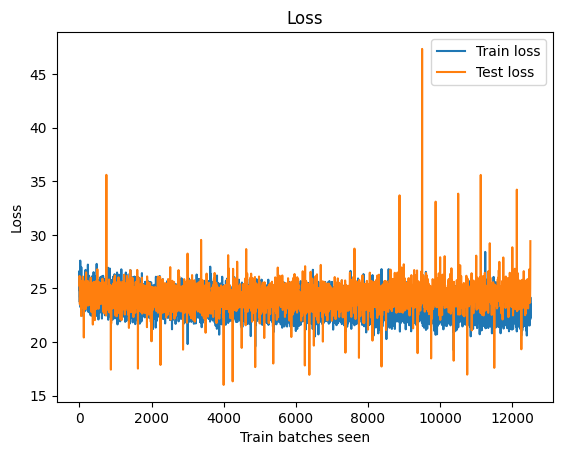

In [132]:
plt.plot(range(len(train_losses)), train_losses, label='Train loss')
ratio = int(len(train_losses) / len(test_losses))
plt.plot(np.linspace(0, len(train_losses), len(test_losses)), test_losses, label='Test loss')
plt.xlabel('Train batches seen')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()
plt.show()

In [133]:
augmented_data = []
model.eval()
for i in trange(data.shape[0]):
  for _ in range(augments_per_sample):
    augmented = data[i][0 : 20]
    while augmented.shape[0] < 240:
      past_values = augmented[-20:].reshape((1, 20, 14))
      past_time_features = torch.Tensor(range(augmented.shape[0] - 20, augmented.shape[0])).reshape(1, 20, 1)
      future_time_features = torch.Tensor(range(augmented.shape[0], augmented.shape[0] + 4)).reshape(1, 4, 1)
      past_observed_mask = torch.ones(past_values.shape)
      if i < 47:
        static_categorical_features = torch.Tensor([1]).reshape((1, 1)).int()
      else:
        static_categorical_features = torch.Tensor([0]).reshape((1, 1)).int()
      gen = model.generate(
          past_values=past_values,
          past_time_features=past_time_features,
          future_time_features=future_time_features,
          past_observed_mask=past_observed_mask,
          static_categorical_features=static_categorical_features
      )["sequences"].reshape((4, 14))
      augmented = torch.cat((augmented, gen), dim=0)
    augmented_data.append(augmented)

100%|██████████| 92/92 [04:55<00:00,  3.22s/it]


In [134]:
augmented_data = torch.stack(augmented_data)

In [135]:
augmented_data.shape

torch.Size([276, 240, 14])

In [136]:
augmented_data = augmented_data.reshape((augmented_data.shape[0], 14, 240))
data = data.reshape((92, 14, 240))

## China cut аугментированные

In [137]:
labels = [1] * (45 * augments_per_sample) + [0] * (47 * augments_per_sample) # 1 - closed, 0 - opened
labels = torch.tensor(labels).float()

In [138]:
augmented_dataset = TensorDataset(augmented_data, labels)
aug_train_dataset, aug_test_dataset = train_test_split(augmented_dataset, test_size=0.3, random_state=44)
aug_train_dataset, aug_val_dataset = train_test_split(aug_train_dataset, test_size=0.3, random_state=44)

In [139]:
train_losses_hist = []
test_losses_hist = []
train_accuracy_hist = []
test_accuracy_hist = []
train_roc_auc_hist = []
test_roc_auc_hist = []
val_losses_hist = []
aug_accuracy_on_real_hist = []
aug_roc_auc_on_real_hist = []

input_channels = close.shape[0]

for _ in range(n_experiments):
    for _, (train_index, test_index) in enumerate(kf.split(augmented_data, labels)):
      train_data = augmented_data[train_index]
      train_labels = labels[train_index]
     # print(train_index)
      test_data = augmented_data[test_index]
      test_labels = labels[test_index]
      train_dataset = TensorDataset(train_data, train_labels)
      test_dataset = TensorDataset(test_data, test_labels)
      train_dataset, val_dataset = train_test_split(train_dataset, test_size=0.3, random_state=33)
      aug_train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
      aug_test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
      aug_val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

      train_losses = []
      test_losses = []
      train_accuracy = []
      test_accuracy = []
      train_roc_auc = []
      test_roc_auc = []
      val_losses = []
      aug_accuracy_on_real = []
      aug_roc_auc_on_real = []

      model = TimeSeriesCNN(input_channels, conv_output_size=2912)
      optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)
      aug_train(model)

      train_losses_hist.append(train_losses)
      test_losses_hist.append(test_losses)
      train_accuracy_hist.append(train_accuracy)
      test_accuracy_hist.append(test_accuracy)
      train_roc_auc_hist.append(train_roc_auc)
      test_roc_auc_hist.append(test_roc_auc)
      val_losses_hist.append(val_losses)
      aug_accuracy_on_real_hist.append(aug_accuracy_on_real)
      aug_roc_auc_on_real_hist.append(aug_roc_auc_on_real)

Epoch 1/25, Train loss: 54.2103, Test loss: 13.1537
Epoch 1/25, Train loss: 54.1937, Test loss: 13.2031
Epoch 1/25, Train loss: 53.9643, Test loss: 13.2187
Epoch 1/25, Train loss: 53.9176, Test loss: 13.1843
Epoch 1/25, Train loss: 53.8246, Test loss: 13.1808
Epoch 1/25, Train loss: 54.0086, Test loss: 13.1796
Epoch 1/25, Train loss: 54.0925, Test loss: 13.1776
Epoch 1/25, Train loss: 54.0352, Test loss: 13.1441
Epoch 1/25, Train loss: 54.2677, Test loss: 13.1795
Epoch 1/25, Train loss: 53.8802, Test loss: 13.1966


In [140]:
train_losses_np = np.array([lst + [0] * (num_epochs - len(lst)) for lst in train_losses_hist])
val_losses_np = np.array([lst + [0] * (num_epochs - len(lst)) for lst in val_losses_hist])
train_accuracy_np = np.array([lst + [0] * (num_epochs - len(lst)) for lst in train_accuracy_hist])
train_roc_auc_np = np.array([lst + [0] * (num_epochs - len(lst)) for lst in train_roc_auc_hist])
aug_accuracy_on_real_np = np.array([lst + [0] * (num_epochs - len(lst)) for lst in aug_accuracy_on_real_hist])
aug_roc_auc_on_real_np = np.array([lst + [0] * (num_epochs - len(lst)) for lst in aug_roc_auc_on_real_hist])

train_losses_np[train_losses_np == 0] = np.nan
val_losses_np[val_losses_np == 0] = np.nan
train_accuracy_np[train_accuracy_np == 0] = np.nan
train_roc_auc_np[train_roc_auc_np == 0] = np.nan
aug_accuracy_on_real_np[aug_accuracy_on_real_np == 0] = np.nan
aug_roc_auc_on_real_np[aug_roc_auc_on_real_np == 0] = np.nan

train_losses_mean = np.nanmean(train_losses_np, axis=0)
train_losses_std = np.nanstd(train_losses_np, axis=0)
val_losses_mean = np.nanmean(val_losses_np, axis=0)
val_losses_std = np.nanstd(val_losses_np, axis=0)
train_accuracy_mean = np.nanmean(train_accuracy_np, axis=0)
train_accuracy_std = np.nanstd(train_accuracy_np, axis=0)
train_roc_auc_mean = np.nanmean(train_roc_auc_np, axis=0)
train_roc_auc_std = np.nanstd(train_roc_auc_np, axis=0)
aug_accuracy_on_real_mean = np.nanmean(aug_accuracy_on_real_np, axis=0)
aug_accuracy_on_real_std = np.nanstd(aug_accuracy_on_real_np, axis=0)
aug_roc_auc_on_real_mean = np.nanmean(aug_roc_auc_on_real_np, axis=0)
aug_roc_auc_on_real_std = np.nanstd(aug_roc_auc_on_real_np, axis=0)

In [141]:
aug_accuracy_on_real_mean = aug_accuracy_on_real_mean[~np.isnan(aug_accuracy_on_real_mean)]
aug_accuracy_on_real_std = aug_accuracy_on_real_std[~np.isnan(aug_accuracy_on_real_std)]
aug_roc_auc_on_real_mean = aug_roc_auc_on_real_mean[~np.isnan(aug_roc_auc_on_real_mean)]
aug_roc_auc_on_real_std = aug_roc_auc_on_real_std[~np.isnan(aug_roc_auc_on_real_std)]
china_cut_aug_acc_mean = np.max(aug_accuracy_on_real_mean)
china_cut_aug_acc_std = aug_accuracy_on_real_std[np.argmax(aug_accuracy_on_real_mean)]
china_cut_aug_roc_mean = np.max(aug_roc_auc_on_real_mean)
china_cut_aug_roc_std = aug_roc_auc_on_real_std[np.argmax(aug_roc_auc_on_real_mean)]

In [142]:
china_cut_aug_acc = aug_accuracy_on_real_np
china_cut_aug_roc = aug_roc_auc_on_real_np

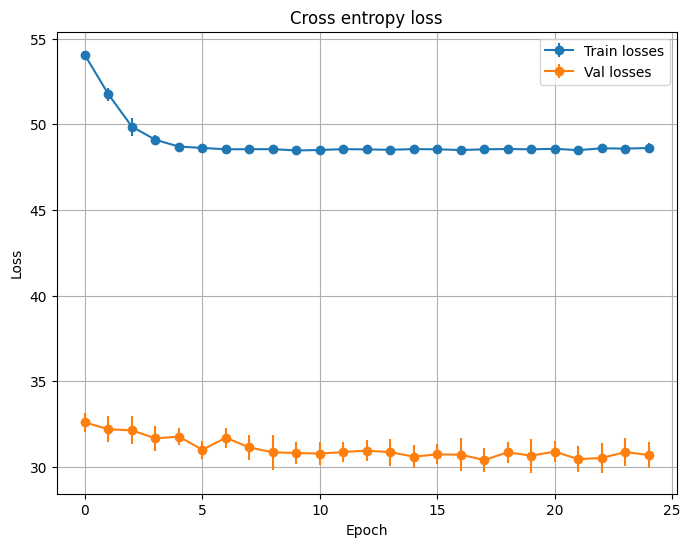

In [143]:
plt.figure(figsize=(8, 6))
plt.errorbar(range(train_losses_mean.shape[0]), train_losses_mean, yerr=train_losses_std, fmt='-o', label='Train losses')
plt.errorbar(range(val_losses_mean.shape[0]), val_losses_mean, yerr=val_losses_std, fmt='-o', label='Val losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Cross entropy loss')
plt.legend()
plt.grid(True)
plt.show()

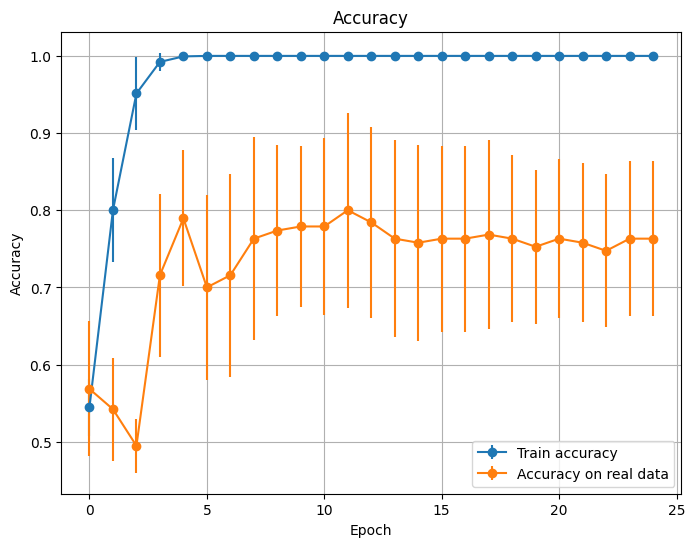

In [144]:
plt.figure(figsize=(8, 6))
plt.errorbar(range(train_accuracy_mean.shape[0]), train_accuracy_mean, yerr=train_accuracy_std, fmt='-o', label='Train accuracy')
plt.errorbar(range(aug_accuracy_on_real_mean.shape[0]), aug_accuracy_on_real_mean, yerr=aug_accuracy_on_real_std, fmt='-o', label='Accuracy on real data')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

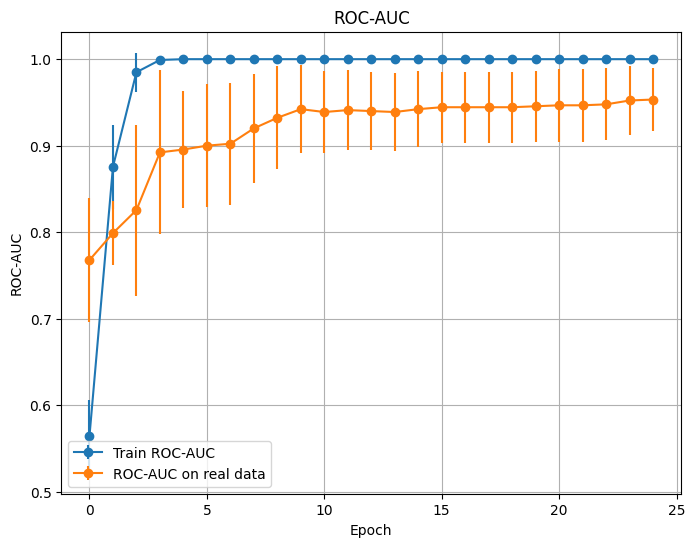

In [145]:
plt.figure(figsize=(8, 6))
plt.errorbar(range(train_roc_auc_mean.shape[0]), train_roc_auc_mean, yerr=train_roc_auc_std, fmt='-o', label='Train ROC-AUC')
plt.errorbar(range(aug_roc_auc_on_real_mean.shape[0]), aug_roc_auc_on_real_mean, yerr=aug_roc_auc_on_real_std, fmt='-o', label='ROC-AUC on real data')
plt.xlabel('Epoch')
plt.ylabel('ROC-AUC')
plt.title('ROC-AUC')
plt.legend()
plt.grid(True)
plt.show()

## China cut комбинированные

In [146]:
combined_data = torch.cat((data, augmented_data), axis=0)
combined_labels = [1] * 45 + [0] * 47 +\
 [1] * (45 * augments_per_sample) + [0] * (47 * augments_per_sample)
combined_labels = torch.tensor(combined_labels).float()

In [147]:
train_losses_hist = []
test_losses_hist = []
train_accuracy_hist = []
test_accuracy_hist = []
train_roc_auc_hist = []
test_roc_auc_hist = []
val_losses_hist = []
aug_accuracy_on_real_hist = []
aug_roc_auc_on_real_hist = []

input_channels = close.shape[0]

for _ in range(n_experiments):
    for _, (train_index, test_index) in enumerate(kf.split(combined_data, combined_labels)):
      train_data = combined_data[train_index]
      train_labels = combined_labels[train_index]
      test_data = combined_data[test_index]
      test_labels = combined_labels[test_index]
      train_dataset = TensorDataset(train_data, train_labels)
      test_dataset = TensorDataset(test_data, test_labels)
      train_dataset, val_dataset = train_test_split(train_dataset, test_size=0.3, random_state=33)
      aug_train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
      aug_test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
      aug_val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

      train_losses = []
      test_losses = []
      train_accuracy = []
      test_accuracy = []
      train_roc_auc = []
      test_roc_auc = []
      val_losses = []
      aug_accuracy_on_real = []
      aug_roc_auc_on_real = []

      model = TimeSeriesCNN(input_channels, conv_output_size=2912)
      optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)
      aug_train(model)

      train_losses_hist.append(train_losses)
      test_losses_hist.append(test_losses)
      train_accuracy_hist.append(train_accuracy)
      test_accuracy_hist.append(test_accuracy)
      train_roc_auc_hist.append(train_roc_auc)
      test_roc_auc_hist.append(test_roc_auc)
      val_losses_hist.append(val_losses)
      aug_accuracy_on_real_hist.append(aug_accuracy_on_real)
      aug_roc_auc_on_real_hist.append(aug_roc_auc_on_real)

Epoch 1/25, Train loss: 50.8255, Test loss: 8.6732
Epoch 1/25, Train loss: 52.6329, Test loss: 8.7049
Epoch 1/25, Train loss: 51.2189, Test loss: 8.7170
Epoch 1/25, Train loss: 52.1184, Test loss: 8.6546
Epoch 1/25, Train loss: 53.4768, Test loss: 8.6974
Epoch 1/25, Train loss: 51.4262, Test loss: 8.6041
Epoch 1/25, Train loss: 52.0805, Test loss: 8.7203
Epoch 1/25, Train loss: 51.4616, Test loss: 8.6775
Epoch 1/25, Train loss: 51.8945, Test loss: 8.6588
Epoch 1/25, Train loss: 53.3742, Test loss: 8.7343


In [148]:
train_losses_np = np.array([lst + [0] * (num_epochs - len(lst)) for lst in train_losses_hist])
test_losses_np = np.array([lst + [0] * (num_epochs - len(lst)) for lst in test_losses_hist])
val_losses_np = np.array([lst + [0] * (num_epochs - len(lst)) for lst in val_losses_hist])
train_accuracy_np = np.array([lst + [0] * (num_epochs - len(lst)) for lst in train_accuracy_hist])
test_accuracy_np = np.array([lst + [0] * (num_epochs - len(lst)) for lst in test_accuracy_hist])
train_roc_auc_np = np.array([lst + [0] * (num_epochs - len(lst)) for lst in train_roc_auc_hist])
test_roc_auc_np = np.array([lst + [0] * (num_epochs - len(lst)) for lst in test_roc_auc_hist])
aug_accuracy_on_real_np = np.array([lst + [0] * (num_epochs - len(lst)) for lst in aug_accuracy_on_real_hist])
aug_roc_auc_on_real_np = np.array([lst + [0] * (num_epochs - len(lst)) for lst in aug_roc_auc_on_real_hist])

train_losses_np[train_losses_np == 0] = np.nan
test_losses_np[test_losses_np == 0] = np.nan
val_losses_np[val_losses_np == 0] = np.nan
train_accuracy_np[train_accuracy_np == 0] = np.nan
test_accuracy_np[test_accuracy_np == 0] = np.nan
train_roc_auc_np[train_roc_auc_np == 0] = np.nan
test_roc_auc_np[test_roc_auc_np == 0] = np.nan
aug_accuracy_on_real_np[aug_accuracy_on_real_np == 0] = np.nan
aug_roc_auc_on_real_np[aug_roc_auc_on_real_np == 0] = np.nan

train_losses_mean = np.nanmean(train_losses_np, axis=0)
train_losses_std = np.nanstd(train_losses_np, axis=0)
test_losses_mean = np.nanmean(test_losses_np, axis=0)
test_losses_std = np.nanstd(test_losses_np, axis=0)
val_losses_mean = np.nanmean(val_losses_np, axis=0)
val_losses_std = np.nanstd(val_losses_np, axis=0)
train_accuracy_mean = np.nanmean(train_accuracy_np, axis=0)
train_accuracy_std = np.nanstd(train_accuracy_np, axis=0)
test_accuracy_mean = np.nanmean(test_accuracy_np, axis=0)
test_accuracy_std = np.nanstd(test_accuracy_np, axis=0)
train_roc_auc_mean = np.nanmean(train_roc_auc_np, axis=0)
train_roc_auc_std = np.nanstd(train_roc_auc_np, axis=0)
test_roc_auc_mean = np.nanmean(test_roc_auc_np, axis=0)
test_roc_auc_std = np.nanstd(test_roc_auc_np, axis=0)
aug_accuracy_on_real_mean = np.nanmean(aug_accuracy_on_real_np, axis=0)
aug_accuracy_on_real_std = np.nanstd(aug_accuracy_on_real_np, axis=0)
aug_roc_auc_on_real_mean = np.nanmean(aug_roc_auc_on_real_np, axis=0)
aug_roc_auc_on_real_std = np.nanstd(aug_roc_auc_on_real_np, axis=0)

In [149]:
aug_accuracy_on_real_mean = aug_accuracy_on_real_mean[~np.isnan(aug_accuracy_on_real_mean)]
aug_accuracy_on_real_std = aug_accuracy_on_real_std[~np.isnan(aug_accuracy_on_real_std)]
aug_roc_auc_on_real_mean = aug_roc_auc_on_real_mean[~np.isnan(aug_roc_auc_on_real_mean)]
aug_roc_auc_on_real_std = aug_roc_auc_on_real_std[~np.isnan(aug_roc_auc_on_real_std)]
china_comb_acc_mean = np.max(aug_accuracy_on_real_mean)
china_comb_acc_std = aug_accuracy_on_real_std[np.argmax(aug_accuracy_on_real_mean)]
china_comb_roc_mean = np.max(aug_roc_auc_on_real_mean)
china_comb_roc_std = aug_roc_auc_on_real_std[np.argmax(aug_roc_auc_on_real_mean)]

In [150]:
china_cut_comb_acc = aug_accuracy_on_real_np
china_cut_comb_roc = aug_roc_auc_on_real_np

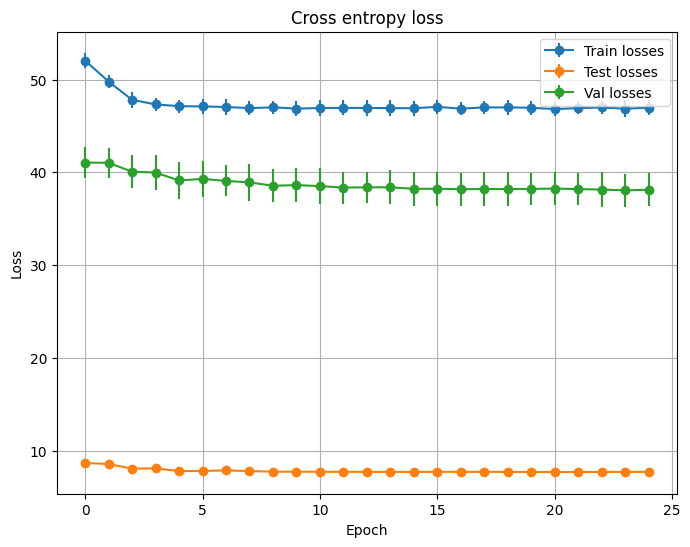

In [151]:
plt.figure(figsize=(8, 6))
plt.errorbar(range(train_losses_mean.shape[0]), train_losses_mean, yerr=train_losses_std, fmt='-o', label='Train losses')
plt.errorbar(range(test_losses_mean.shape[0]), test_losses_mean, yerr=test_losses_std, fmt='-o', label='Test losses')
plt.errorbar(range(val_losses_mean.shape[0]), val_losses_mean, yerr=val_losses_std, fmt='-o', label='Val losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Cross entropy loss')
plt.legend()
plt.grid(True)
plt.show()

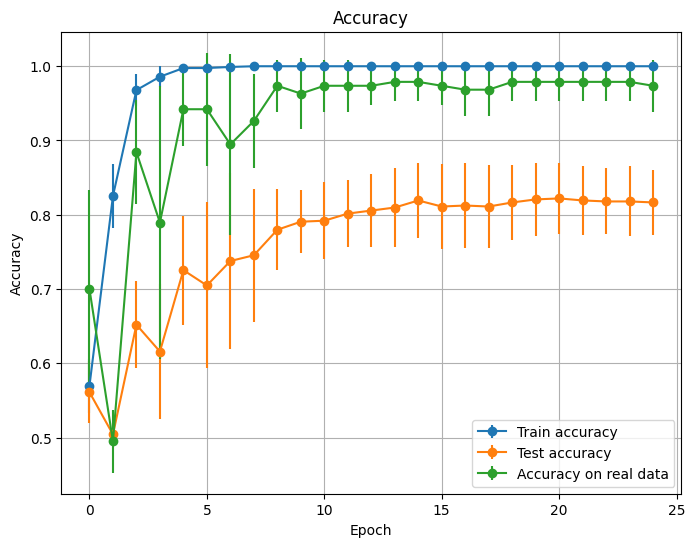

In [152]:
plt.figure(figsize=(8, 6))
plt.errorbar(range(train_accuracy_mean.shape[0]), train_accuracy_mean, yerr=train_accuracy_std, fmt='-o', label='Train accuracy')
plt.errorbar(range(test_accuracy_mean.shape[0]), test_accuracy_mean, yerr=test_accuracy_std, fmt='-o', label='Test accuracy')
plt.errorbar(range(aug_accuracy_on_real_mean.shape[0]), aug_accuracy_on_real_mean, yerr=aug_accuracy_on_real_std, fmt='-o', label='Accuracy on real data')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

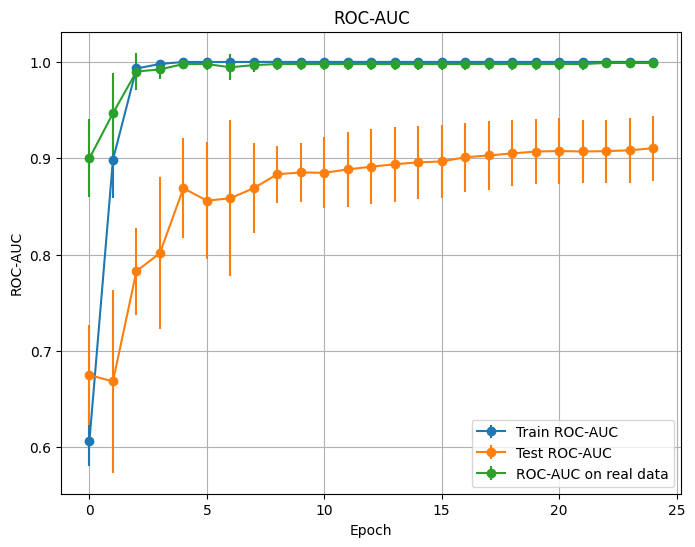

In [153]:
plt.figure(figsize=(8, 6))
plt.errorbar(range(train_roc_auc_mean.shape[0]), train_roc_auc_mean, yerr=train_roc_auc_std, fmt='-o', label='Train ROC-AUC')
plt.errorbar(range(test_roc_auc_mean.shape[0]), test_roc_auc_mean, yerr=test_roc_auc_std, fmt='-o', label='Test ROC-AUC')
plt.errorbar(range(aug_roc_auc_on_real_mean.shape[0]), aug_roc_auc_on_real_mean, yerr=aug_roc_auc_on_real_std, fmt='-o', label='ROC-AUC on real data')
plt.xlabel('Epoch')
plt.ylabel('ROC-AUC')
plt.title('ROC-AUC')
plt.legend()
plt.grid(True)
plt.show()

## China cut результаты

In [154]:
china_cut_real_acc = np.max(china_cut_real_acc, axis=1)
china_cut_aug_acc = np.max(china_cut_aug_acc, axis=1)
china_cut_comb_acc = np.max(china_cut_comb_acc, axis=1)

In [155]:
china_cut_real_roc = np.max(china_cut_real_roc, axis=1)
china_cut_aug_roc = np.max(china_cut_aug_roc, axis=1)
china_cut_comb_roc = np.max(china_cut_comb_roc, axis=1)

In [157]:
combined_data.shape

(30,)

Text(0, 0.5, 'Accuracy')

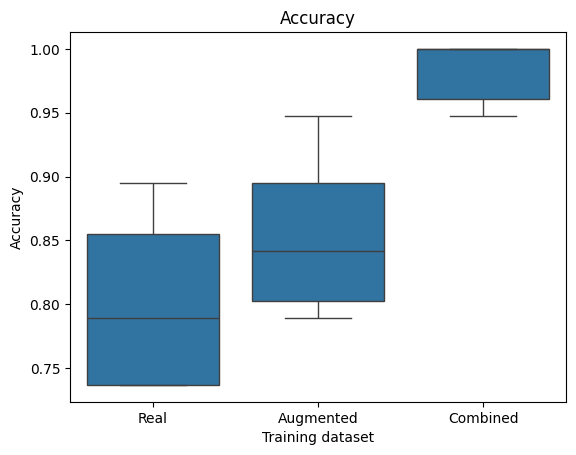

In [159]:
combined_data = np.concatenate([china_cut_real_acc, china_cut_aug_acc, china_cut_comb_acc])
labels = np.repeat(['Real', 'Augmented', 'Combined'], 10)
sns.boxplot(x=labels, y=combined_data)
plt.title('Accuracy')
plt.xlabel('Training dataset')
plt.ylabel('Accuracy')

Text(0, 0.5, 'ROC-AUC')

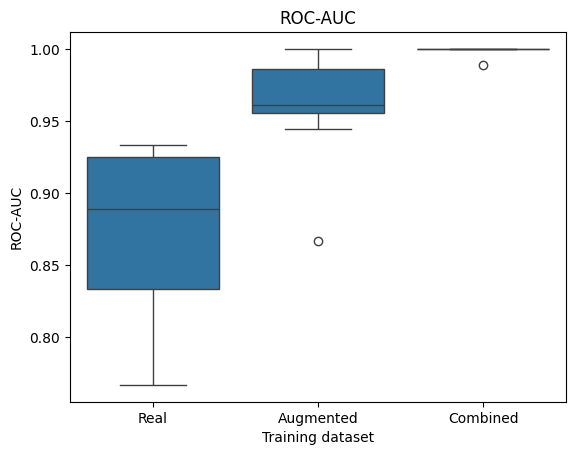

In [161]:
combined_data = np.concatenate([china_cut_real_roc, china_cut_aug_roc, china_cut_comb_roc])
labels = np.repeat(['Real', 'Augmented', 'Combined'], 10)
sns.boxplot(x=labels, y=combined_data)
plt.title('ROC-AUC')
plt.xlabel('Training dataset')
plt.ylabel('ROC-AUC')

## Domain adaptation (ihb to china)

In [ ]:
close = np.load("/content/drive/MyDrive/close_mean_ts_by_network.npy")
open = np.load("/content/drive/MyDrive/open_mean_ts_by_network.npy")
open_china = np.load("/content/drive/MyDrive/china_open_mean_ts_by_network_HCPex.npy")
close_china = np.load("/content/drive/MyDrive/china_close_mean_ts_by_network_HCPex.npy")

In [ ]:
data = np.concatenate((close, open), axis=1)
data = torch.tensor(data).float()
data = data.reshape((168, 14, 120))
labels = [1] * close.shape[1] + [0] * open.shape[1] # 1 - closed, 0 - opened
labels = torch.tensor(labels).float()

In [ ]:
data_china = np.concatenate((close_china, open_china), axis=1)
data_china = torch.tensor(data_china).float()
data_china = data_china.reshape((142, 14, 240))
labels_china = [1] * close_china.shape[1] + [0] * open_china.shape[1] # 1 - closed, 0 - opened
labels_china = torch.tensor(labels_china).float()

In [ ]:
class TimeSeriesCNN(nn.Module):
    def __init__(self, input_channels, hidden_size=128, dropout=0.5):
        super(TimeSeriesCNN, self).__init__()

        self.input_channels = input_channels

        self.conv_layers = nn.Sequential(
            nn.Conv1d(input_channels, 128, kernel_size=5, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.MaxPool1d(kernel_size=2, stride=2, padding=1),

            nn.Conv1d(128, 64, kernel_size=5, padding=2),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.MaxPool1d(kernel_size=2, stride=2, padding=1),

            nn.Conv1d(64, 32, kernel_size=5, padding=2),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.MaxPool1d(kernel_size=2, stride=2, padding=1),

            nn.Conv1d(32, 16, kernel_size=5, padding=2),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.MaxPool1d(kernel_size=2, stride=2, padding=1),
        )

        self.fc1 = nn.Linear(144, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        conv_out = self.conv_layers(x)
        conv_out = conv_out.view(conv_out.size(0), -1)
        fc_out = F.relu(self.fc1(conv_out))
        output = torch.sigmoid(self.fc2(fc_out))
        return output.squeeze(1)

In [ ]:
def train_with_emdedding(model, embedding):
    print_every = 9999
    patience = 4
    epochs_increasing = 0
    last_loss = 100000
    for epoch in range(num_epochs):
        running_loss = 0.0
        y_train_true = []
        y_train_pred_proba = []

        for inputs, labels in train_loader:
            model.train()
            optimizer.zero_grad()
            embed = embedding(inputs)
            output = model(embed)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            y_train_true.extend(labels.cpu().tolist())
            y_train_pred_proba.extend(output.cpu().tolist())
            running_loss += loss.item()

        running_loss /= len(train_loader)
        y_train_true = torch.Tensor(y_train_true)
        y_train_pred_proba = torch.Tensor(y_train_pred_proba)
        train_losses.append(running_loss)
        train_pred = (torch.Tensor(y_train_pred_proba) > 0.5).float()
        accuracy = (train_pred == y_train_true).sum().item() / y_train_true.shape[0]
        train_accuracy.append(accuracy)
        roc_auc = roc_auc_score(y_train_true, y_train_pred_proba)
        train_roc_auc.append(roc_auc)

        test_loss = 0.0
        y_test_true = []
        y_test_pred_proba = []
        for inputs, labels in test_loader:
            model.eval()
            embed = embedding(inputs)
            output = model(embed)
            loss = criterion(output, labels)
            test_loss += loss.item()
            y_test_true.extend(labels.cpu().tolist())
            y_test_pred_proba.extend(output.cpu().tolist())

        test_loss /= len(test_loader)
        y_test_true = torch.Tensor(y_test_true)
        y_test_pred_proba = torch.Tensor(y_test_pred_proba)
        test_losses.append(test_loss)
        test_pred = (torch.Tensor(y_test_pred_proba) > 0.5).float()
        accuracy = (test_pred == y_test_true).sum().item() / y_test_true.shape[0]
        test_accuracy.append(accuracy)
        roc_auc = roc_auc_score(y_test_true, y_test_pred_proba)
        test_roc_auc.append(roc_auc)

        val_loss = 0.0
        for inputs, labels in val_loader:
            model.eval()
            embed = embedding(inputs)
            output = model(embed)
            loss = criterion(output, labels)
            val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        if val_loss > last_loss:
            epochs_increasing += 1
            if epochs_increasing >= patience:
                print('Early stopping!\n')
                return
        else:
            epochs_increasing = 0

        last_loss = val_loss
        if epoch % print_every == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Train loss: {running_loss:.4f}, Test loss: {test_loss:.4f}")

In [ ]:
train_losses_hist = []
test_losses_hist = []
train_accuracy_hist = []
test_accuracy_hist = []
train_roc_auc_hist = []
test_roc_auc_hist = []
val_losses_hist = []

train_losses_hist_china = []
test_losses_hist_china = []
train_accuracy_hist_china = []
test_accuracy_hist_china = []
train_roc_auc_hist_china = []
test_roc_auc_hist_china = []
val_losses_hist_china = []

criterion = nn.CrossEntropyLoss()
input_channels = close.shape[0]

for _ in range(n_experiments):
    for _, (train_index, test_index) in enumerate(kf.split(data, labels)):
      train_data = data[train_index]
      train_labels = labels[train_index]
      test_data = data[test_index]
      test_labels = labels[test_index]
      train_dataset = TensorDataset(train_data, train_labels)
      test_dataset = TensorDataset(test_data, test_labels)
      train_dataset, val_dataset = train_test_split(train_dataset, test_size=0.3, random_state=33)
      train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
      test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
      val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

      train_losses = []
      test_losses = []
      train_accuracy = []
      test_accuracy = []
      train_roc_auc = []
      test_roc_auc = []
      val_losses = []

      model = TimeSeriesCNN(input_channels)
      optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)
      train(model)

      train_losses_hist.append(train_losses)
      test_losses_hist.append(test_losses)
      train_accuracy_hist.append(train_accuracy)
      test_accuracy_hist.append(test_accuracy)
      train_roc_auc_hist.append(train_roc_auc)
      test_roc_auc_hist.append(test_roc_auc)
      val_losses_hist.append(val_losses)

      embedding = nn.Linear(data_china.shape[-1], data.shape[-1])
      dataset = TensorDataset(data_china, labels_china)
      train_dataset, test_dataset = train_test_split(dataset, test_size=0.3, random_state=44)
      train_dataset, val_dataset = train_test_split(train_dataset, test_size=0.3, random_state=44)


      train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
      test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
      val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

      train_losses = []
      test_losses = []
      train_accuracy = []
      test_accuracy = []
      train_roc_auc = []
      test_roc_auc = []
      val_losses = []

      train_with_emdedding(model, embedding)

      train_losses_hist_china.append(train_losses)
      test_losses_hist_china.append(test_losses)
      train_accuracy_hist_china.append(train_accuracy)
      test_accuracy_hist_china.append(test_accuracy)
      train_roc_auc_hist_china.append(train_roc_auc)
      test_roc_auc_hist_china.append(test_roc_auc)
      val_losses_hist_china.append(val_losses)

In [ ]:
train_losses_np = np.array([lst + [0] * (num_epochs - len(lst)) for lst in train_losses_hist])
test_losses_np = np.array([lst + [0] * (num_epochs - len(lst)) for lst in test_losses_hist])
val_losses_np = np.array([lst + [0] * (num_epochs - len(lst)) for lst in val_losses_hist])
train_accuracy_np = np.array([lst + [0] * (num_epochs - len(lst)) for lst in train_accuracy_hist])
test_accuracy_np = np.array([lst + [0] * (num_epochs - len(lst)) for lst in test_accuracy_hist])
train_roc_auc_np = np.array([lst + [0] * (num_epochs - len(lst)) for lst in train_roc_auc_hist])
test_roc_auc_np = np.array([lst + [0] * (num_epochs - len(lst)) for lst in test_roc_auc_hist])

train_losses_np[train_losses_np == 0] = np.nan
test_losses_np[test_losses_np == 0] = np.nan
val_losses_np[val_losses_np == 0] = np.nan
train_accuracy_np[train_accuracy_np == 0] = np.nan
test_accuracy_np[test_accuracy_np == 0] = np.nan
train_roc_auc_np[train_roc_auc_np == 0] = np.nan
test_roc_auc_np[test_roc_auc_np == 0] = np.nan

train_losses_mean = np.nanmean(train_losses_np, axis=0)
train_losses_std = np.nanstd(train_losses_np, axis=0)
test_losses_mean = np.nanmean(test_losses_np, axis=0)
test_losses_std = np.nanstd(test_losses_np, axis=0)
val_losses_mean = np.nanmean(val_losses_np, axis=0)
val_losses_std = np.nanstd(val_losses_np, axis=0)
train_accuracy_mean = np.nanmean(train_accuracy_np, axis=0)
train_accuracy_std = np.nanstd(train_accuracy_np, axis=0)
test_accuracy_mean = np.nanmean(test_accuracy_np, axis=0)
test_accuracy_std = np.nanstd(test_accuracy_np, axis=0)
train_roc_auc_mean = np.nanmean(train_roc_auc_np, axis=0)
train_roc_auc_std = np.nanstd(train_roc_auc_np, axis=0)
test_roc_auc_mean = np.nanmean(test_roc_auc_np, axis=0)
test_roc_auc_std = np.nanstd(test_roc_auc_np, axis=0)

In [ ]:
train_losses_np = np.array([lst + [0] * (num_epochs - len(lst)) for lst in train_losses_hist_china])
test_losses_np = np.array([lst + [0] * (num_epochs - len(lst)) for lst in test_losses_hist_china])
val_losses_np = np.array([lst + [0] * (num_epochs - len(lst)) for lst in val_losses_hist_china])
train_accuracy_np = np.array([lst + [0] * (num_epochs - len(lst)) for lst in train_accuracy_hist_china])
test_accuracy_np = np.array([lst + [0] * (num_epochs - len(lst)) for lst in test_accuracy_hist_china])
train_roc_auc_np = np.array([lst + [0] * (num_epochs - len(lst)) for lst in train_roc_auc_hist_china])
test_roc_auc_np = np.array([lst + [0] * (num_epochs - len(lst)) for lst in test_roc_auc_hist_china])

train_losses_np[train_losses_np == 0] = np.nan
test_losses_np[test_losses_np == 0] = np.nan
val_losses_np[val_losses_np == 0] = np.nan
train_accuracy_np[train_accuracy_np == 0] = np.nan
test_accuracy_np[test_accuracy_np == 0] = np.nan
train_roc_auc_np[train_roc_auc_np == 0] = np.nan
test_roc_auc_np[test_roc_auc_np == 0] = np.nan

train_losses_mean_china = np.nanmean(train_losses_np, axis=0)
train_losses_std_china = np.nanstd(train_losses_np, axis=0)
test_losses_mean_china = np.nanmean(test_losses_np, axis=0)
test_losses_std_china = np.nanstd(test_losses_np, axis=0)
val_losses_mean_china = np.nanmean(val_losses_np, axis=0)
val_losses_std_china = np.nanstd(val_losses_np, axis=0)
train_accuracy_mean_china = np.nanmean(train_accuracy_np, axis=0)
train_accuracy_std_china = np.nanstd(train_accuracy_np, axis=0)
test_accuracy_mean_china = np.nanmean(test_accuracy_np, axis=0)
test_accuracy_std_china = np.nanstd(test_accuracy_np, axis=0)
train_roc_auc_mean_china = np.nanmean(train_roc_auc_np, axis=0)
train_roc_auc_std_china = np.nanstd(train_roc_auc_np, axis=0)
test_roc_auc_mean_china = np.nanmean(test_roc_auc_np, axis=0)
test_roc_auc_std_china = np.nanstd(test_roc_auc_np, axis=0)

In [ ]:
plt.figure(figsize=(8, 6))
plt.errorbar(range(train_losses_mean.shape[0]), train_losses_mean, yerr=train_losses_std, fmt='-o', label='Train losses')
plt.errorbar(range(test_losses_mean.shape[0]), test_losses_mean, yerr=test_losses_std, fmt='-o', label='Test losses')
plt.errorbar(range(val_losses_mean.shape[0]), val_losses_mean, yerr=val_losses_std, fmt='-o', label='Val losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Cross entropy loss (IHB)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
plt.errorbar(range(train_accuracy_mean.shape[0]), train_accuracy_mean, yerr=train_accuracy_std, fmt='-o', label='Train accuracy')
plt.errorbar(range(test_accuracy_mean.shape[0]), test_accuracy_mean, yerr=test_accuracy_std, fmt='-o', label='Test accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy (IHB)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
plt.errorbar(range(train_roc_auc_mean.shape[0]), train_roc_auc_mean, yerr=train_roc_auc_std, fmt='-o', label='Train ROC-AUC')
plt.errorbar(range(test_roc_auc_mean.shape[0]), test_roc_auc_mean, yerr=test_roc_auc_std, fmt='-o', label='Test ROC-AUC')
plt.xlabel('Epoch')
plt.ylabel('ROC-AUC')
plt.title('ROC-AUC (IHB)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
plt.errorbar(range(train_losses_mean_china.shape[0]), train_losses_mean_china, yerr=train_losses_std_china, fmt='-o', label='Train losses')
plt.errorbar(range(test_losses_mean_china.shape[0]), test_losses_mean_china, yerr=test_losses_std_china, fmt='-o', label='Test losses')
plt.errorbar(range(val_losses_mean_china.shape[0]), val_losses_mean_china, yerr=val_losses_std_china, fmt='-o', label='Val losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Cross entropy loss (China)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
plt.errorbar(range(train_accuracy_mean_china.shape[0]), train_accuracy_mean_china, yerr=train_accuracy_std_china, fmt='-o', label='Train accuracy')
plt.errorbar(range(test_accuracy_mean_china.shape[0]), test_accuracy_mean_china, yerr=test_accuracy_std_china, fmt='-o', label='Test accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy (China)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
plt.errorbar(range(train_roc_auc_mean_china.shape[0]), train_roc_auc_mean_china, yerr=train_roc_auc_std_china, fmt='-o', label='Train ROC-AUC')
plt.errorbar(range(test_roc_auc_mean_china.shape[0]), test_roc_auc_mean_china, yerr=test_roc_auc_std_china, fmt='-o', label='Test ROC-AUC')
plt.xlabel('Epoch')
plt.ylabel('ROC-AUC')
plt.title('ROC-AUC (China)')
plt.legend()
plt.grid(True)
plt.show()

## Domain adaptation (china to ihb)

In [ ]:
train_losses_hist = []
test_losses_hist = []
train_accuracy_hist = []
test_accuracy_hist = []
train_roc_auc_hist = []
test_roc_auc_hist = []
val_losses_hist = []

train_losses_hist_china = []
test_losses_hist_china = []
train_accuracy_hist_china = []
test_accuracy_hist_china = []
train_roc_auc_hist_china = []
test_roc_auc_hist_china = []
val_losses_hist_china = []

criterion = nn.CrossEntropyLoss()
input_channels = close.shape[0]

for _ in range(n_experiments):
    for _, (train_index, test_index) in enumerate(kf.split(data_china, labels_china)):
      train_data = data_china[train_index]
      train_labels = labels_china[train_index]
      test_data = data_china[test_index]
      test_labels = labels_china[test_index]
      train_dataset = TensorDataset(train_data, train_labels)
      test_dataset = TensorDataset(test_data, test_labels)
      train_dataset, val_dataset = train_test_split(train_dataset, test_size=0.3, random_state=33)
      train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
      test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
      val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

      train_losses = []
      test_losses = []
      train_accuracy = []
      test_accuracy = []
      train_roc_auc = []
      test_roc_auc = []
      val_losses = []

      model = TimeSeriesCNN(input_channels, conv_output_size=256)
      optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)
      train(model)

      train_losses_hist_china.append(train_losses)
      test_losses_hist_china.append(test_losses)
      train_accuracy_hist_china.append(train_accuracy)
      test_accuracy_hist_china.append(test_accuracy)
      train_roc_auc_hist_china.append(train_roc_auc)
      test_roc_auc_hist_china.append(test_roc_auc)
      val_losses_hist_china.append(val_losses)

      embedding = nn.Linear(data.shape[-1], data_china.shape[-1])
      dataset = TensorDataset(data, labels)
      train_dataset, test_dataset = train_test_split(dataset, test_size=0.3, random_state=44)
      train_dataset, val_dataset = train_test_split(train_dataset, test_size=0.3, random_state=44)


      train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
      test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
      val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

      train_losses = []
      test_losses = []
      train_accuracy = []
      test_accuracy = []
      train_roc_auc = []
      test_roc_auc = []
      val_losses = []

      train_with_emdedding(model, embedding)

      train_losses_hist.append(train_losses)
      test_losses_hist.append(test_losses)
      train_accuracy_hist.append(train_accuracy)
      test_accuracy_hist.append(test_accuracy)
      train_roc_auc_hist.append(train_roc_auc)
      test_roc_auc_hist.append(test_roc_auc)
      val_losses_hist.append(val_losses)

In [ ]:
train_losses_np = np.array([lst + [0] * (num_epochs - len(lst)) for lst in train_losses_hist])
test_losses_np = np.array([lst + [0] * (num_epochs - len(lst)) for lst in test_losses_hist])
val_losses_np = np.array([lst + [0] * (num_epochs - len(lst)) for lst in val_losses_hist])
train_accuracy_np = np.array([lst + [0] * (num_epochs - len(lst)) for lst in train_accuracy_hist])
test_accuracy_np = np.array([lst + [0] * (num_epochs - len(lst)) for lst in test_accuracy_hist])
train_roc_auc_np = np.array([lst + [0] * (num_epochs - len(lst)) for lst in train_roc_auc_hist])
test_roc_auc_np = np.array([lst + [0] * (num_epochs - len(lst)) for lst in test_roc_auc_hist])

train_losses_np[train_losses_np == 0] = np.nan
test_losses_np[test_losses_np == 0] = np.nan
val_losses_np[val_losses_np == 0] = np.nan
train_accuracy_np[train_accuracy_np == 0] = np.nan
test_accuracy_np[test_accuracy_np == 0] = np.nan
train_roc_auc_np[train_roc_auc_np == 0] = np.nan
test_roc_auc_np[test_roc_auc_np == 0] = np.nan

train_losses_mean = np.nanmean(train_losses_np, axis=0)
train_losses_std = np.nanstd(train_losses_np, axis=0)
test_losses_mean = np.nanmean(test_losses_np, axis=0)
test_losses_std = np.nanstd(test_losses_np, axis=0)
val_losses_mean = np.nanmean(val_losses_np, axis=0)
val_losses_std = np.nanstd(val_losses_np, axis=0)
train_accuracy_mean = np.nanmean(train_accuracy_np, axis=0)
train_accuracy_std = np.nanstd(train_accuracy_np, axis=0)
test_accuracy_mean = np.nanmean(test_accuracy_np, axis=0)
test_accuracy_std = np.nanstd(test_accuracy_np, axis=0)
train_roc_auc_mean = np.nanmean(train_roc_auc_np, axis=0)
train_roc_auc_std = np.nanstd(train_roc_auc_np, axis=0)
test_roc_auc_mean = np.nanmean(test_roc_auc_np, axis=0)
test_roc_auc_std = np.nanstd(test_roc_auc_np, axis=0)

In [ ]:
train_losses_np = np.array([lst + [0] * (num_epochs - len(lst)) for lst in train_losses_hist_china])
test_losses_np = np.array([lst + [0] * (num_epochs - len(lst)) for lst in test_losses_hist_china])
val_losses_np = np.array([lst + [0] * (num_epochs - len(lst)) for lst in val_losses_hist_china])
train_accuracy_np = np.array([lst + [0] * (num_epochs - len(lst)) for lst in train_accuracy_hist_china])
test_accuracy_np = np.array([lst + [0] * (num_epochs - len(lst)) for lst in test_accuracy_hist_china])
train_roc_auc_np = np.array([lst + [0] * (num_epochs - len(lst)) for lst in train_roc_auc_hist_china])
test_roc_auc_np = np.array([lst + [0] * (num_epochs - len(lst)) for lst in test_roc_auc_hist_china])

train_losses_np[train_losses_np == 0] = np.nan
test_losses_np[test_losses_np == 0] = np.nan
val_losses_np[val_losses_np == 0] = np.nan
train_accuracy_np[train_accuracy_np == 0] = np.nan
test_accuracy_np[test_accuracy_np == 0] = np.nan
train_roc_auc_np[train_roc_auc_np == 0] = np.nan
test_roc_auc_np[test_roc_auc_np == 0] = np.nan

train_losses_mean_china = np.nanmean(train_losses_np, axis=0)
train_losses_std_china = np.nanstd(train_losses_np, axis=0)
test_losses_mean_china = np.nanmean(test_losses_np, axis=0)
test_losses_std_china = np.nanstd(test_losses_np, axis=0)
val_losses_mean_china = np.nanmean(val_losses_np, axis=0)
val_losses_std_china = np.nanstd(val_losses_np, axis=0)
train_accuracy_mean_china = np.nanmean(train_accuracy_np, axis=0)
train_accuracy_std_china = np.nanstd(train_accuracy_np, axis=0)
test_accuracy_mean_china = np.nanmean(test_accuracy_np, axis=0)
test_accuracy_std_china = np.nanstd(test_accuracy_np, axis=0)
train_roc_auc_mean_china = np.nanmean(train_roc_auc_np, axis=0)
train_roc_auc_std_china = np.nanstd(train_roc_auc_np, axis=0)
test_roc_auc_mean_china = np.nanmean(test_roc_auc_np, axis=0)
test_roc_auc_std_china = np.nanstd(test_roc_auc_np, axis=0)

In [ ]:
plt.figure(figsize=(8, 6))
plt.errorbar(range(train_losses_mean_china.shape[0]), train_losses_mean_china, yerr=train_losses_std_china, fmt='-o', label='Train losses')
plt.errorbar(range(test_losses_mean_china.shape[0]), test_losses_mean_china, yerr=test_losses_std_china, fmt='-o', label='Test losses')
plt.errorbar(range(val_losses_mean_china.shape[0]), val_losses_mean_china, yerr=val_losses_std_china, fmt='-o', label='Val losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Cross entropy loss (China)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
plt.errorbar(range(train_accuracy_mean_china.shape[0]), train_accuracy_mean_china, yerr=train_accuracy_std_china, fmt='-o', label='Train accuracy')
plt.errorbar(range(test_accuracy_mean_china.shape[0]), test_accuracy_mean_china, yerr=test_accuracy_std_china, fmt='-o', label='Test accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy (China)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
plt.errorbar(range(train_roc_auc_mean_china.shape[0]), train_roc_auc_mean_china, yerr=train_roc_auc_std_china, fmt='-o', label='Train ROC-AUC')
plt.errorbar(range(test_roc_auc_mean_china.shape[0]), test_roc_auc_mean_china, yerr=test_roc_auc_std_china, fmt='-o', label='Test ROC-AUC')
plt.xlabel('Epoch')
plt.ylabel('ROC-AUC')
plt.title('ROC-AUC (China)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
plt.errorbar(range(train_losses_mean.shape[0]), train_losses_mean, yerr=train_losses_std, fmt='-o', label='Train losses')
plt.errorbar(range(test_losses_mean.shape[0]), test_losses_mean, yerr=test_losses_std, fmt='-o', label='Test losses')
plt.errorbar(range(val_losses_mean.shape[0]), val_losses_mean, yerr=val_losses_std, fmt='-o', label='Val losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Cross entropy loss (IHB)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
plt.errorbar(range(train_accuracy_mean.shape[0]), train_accuracy_mean, yerr=train_accuracy_std, fmt='-o', label='Train accuracy')
plt.errorbar(range(test_accuracy_mean.shape[0]), test_accuracy_mean, yerr=test_accuracy_std, fmt='-o', label='Test accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy (IHB)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
plt.errorbar(range(train_roc_auc_mean.shape[0]), train_roc_auc_mean, yerr=train_roc_auc_std, fmt='-o', label='Train ROC-AUC')
plt.errorbar(range(test_roc_auc_mean.shape[0]), test_roc_auc_mean, yerr=test_roc_auc_std, fmt='-o', label='Test ROC-AUC')
plt.xlabel('Epoch')
plt.ylabel('ROC-AUC')
plt.title('ROC-AUC (IHB)')
plt.legend()
plt.grid(True)
plt.show()

## WGAN аугментация IHB

In [ ]:
import numpy as np
import torch
from torch.utils.data import DataLoader
from torch import nn
from torch import autograd
import seaborn as sns

# ======================================Defination Process=====================================
# construct the generator with 2 hidden linear layers followed by ReLU
class Generator(nn.Module):

    def __init__(self, input_size, hidden_size, output_size):
        super(Generator, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.Hardshrink(),
            nn.Linear(hidden_size, hidden_size),
            nn.Hardshrink(),
            nn.Linear(hidden_size, hidden_size),
            nn.Hardshrink(),
            nn.Linear(hidden_size, hidden_size),
            nn.Hardshrink(),
            nn.Linear(hidden_size, output_size)
        )
    def forward(self, noise):
        output = self.linear_relu_stack(noise)
        return output

# construct the discriminator with 2 hidden linear layers followed by ReLU
class Discriminator(nn.Module):

    def __init__(self, input_size, hidden_size, output_size):
        super(Discriminator, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.LeakyReLU(inplace=True),
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(inplace=True),
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(inplace=True),
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(inplace=True),
            nn.Linear(hidden_size, output_size)
        )
    def forward(self, inputs):
        output = self.linear_relu_stack(inputs)
        return output

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        nn.init.kaiming_normal_(m.weight, mode='fan_in')
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [ ]:
def calc_gradient_penalty(netD, real_data, fake_data, lamba):
    alpha = torch.rand(batch_size, 1, real_data.shape[-1])
    interpolates = alpha * real_data + ((1-alpha) * fake_data)

    disc_interpolates = netD(interpolates)

    gradients = autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                                grad_outputs=torch.ones(
                                    disc_interpolates.size()),
                                create_graph = True, retain_graph = True, only_inputs = True)[0]

    gradients_norm2 = gradients.norm(2, dim=1) # ord=2 means 2-norm, dim=1 means sum by column
    gradients_penalty = ((gradients_norm2 - 1) ** 2).mean() * lamba

    return gradients_penalty

In [ ]:
close = np.load("/content/drive/MyDrive/close_mean_ts_by_network.npy")
open = np.load("/content/drive/MyDrive/open_mean_ts_by_network.npy")

In [ ]:
data = np.concatenate((close, open), axis=1)
data = torch.tensor(data).float()
data = data.reshape((168, 14, 120))
labels = [1] * close.shape[1] + [0] * open.shape[1] # 1 - closed, 0 - opened
labels = torch.tensor(labels).float()

In [ ]:
close = close.reshape((84, 14, 120))
close = torch.from_numpy(close).to(torch.float32)
open = open.reshape((84, 14, 120))
open = torch.from_numpy(open).to(torch.float32)

In [ ]:
close_train_dataset, close_test_dataset = train_test_split(close, test_size=0.3, random_state=44)
close_train_dataset, close_val_dataset = train_test_split(close_train_dataset, test_size=0.3, random_state=44)

close_train_loader = DataLoader(close_train_dataset, batch_size=batch_size, shuffle=True)
close_test_loader = DataLoader(close_test_dataset, batch_size=batch_size, shuffle=True)
close_val_dataset = DataLoader(close_val_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
lr = 1e-4
hidden_dim = 64

In [ ]:
netG_close = Generator(data.shape[-1], hidden_dim, data.shape[-1])
netD_close = Discriminator(data.shape[-1], hidden_dim, data.shape[-1])
netG_close.apply(weights_init)
netD_close.apply(weights_init)
optimizerG_close = torch.optim.Adam(netG_close.parameters(), lr=lr)
optimizerD_close = torch.optim.Adam(netD_close.parameters(), lr=lr)
netG_close.train()
netD_close.train()

In [ ]:
n_epochs = 100
critic_iters = 3
one = torch.tensor(1, dtype=torch.float)
m_one = one * -1
print_every = 30

# three dists to record the Wasserstein distance(w_cost),
# the critic loss of real data(r_cost), and the loss of fake data(g_cost)
w_cost = []
r_cost = []
g_cost = []
for iteration in range(n_epochs):
  # (1) Update netD

  for p in netD_close.parameters():
      p.requires_grad = True

  for iter_d in range(critic_iters):
      _data = next(iter(close_train_loader))
      real_data = _data
      netD_close.zero_grad()
      real_D = netD_close(real_data)
      real_D = real_D.mean()
      noise = torch.randn(batch_size, data.shape[1], data.shape[2])
      _fake = netG_close(noise)
      fake_data = _fake
      fake_D = netD_close(fake_data)
      fake_D = fake_D.mean()
      #print(real_data.shape, fake_data.shape)
      gradient_penalty = calc_gradient_penalty(netD_close, real_data, fake_data, 0.01)
      D_cost = fake_D - real_D + gradient_penalty
      D_cost.backward()
      optimizerD_close.step()

  # (2) Update netG
  for p in netD_close.parameters():
      p.requires_grad = False

  netG_close.zero_grad()

  # the loss and backward
  noise = torch.randn(batch_size, data.shape[-1])
  fake_data = netG_close(noise)
  loss = netD_close(fake_data)
  loss = loss.mean()
  loss.backward(m_one)
  optimizerG_close.step()

  # (3) Re-calculate the loss and save images

  # the loss of netG
  G_cost = -loss
  g_distance = G_cost.detach().numpy()
  g_cost.append(g_distance)

  # the loss of netD
  real_D = netD_close(real_data)
  real_D = real_D.mean()
  r_distance = real_D.detach().numpy()
  r_cost.append(r_distance)

  # the loss of W distance
  Wasserstein_D = real_D + G_cost
  w_distance = abs(Wasserstein_D.detach().numpy())
  w_cost.append(w_distance)



  if iteration % print_every == 0:
    print("Epoch {iteration}/{n_epochs}:\nG Loss: {g_distance}\nD Loss: {r_distance}\nW Loss: {w_distance}".format(
    iteration=iteration, n_epochs=n_epochs, g_distance=g_distance, r_distance=r_distance, w_distance=w_distance))

In [ ]:
plt.plot(w_cost)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Wasserstein loss (close)')

In [ ]:
plt.plot(r_cost)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Discriminator loss (close)')

In [ ]:
plt.plot(g_cost)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Generator loss (close)')

In [ ]:
gen_size = data.shape[0] * 2
noise = torch.randn(gen_size, data.shape[1], data.shape[2])
fake_close = netG_close(noise)

In [ ]:
open_train_dataset, open_test_dataset = train_test_split(open, test_size=0.3, random_state=44)
open_train_dataset, open_val_dataset = train_test_split(open_train_dataset, test_size=0.3, random_state=44)

open_train_loader = DataLoader(open_train_dataset, batch_size=batch_size, shuffle=True)
open_test_loader = DataLoader(open_test_dataset, batch_size=batch_size, shuffle=True)
open_val_dataset = DataLoader(open_val_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
netG_open = Generator(data.shape[-1], hidden_dim, data.shape[-1])
netD_open = Discriminator(data.shape[-1], hidden_dim, data.shape[-1])
netG_open.apply(weights_init)
netD_open.apply(weights_init)
optimizerG_open = torch.optim.Adam(netG_open.parameters(), lr=lr)
optimizerD_open = torch.optim.Adam(netD_open.parameters(), lr=lr)
netG_open.train()
netD_open.train()

In [ ]:
n_epochs = 100
critic_iters = 3
one = torch.tensor(1, dtype=torch.float)
m_one = one * -1
print_every = 30

# three dists to record the Wasserstein distance(w_cost),
# the critic loss of real data(r_cost), and the loss of fake data(g_cost)
w_cost = []
r_cost = []
g_cost = []
for iteration in range(n_epochs):
  # (1) Update netD

  for p in netD_open.parameters():
      p.requires_grad = True

  for iter_d in range(critic_iters):
      _data = next(iter(open_train_loader))
      real_data = _data
      netD_open.zero_grad()
      real_D = netD_open(real_data)
      real_D = real_D.mean()
      noise = torch.randn(batch_size, data.shape[1], data.shape[2])
      _fake = netG_open(noise)
      fake_data = _fake
      fake_D = netD_open(fake_data)
      fake_D = fake_D.mean()
      #print(real_data.shape, fake_data.shape)
      gradient_penalty = calc_gradient_penalty(netD_open, real_data, fake_data, 0.01)
      D_cost = fake_D - real_D + gradient_penalty
      D_cost.backward()
      optimizerD_open.step()

  # (2) Update netG
  for p in netD_open.parameters():
      p.requires_grad = False

  netG_open.zero_grad()

  # the loss and backward
  noise = torch.randn(batch_size, data.shape[-1])
  fake_data = netG_open(noise)
  loss = netD_open(fake_data)
  loss = loss.mean()
  loss.backward(m_one)
  optimizerG_open.step()

  # (3) Re-calculate the loss and save images

  # the loss of netG
  G_cost = -loss
  g_distance = G_cost.detach().numpy()
  g_cost.append(g_distance)

  # the loss of netD
  real_D = netD_open(real_data)
  real_D = real_D.mean()
  r_distance = real_D.detach().numpy()
  r_cost.append(r_distance)

  # the loss of W distance
  Wasserstein_D = real_D + G_cost
  w_distance = abs(Wasserstein_D.detach().numpy())
  w_cost.append(w_distance)



  if iteration % print_every == 0:
    print("Epoch {iteration}/{n_epochs}:\nG Loss: {g_distance}\nD Loss: {r_distance}\nW Loss: {w_distance}".format(
    iteration=iteration, n_epochs=n_epochs, g_distance=g_distance, r_distance=r_distance, w_distance=w_distance))

In [ ]:
plt.plot(w_cost)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Wasserstein loss (open)')

In [ ]:
plt.plot(r_cost)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Discriminator loss (open)')

In [ ]:
plt.plot(g_cost)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Generator loss (open)')

In [ ]:
noise = torch.randn(gen_size, data.shape[1], data.shape[2])
fake_open = netG_open(noise)

In [ ]:
augmented_data = torch.cat((fake_close, fake_open), dim=0)
augmented_data = augmented_data.detach()

In [ ]:
augmented_data.shape

## WGAN IHB корреляции

In [ ]:
aug_covs = []
for i in range(augmented_data.shape[0]):
  aug_covs.append(np.cov(augmented_data[i]))
aug_covs = np.array(aug_covs)
aug_covs_mean = np.mean(aug_covs, axis=0)
aug_covs_std = np.std(aug_covs, axis=0)

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(aug_covs_mean, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.title('Mean (augmented by transformer)')
plt.subplot(1, 2, 2)
plt.imshow(aug_covs_std, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.title('Std (augmented by transformer)')
plt.tight_layout()
plt.show()

## WGAN аугментация China

In [ ]:
open = np.load("/content/drive/MyDrive/china_open_mean_ts_by_network_HCPex.npy")
close = np.load("/content/drive/MyDrive/china_close_mean_ts_by_network_HCPex.npy")

In [ ]:
data = np.concatenate((close, open), axis=1)
data = torch.tensor(data).float()
data = data.reshape((142, 14, 240))
labels = [1] * close.shape[1] + [0] * open.shape[1] # 1 - closed, 0 - opened
labels = torch.tensor(labels).float()

In [ ]:
close = close.reshape((95, 14, 240))
close = torch.from_numpy(close).to(torch.float32)
open = open.reshape((47, 14, 240))
open = torch.from_numpy(open).to(torch.float32)

In [ ]:
close_train_dataset, close_test_dataset = train_test_split(close, test_size=0.3, random_state=44)
close_train_dataset, close_val_dataset = train_test_split(close_train_dataset, test_size=0.3, random_state=44)

close_train_loader = DataLoader(close_train_dataset, batch_size=batch_size, shuffle=True)
close_test_loader = DataLoader(close_test_dataset, batch_size=batch_size, shuffle=True)
close_val_dataset = DataLoader(close_val_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
netG_close = Generator(data.shape[-1], hidden_dim, data.shape[-1])
netD_close = Discriminator(data.shape[-1], hidden_dim, data.shape[-1])
netG_close.apply(weights_init)
netD_close.apply(weights_init)
optimizerG_close = torch.optim.Adam(netG_close.parameters(), lr=lr)
optimizerD_close = torch.optim.Adam(netD_close.parameters(), lr=lr)
netG_close.train()
netD_close.train()

In [ ]:
n_epochs = 100
critic_iters = 3
one = torch.tensor(1, dtype=torch.float)
m_one = one * -1
print_every = 30

# three dists to record the Wasserstein distance(w_cost),
# the critic loss of real data(r_cost), and the loss of fake data(g_cost)
w_cost = []
r_cost = []
g_cost = []
for iteration in range(n_epochs):
  # (1) Update netD

  for p in netD_close.parameters():
      p.requires_grad = True

  for iter_d in range(critic_iters):
      _data = next(iter(close_train_loader))
      real_data = _data
      netD_close.zero_grad()
      real_D = netD_close(real_data)
      real_D = real_D.mean()
      noise = torch.randn(batch_size, data.shape[1], data.shape[2])
      _fake = netG_close(noise)
      fake_data = _fake
      fake_D = netD_close(fake_data)
      fake_D = fake_D.mean()
      #print(real_data.shape, fake_data.shape)
      gradient_penalty = calc_gradient_penalty(netD_close, real_data, fake_data, 0.01)
      D_cost = fake_D - real_D + gradient_penalty
      D_cost.backward()
      optimizerD_close.step()

  # (2) Update netG
  for p in netD_close.parameters():
      p.requires_grad = False

  netG_close.zero_grad()

  # the loss and backward
  noise = torch.randn(batch_size, data.shape[-1])
  fake_data = netG_close(noise)
  loss = netD_close(fake_data)
  loss = loss.mean()
  loss.backward(m_one)
  optimizerG_close.step()

  # (3) Re-calculate the loss and save images

  # the loss of netG
  G_cost = -loss
  g_distance = G_cost.detach().numpy()
  g_cost.append(g_distance)

  # the loss of netD
  real_D = netD_close(real_data)
  real_D = real_D.mean()
  r_distance = real_D.detach().numpy()
  r_cost.append(r_distance)

  # the loss of W distance
  Wasserstein_D = real_D + G_cost
  w_distance = abs(Wasserstein_D.detach().numpy())
  w_cost.append(w_distance)



  if iteration % print_every == 0:
    print("Epoch {iteration}/{n_epochs}:\nG Loss: {g_distance}\nD Loss: {r_distance}\nW Loss: {w_distance}".format(
    iteration=iteration, n_epochs=n_epochs, g_distance=g_distance, r_distance=r_distance, w_distance=w_distance))

In [ ]:
plt.plot(w_cost)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Wasserstein loss (close)')

In [ ]:
plt.plot(r_cost)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Discriminator loss (close)')

In [ ]:
plt.plot(g_cost)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Generator loss (close)')

In [ ]:
gen_size = close.shape[0] * augments_per_sample
noise = torch.randn(gen_size, data.shape[1], data.shape[2])
fake_close = netG_close(noise)

In [ ]:
batch_size=16

In [ ]:
open_train_dataset, open_test_dataset = train_test_split(open, test_size=0.3, random_state=44)
open_train_dataset, open_val_dataset = train_test_split(open_train_dataset, test_size=0.3, random_state=44)

open_train_loader = DataLoader(open_train_dataset, batch_size=batch_size, shuffle=True)
open_test_loader = DataLoader(open_test_dataset, batch_size=batch_size, shuffle=True)
open_val_dataset = DataLoader(open_val_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
netG_open = Generator(data.shape[-1], hidden_dim, data.shape[-1])
netD_open = Discriminator(data.shape[-1], hidden_dim, data.shape[-1])
netG_open.apply(weights_init)
netD_open.apply(weights_init)
optimizerG_open = torch.optim.Adam(netG_open.parameters(), lr=lr)
optimizerD_open = torch.optim.Adam(netD_open.parameters(), lr=lr)
netG_open.train()
netD_open.train()

In [ ]:
open.shape

In [ ]:
n_epochs = 100
critic_iters = 3
one = torch.tensor(1, dtype=torch.float)
m_one = one * -1
print_every = 30

# three dists to record the Wasserstein distance(w_cost),
# the critic loss of real data(r_cost), and the loss of fake data(g_cost)
w_cost = []
r_cost = []
g_cost = []
for iteration in range(n_epochs):
  # (1) Update netD

  for p in netD_open.parameters():
      p.requires_grad = True

  for iter_d in range(critic_iters):
      _data = next(iter(open_train_loader))
      real_data = _data
      netD_open.zero_grad()
      real_D = netD_open(real_data)
      real_D = real_D.mean()
      noise = torch.randn(batch_size, data.shape[1], data.shape[2])
      _fake = netG_open(noise)
      fake_data = _fake
      fake_D = netD_open(fake_data)
      fake_D = fake_D.mean()
      #print(real_data.shape, fake_data.shape)
      gradient_penalty = calc_gradient_penalty(netD_open, real_data, fake_data, 0.01)
      D_cost = fake_D - real_D + gradient_penalty
      D_cost.backward()
      optimizerD_open.step()

  # (2) Update netG
  for p in netD_open.parameters():
      p.requires_grad = False

  netG_open.zero_grad()

  # the loss and backward
  noise = torch.randn(batch_size, data.shape[-1])
  fake_data = netG_open(noise)
  loss = netD_open(fake_data)
  loss = loss.mean()
  loss.backward(m_one)
  optimizerG_open.step()

  # (3) Re-calculate the loss and save images

  # the loss of netG
  G_cost = -loss
  g_distance = G_cost.detach().numpy()
  g_cost.append(g_distance)

  # the loss of netD
  real_D = netD_open(real_data)
  real_D = real_D.mean()
  r_distance = real_D.detach().numpy()
  r_cost.append(r_distance)

  # the loss of W distance
  Wasserstein_D = real_D + G_cost
  w_distance = abs(Wasserstein_D.detach().numpy())
  w_cost.append(w_distance)



  if iteration % print_every == 0:
    print("Epoch {iteration}/{n_epochs}:\nG Loss: {g_distance}\nD Loss: {r_distance}\nW Loss: {w_distance}".format(
    iteration=iteration, n_epochs=n_epochs, g_distance=g_distance, r_distance=r_distance, w_distance=w_distance))

In [ ]:
plt.plot(w_cost)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Wasserstein loss (open)')

In [ ]:
plt.plot(r_cost)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Discriminator loss (open)')

In [ ]:
plt.plot(g_cost)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Generator loss (open)')

In [ ]:
noise = torch.randn(gen_size, data.shape[1], data.shape[2])
fake_open = netG_open(noise)

In [ ]:
augmented_data = torch.cat((fake_close, fake_open), dim=0)
augmented_data = augmented_data.detach()

## WGAN China корреляции

In [ ]:
aug_covs = []
for i in range(augmented_data.shape[0]):
  aug_covs.append(np.cov(augmented_data[i]))
aug_covs = np.array(aug_covs)
aug_covs_mean = np.mean(aug_covs, axis=0)
aug_covs_std = np.std(aug_covs, axis=0)

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(aug_covs_mean, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.title('Mean (augmented by transformer)')
plt.subplot(1, 2, 2)
plt.imshow(aug_covs_std, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.title('Std (augmented by transformer)')
plt.tight_layout()
plt.show()

## WGAN обучение на аугментированных IHB

In [ ]:
labels = [1] * gen_size + [0] * gen_size
labels = torch.tensor(labels).float()

In [ ]:
augmented_data.shape

In [ ]:
train_losses_hist = []
test_losses_hist = []
train_accuracy_hist = []
test_accuracy_hist = []
train_roc_auc_hist = []
test_roc_auc_hist = []
val_losses_hist = []
aug_accuracy_on_real_hist = []
aug_roc_auc_on_real_hist = []

input_channels = augmented_data.shape[1]

for _ in range(n_experiments):
    for _, (train_index, test_index) in enumerate(kf.split(augmented_data, labels)):
      train_data = augmented_data[train_index]
      train_labels = labels[train_index]
      test_data = augmented_data[test_index]
      test_labels = labels[test_index]
      train_dataset = TensorDataset(train_data, train_labels)
      test_dataset = TensorDataset(test_data, test_labels)
      train_dataset, val_dataset = train_test_split(train_dataset, test_size=0.3, random_state=33)
      aug_train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
      aug_test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
      aug_val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

      train_losses = []
      test_losses = []
      train_accuracy = []
      test_accuracy = []
      train_roc_auc = []
      test_roc_auc = []
      val_losses = []
      aug_accuracy_on_real = []
      aug_roc_auc_on_real = []

      model = TimeSeriesCNN(input_channels)
      optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)
      aug_train(model)

      train_losses_hist.append(train_losses)
      test_losses_hist.append(test_losses)
      train_accuracy_hist.append(train_accuracy)
      test_accuracy_hist.append(test_accuracy)
      train_roc_auc_hist.append(train_roc_auc)
      test_roc_auc_hist.append(test_roc_auc)
      val_losses_hist.append(val_losses)
      aug_accuracy_on_real_hist.append(aug_accuracy_on_real)
      aug_roc_auc_on_real_hist.append(aug_roc_auc_on_real)

In [ ]:
train_losses_np = np.array([lst + [0] * (num_epochs - len(lst)) for lst in train_losses_hist])
val_losses_np = np.array([lst + [0] * (num_epochs - len(lst)) for lst in val_losses_hist])
train_accuracy_np = np.array([lst + [0] * (num_epochs - len(lst)) for lst in train_accuracy_hist])
train_roc_auc_np = np.array([lst + [0] * (num_epochs - len(lst)) for lst in train_roc_auc_hist])
aug_accuracy_on_real_np = np.array([lst + [0] * (num_epochs - len(lst)) for lst in aug_accuracy_on_real_hist])
aug_roc_auc_on_real_np = np.array([lst + [0] * (num_epochs - len(lst)) for lst in aug_roc_auc_on_real_hist])

train_losses_np[train_losses_np == 0] = np.nan
val_losses_np[val_losses_np == 0] = np.nan
train_accuracy_np[train_accuracy_np == 0] = np.nan
train_roc_auc_np[train_roc_auc_np == 0] = np.nan
aug_accuracy_on_real_np[aug_accuracy_on_real_np == 0] = np.nan
aug_roc_auc_on_real_np[aug_roc_auc_on_real_np == 0] = np.nan

train_losses_mean = np.nanmean(train_losses_np, axis=0)
train_losses_std = np.nanstd(train_losses_np, axis=0)
val_losses_mean = np.nanmean(val_losses_np, axis=0)
val_losses_std = np.nanstd(val_losses_np, axis=0)
train_accuracy_mean = np.nanmean(train_accuracy_np, axis=0)
train_accuracy_std = np.nanstd(train_accuracy_np, axis=0)
train_roc_auc_mean = np.nanmean(train_roc_auc_np, axis=0)
train_roc_auc_std = np.nanstd(train_roc_auc_np, axis=0)
aug_accuracy_on_real_mean = np.nanmean(aug_accuracy_on_real_np, axis=0)
aug_accuracy_on_real_std = np.nanstd(aug_accuracy_on_real_np, axis=0)
aug_roc_auc_on_real_mean = np.nanmean(aug_roc_auc_on_real_np, axis=0)
aug_roc_auc_on_real_std = np.nanstd(aug_roc_auc_on_real_np, axis=0)

In [ ]:
ihb_wgan_acc_mean = np.max(aug_accuracy_on_real_mean)
ihb_wgan_acc_std = aug_accuracy_on_real_std[np.argmax(aug_accuracy_on_real_mean)]
ihb_wgan_roc_mean = np.max(aug_roc_auc_on_real_mean)
ihb_wgan_roc_std = aug_roc_auc_on_real_std[np.argmax(aug_roc_auc_on_real_mean)]

In [ ]:
ihb_wgan_acc = aug_accuracy_on_real_np
ihb_wgan_roc = aug_roc_auc_on_real_np

In [ ]:
plt.figure(figsize=(8, 6))
plt.errorbar(range(train_losses_mean.shape[0]), train_losses_mean, yerr=train_losses_std, fmt='-o', label='Train losses')
plt.errorbar(range(val_losses_mean.shape[0]), val_losses_mean, yerr=val_losses_std, fmt='-o', label='Val losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Cross entropy loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
plt.errorbar(range(train_accuracy_mean.shape[0]), train_accuracy_mean, yerr=train_accuracy_std, fmt='-o', label='Train accuracy')
plt.errorbar(range(aug_accuracy_on_real_mean.shape[0]), aug_accuracy_on_real_mean, yerr=aug_accuracy_on_real_std, fmt='-o', label='Accuracy on real data')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
plt.errorbar(range(train_roc_auc_mean.shape[0]), train_roc_auc_mean, yerr=train_roc_auc_std, fmt='-o', label='Train ROC-AUC')
plt.errorbar(range(aug_roc_auc_on_real_mean.shape[0]), aug_roc_auc_on_real_mean, yerr=aug_roc_auc_on_real_std, fmt='-o', label='ROC-AUC on real data')
plt.xlabel('Epoch')
plt.ylabel('ROC-AUC')
plt.title('ROC-AUC')
plt.legend()
plt.grid(True)
plt.show()

## ROI

In [ ]:
open = np.load("/content/drive/MyDrive/china_open_roi_HCPex.npy")
close = np.load("/content/drive/MyDrive/china_close_roi_HCPex.npy")

In [ ]:
open.shape, close.shape # [eyes, time, roi]

In [ ]:
open = open.reshape((421, 47, 240))
close = close.reshape((421, 95, 240))

In [ ]:
data = np.concatenate((close, open), axis=1)
data = torch.tensor(data).float()
data = data.reshape((142, 421, 240))

labels = [1] * close.shape[1] + [0] * open.shape[1] # 1 - closed, 0 - opened
labels = torch.tensor(labels).float()

dataset = TensorDataset(data, labels)
train_dataset, test_dataset = train_test_split(dataset, test_size=0.3, random_state=44)
train_dataset, val_dataset = train_test_split(train_dataset, test_size=0.3, random_state=44)


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
train_ratio = 0
for i in range(len(train_dataset)):
    if train_dataset[i][1].item() == 0:
        train_ratio += 1
print(train_ratio / len(train_dataset))

test_ratio = 0
for i in range(len(test_dataset)):
    if test_dataset[i][1].item() == 0:
        test_ratio += 1
print(test_ratio / len(test_dataset))

In [ ]:
len(train_dataset), len(test_dataset), len(val_dataset)

In [ ]:
class TimeSeriesCNN(nn.Module):
    def __init__(self, input_channels, hidden_size=128, dropout=0.5):
        super(TimeSeriesCNN, self).__init__()
        self.conv_layers = nn.ModuleList()
        self.input_channels = input_channels

        for _ in range(input_channels):
            self.conv_layers.append(nn.Sequential(
                nn.Conv1d(1, 200, kernel_size=5),
                nn.ReLU(),
                nn.Dropout(p=dropout),
                nn.MaxPool1d(kernel_size=2, stride=2, padding=1),
                nn.Conv1d(200, 128, kernel_size=5),
                nn.ReLU(),
                nn.Dropout(p=dropout),
                nn.MaxPool1d(kernel_size=2, stride=2, padding=1),
                nn.Conv1d(128, 64, kernel_size=5),
                nn.ReLU(),
                nn.Dropout(p=dropout),
                nn.MaxPool1d(kernel_size=2, stride=2, padding=1),
                nn.Conv1d(64, 32, kernel_size=5),
                nn.ReLU(),
                nn.Dropout(p=dropout),
                nn.MaxPool1d(kernel_size=2, stride=2, padding=1),
                nn.Conv1d(32, 16, kernel_size=5),
                nn.ReLU(),
                nn.Dropout(p=dropout),
                nn.MaxPool1d(kernel_size=2, stride=2, padding=1),
            ))

        self.fc1 = nn.Linear(1120, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        conv_outs = []
        for i in range(self.input_channels):
            conv_out = self.conv_layers[i](x[:, i:i+1, :])
            conv_outs.append(conv_out)
        conv_out = torch.cat(conv_outs, dim=1)
        conv_out = conv_out.view(conv_out.size(0), -1)
        fc_out = F.relu(self.fc1(conv_out))
        output = torch.sigmoid(self.fc2(fc_out))
        return output.squeeze(1)

In [ ]:
n_experiments = 5

In [ ]:
train_losses_hist = []
test_losses_hist = []
train_accuracy_hist = []
test_accuracy_hist = []
train_roc_auc_hist = []
test_roc_auc_hist = []
val_losses_hist = []

input_channels = close.shape[0]

for _ in range(n_experiments):
    train_losses = []
    test_losses = []
    train_accuracy = []
    test_accuracy = []
    train_roc_auc = []
    test_roc_auc = []
    val_losses = []

    model = TimeSeriesCNN(input_channels)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)
    train(model)

    train_losses_hist.append(train_losses)
    test_losses_hist.append(test_losses)
    train_accuracy_hist.append(train_accuracy)
    test_accuracy_hist.append(test_accuracy)
    train_roc_auc_hist.append(train_roc_auc)
    test_roc_auc_hist.append(test_roc_auc)
    val_losses_hist.append(val_losses)